In [1]:
import sys
sys.path.insert(0, "../")

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from src.utils import *
from src.dataloader import *
from src.models import *
from triage.triage_torch import Triage
from src.metrics import *

import numpy as np
from scipy.stats import sem

import matplotlib.pyplot as plt
import seaborn as sns


plt.style.reload_library()


SMALL_SIZE = 10
MEDIUM_SIZE = 50
BIGGER_SIZE = 50

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

uci_datasets = ['boston',
 'concrete',
 'protein',
 'bike',
 'star', 
 'concrete', 
 'bio']


seed=42
EPOCHS=50


_ALL_REGRESSION_DATASETS = ALL_REGRESSION_DATASETS


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import pandas as pd
def get_dataset(dataset='cf', processing_needed=False):

    if dataset=='los':
        outcome_variable = 'lengthofstay'
        df = pd.read_csv("../data/LengthOfStay.csv")
        dropcols = ['eid', 'vdate', 'discharged', 'facid']
        df = df.drop(columns=dropcols)
        df = df.sample(n=10000,random_state=seed)

        from sklearn import preprocessing
        le1 = preprocessing.LabelEncoder()
        df['rcount'] =le1.fit_transform(df['rcount'])
        le2 = preprocessing.LabelEncoder()
        df['gender'] =le2.fit_transform(df['gender'])
        processing_needed = False

    if dataset =='mimic_antibiotics':
        outcome_variable = 'wbc'
        df_static = pd.read_csv("../data/mimic_antibiotics_static_train_data.csv")
        df_temporal = pd.read_csv("../data/mimic_antibiotics_temporal_train_data_eav.csv")
        processing_needed = True

    if dataset=='ward':

        outcome_variable = 'Glasgow Coma Scale Score'
        outcome_variable = 'WHITE BLOOD CELL COUNT'
        df_static = pd.read_csv("../data/ward_static_train_data.csv")
        df_temporal = pd.read_csv("../data/ward_temporal_train_data_eav.csv")
        processing_needed = True

    if dataset!='cancer' and dataset not in uci_datasets:
        if processing_needed:
            ids_static= df_static.id.unique()
            ids_temporal=df_temporal[df_temporal['time']==0].id.unique()


            if len(ids_temporal)<len(ids_static):
                ids = ids_temporal
            else:
                ids = ids_static

            df_static = df_static[df_static.id.isin(ids)]
            df_temporal = df_temporal[df_temporal.id.isin(ids)]
            df_temporal= df_temporal[df_temporal['time']==0]

            df_temporal_label = df_temporal[df_temporal['variable']==outcome_variable]
            if len(df_temporal_label)==0:
                df_temporal_label = df_static[[outcome_variable,'id']]

            if len(df_temporal_label)!=len(df_temporal):
                ids = df_temporal_label.id
                df_static = df_static[df_static.id.isin(ids)]
                df_temporal = df_temporal[df_temporal.id.isin(ids)]

            df_static.shape, df_temporal[df_temporal['variable']==outcome_variable].shape

            df_temporal = df_temporal.sort_values(by=['id'])
            df_static = df_static.sort_values(by=['id'])

            temporal_unique_ids = df_temporal.id.unique().shape
            static_shape = df_static.shape

            assert temporal_unique_ids[0]==static_shape[0]

            feature_dict = {}
            for variable_name in list(df_temporal.variable.unique()):
                tdf = df_temporal[df_temporal['variable']==variable_name]
                variable_array= tdf.drop_duplicates(subset=['id']).value.to_numpy()
                feature_dict[variable_name] = variable_array

            tmp_df = pd.DataFrame.from_dict(feature_dict, columns = df_static.id, orient='index').T.reset_index(level=0)
    

            temporal_shape = tmp_df.shape
            df_overall= df_static.merge(tmp_df, on='id', how='left')

            assert df_overall[outcome_variable].shape[0]==static_shape[0]

        else:
            df_overall = df



    ###########################################
    # DATA SETUP
    ###########################################


    if dataset=='house':
        data_openml = fetch_openml(name="house_sales",version=3)
        #X = dataset.data.values.astype(float)
        X = data_openml.data.values.astype(float)
        y = data_openml.target.values.astype(float)

    if dataset!='cancer' and dataset not in uci_datasets:
        X = df_overall.drop(columns=[outcome_variable])
        y = df_overall[outcome_variable].values

    if dataset=='cancer':
        X, y, df = load_seer_cutract_dataset(name="seer", seed=42)
        y=y.values
        
    if dataset in uci_datasets:
        regression_datasets = list(_ALL_REGRESSION_DATASETS.keys())
        regression_datasets.sort()

        if dataset in regression_datasets:
            # xlrd, openpyxl
            import tempfile
            dataset_name = regression_datasets[mapper[dataset]]
            with tempfile.TemporaryDirectory() as data_dir:
                # download and load data
                download_regression_dataset(dataset_name, data_dir)
                X, y = load_regression_dataset(dataset_name, data_dir, shuffle_train=True, batch_size=512)
                print(dataset)
        else:
            X,y = GetDataset(dataset, "../data/")
    
    if dataset not in uci_datasets:
        from copy import deepcopy
        df_overall = deepcopy(X)
        df_overall['y'] = y


    y = np.array([(y[i]-y.min())/(y.max()-y.min()) for i in range(len(y))])

    return X,y  

In [3]:
def train_compute2(X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test, EPOCHS=50):
    x_train = torch.FloatTensor(X_prop_train).to(device)
    y_train = torch.FloatTensor(y_prop_train).to(device)
    X_cal = torch.FloatTensor(X_cal).to(device)
    y_cal = torch.FloatTensor(y_cal).to(device)
    y_eval = y_train
    X_eval = x_train


    ###########################################
    # DATALOADER
    ###########################################

    n_feats = x_train.shape[1]
    nets = [
            Net1(input_size=n_feats, nlabels=1),
            Net2(input_size=n_feats, nlabels=1),
            Net3(input_size=n_feats, nlabels=1),
            Net4(input_size=n_feats, nlabels=1),
            Net5(input_size=n_feats, nlabels=1),
            Net6(input_size=n_feats, nlabels=1),
            Net7(input_size=n_feats, nlabels=1),
            Net1(input_size=n_feats, nlabels=1),
        ]

    ###########################################
    # MODEL SETUP
    ###########################################
    from tqdm import tqdm

    triage_store = {}
    crps_store = {}
    vog_store = {}
    loss_store = {}
    residual_store = {}
    gradnorm_store = {}


    for idx in tqdm(range(len(nets))):


        delta=0.001

        if idx <3:
            early_stopping = EarlyStopping(patience=5, delta=delta)
        else:
            early_stopping = EarlyStopping(patience=20, delta=delta)


        grad_X = x_train.to(device)
        grad_Y = y_train.to(device)

        train_data = TrainData(torch.FloatTensor(X_prop_train).to(device), torch.FloatTensor(y_prop_train).to(device))
        trainloader = DataLoader(dataset=train_data, batch_size=128, shuffle=True)


        mlp = nets[idx]
        mlp= mlp.to(device)

        # Define the loss function and optimizer
        loss_function = nn.L1Loss(reduction='none')
        optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)
        
        if idx==4:
            optimizer = torch.optim.SGD(mlp.parameters(), lr=0.01)
        
        vog = {}
        loss_values = []


        gn = grad_norm(X=x_train, y=y_train)
        triage = Triage(X_eval = X_eval, y_eval = y_eval, X_cal = X_cal, y_cal = y_cal, learner = mlp)

        # Run the training loop
        for epoch in range(0, EPOCHS): 
            mlp.train()
            # Set current loss value
            current_loss = 0.0

            # Zero the gradients
            optimizer.zero_grad()

            # Perform forward pass
            outputs = mlp(x_train)

            # Compute loss
            loss_each = loss_function(outputs, y_train)

            ###########################################
            # per-sample loss
            ###########################################
            loss =  loss_each.mean() #torch.mean(loss_each)
            loss_each = torch.mean( loss_each.detach(),1 )
            loss_values.append(loss_each.detach().cpu().numpy())


            #assert loss.shape == (len(data),)
            loss = loss.mean()  # Reduction has been disabled -- do explicit reduction


            # Perform backward pass
            loss.backward()

            # Perform optimization
            optimizer.step()

            # Print statistics
            current_loss = loss.item()

            print(f"Epoch {epoch} = {current_loss}")

            gn.gradient(net=mlp, device=device)
            ######################################################################################
            # EVALUATION

            mlp.eval()

            ###########################################
            # TRIAGE
            ###########################################
            groups_ids, raw_metrics = triage.run(learner=mlp)
              

            ###########################################
            # Variance of gradients (VOG)
            ###########################################

            # Get gradients
            # Get the index corresponding to the maximum score and the maximum score itself.
            grad_X.requires_grad = True
            sel_nodes_shape = grad_Y.shape
            ones = torch.ones(sel_nodes_shape).to(device)
            outputs = mlp(grad_X)
            sel_nodes = outputs[torch.arange(len(grad_Y))]

            try:
                sel_nodes.backward(ones)
            except:
                ones = torch.unsqueeze(ones, dim=-1)
                sel_nodes.backward(ones)
            grad = grad_X.grad.data.cpu().numpy()
            for i in range(grad_X.shape[0]):
                if i not in vog.keys():
                    vog[i] = []
                    vog[i].append(grad[i, :].tolist())
                else:
                    vog[i].append(grad[i, :].tolist())

            early_stopping(current_loss, mlp)

            if early_stopping.early_stop:
                print("Early stopping")
                break

        training_vog_stats, training_labels = vog_scores(grad_X, grad_Y, vog)


        triage_store[idx]= np.array(raw_metrics['score_metric'])
        vog_store[idx]=np.array(training_vog_stats)
        loss_store[idx]=np.array(loss_values).T
        residual_store[idx]=np.array(triage._errors_array)
        gradnorm_store[idx] = np.array(gn._grads)


    return triage_store, vog_store, loss_store, residual_store, gradnorm_store, crps_store

In [4]:
from autograd_lib import autograd_lib

def process_data(X,y, impute='mean', seed=42):
    from hyperimpute.plugins.imputers import Imputers
    imputers = Imputers()
    method = impute
    plugin = Imputers().get(method)
    X = plugin.fit_transform(X.copy())

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed)

    X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                                test_size=0.25, random_state=seed)
    return X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test

def train_compute(X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test, EPOCHS=50):
    x_train = torch.FloatTensor(X_prop_train).to(device)
    y_train = torch.FloatTensor(y_prop_train).to(device)
    X_cal = torch.FloatTensor(X_cal).to(device)
    y_cal = torch.FloatTensor(y_cal).to(device)
    y_eval = y_train
    X_eval = x_train


    ###########################################
    # DATALOADER
    ###########################################

    n_feats = x_train.shape[1]
    nets = [
        Net1(input_size=n_feats, nlabels=1),
        Net2(input_size=n_feats, nlabels=1),
        Net3(input_size=n_feats, nlabels=1),
        Net4(input_size=n_feats, nlabels=1),
        Net5(input_size=n_feats, nlabels=1),
        Net6(input_size=n_feats, nlabels=1),
        Net7(input_size=n_feats, nlabels=1),
    ]

    ###########################################
    # MODEL SETUP
    ###########################################
    from tqdm import tqdm

    triage_store = {}
    crps_store = {}
    vog_store = {}
    loss_store = {}
    residual_store = {}
    gradnorm_store = {}


    for idx in tqdm(range(len(nets))):

        delta=0.001
        
        if idx <3:
            early_stopping = EarlyStopping(patience=5, delta=delta)
        else:
            early_stopping = EarlyStopping(patience=20, delta=delta)


        grad_X = x_train.to(device)
        grad_Y = y_train.to(device)

        train_data = TrainData(torch.FloatTensor(X_prop_train).to(device), torch.FloatTensor(y_prop_train).to(device))
        trainloader = DataLoader(dataset=train_data, batch_size=128, shuffle=True)


        mlp = nets[idx]
        mlp = mlp.to(device)

        # Define the loss function and optimizer
        loss_function = nn.L1Loss(reduction='none')
        optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)
        
        if idx==4:
            optimizer = torch.optim.SGD(mlp.parameters(), lr=0.01)
        
        vog = {}
        loss_values = []

        gn = grad_norm(X=x_train, y=y_train)
        triage = Triage(X_eval = X_eval, y_eval = y_eval, X_cal = X_cal, y_cal = y_cal, learner = mlp)


        # Run the training loop
        for epoch in range(0, EPOCHS): 
            mlp.train()
            # Set current loss value
            current_loss = 0.0

            # Zero the gradients
            optimizer.zero_grad()

            # Perform forward pass
            outputs = mlp(x_train)

            # Compute loss
            loss_each = loss_function(outputs, y_train)

            ###########################################
            # per-sample loss
            ###########################################
            loss =  loss_each.mean() 
            loss_each = torch.mean( loss_each.detach(),1 )
            loss_values.append(loss_each.detach().cpu().numpy())


            #assert loss.shape == (len(data),)
            loss = loss.mean()  # Reduction has been disabled -- do explicit reduction


            # Perform backward pass
            loss.backward()

            # Perform optimization
            optimizer.step()

            # Print statistics
            current_loss = loss.item()

            print(f"Epoch {epoch} = {current_loss}")

            gn.gradient(net=mlp, device=device)
            ######################################################################################
            # EVALUATION

            mlp.eval()

    
            ###########################################
            # TRIAGE
            ###########################################
            groups_ids, raw_metrics = triage.run(learner=mlp)
              

            ###########################################
            # Variance of gradients (VOG)
            ###########################################

            # Get gradients
            # Get the index corresponding to the maximum score and the maximum score itself.
            grad_X.requires_grad = True
            sel_nodes_shape = grad_Y.shape
            ones = torch.ones(sel_nodes_shape).to(device)
            outputs = mlp(grad_X)
            sel_nodes = outputs[torch.arange(len(grad_Y))]

            ones = torch.unsqueeze(ones, dim=-1)
            sel_nodes.backward(ones)
            grad = grad_X.grad.data.cpu().numpy()
            for i in range(grad_X.shape[0]):
                if i not in vog.keys():
                    vog[i] = []
                    vog[i].append(grad[i, :].tolist())
                else:
                    vog[i].append(grad[i, :].tolist())

            early_stopping(current_loss, mlp)

            if early_stopping.early_stop:
                print("Early stopping")
                break


        training_vog_stats, training_labels = vog_scores(grad_X, grad_Y, vog)

        triage_store[idx]= np.array(raw_metrics['score_metric'])
        vog_store[idx]=np.array(training_vog_stats)
        loss_store[idx]=np.array(loss_values).T
        residual_store[idx]=np.array(triage._errors_array)
        gradnorm_store[idx] = np.array(gn._grads)


    return triage_store, vog_store, loss_store, residual_store, gradnorm_store, crps_store#, cpds_store

def compute_corrs(metric, vog=False, aleatoric=False, burnin=False):
    from itertools import combinations
    from scipy import stats

    N = len(metric.keys())
    combos = list(combinations(list(range(N)), 2))

    corr = []
    corr2 = []
    corr3 = []
    corr4 = []
    for combo in combos:

        if aleatoric is True:
            rvs1 = np.mean(metric[combo[0]] * (1 - metric[combo[0]]), axis=-1)
            rvs2 = np.mean(metric[combo[1]] * (1 - metric[combo[1]]), axis=-1)
        if vog==True:
            rvs1 = metric[combo[0]]
            rvs2 = metric[combo[1]]
        else:
            rvs1 = np.mean(metric[combo[0]],axis=1)
            rvs2 = np.mean(metric[combo[1]],axis=1)
            
        if burnin==True:
            epochs = metric[combo[0]].shape[1]
            rvs1 = np.mean(metric[combo[0]][:, int(epochs/2):],axis=1)
            rvs2 = np.mean(metric[combo[1]][:, int(epochs/2):],axis=1)

        corr.append(np.corrcoef(rvs1, rvs2)[0, 1])
        corr2.append(stats.spearmanr(rvs1, rvs2)[0])
        corr3.append(stats.kendalltau(rvs1, rvs2)[0])
        corr4.append(stats.wilcoxon(rvs1, rvs2)[0])

    return corr, corr2, corr3

In [6]:
dataset = 'cancer'
X,y = get_dataset(dataset=dataset, processing_needed=False)
try:
    X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test = process_data(X,y, impute='mean', seed=seed)

except:
    import traceback
    print(traceback.format_exc())

triage_store, vog_store, loss_store, residual_store, gradnorm_store, crps_store  = train_compute(X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test, EPOCHS=EPOCHS)

_, vog_spearman, vog_kendall = compute_corrs(metric=vog_store, vog=True, aleatoric=False)
_, loss_spearman, loss_kendall = compute_corrs(metric=loss_store, aleatoric=False, burnin=False)
_, gradn_spearman, gradn_kendall = compute_corrs(metric=gradnorm_store, aleatoric=False, burnin=False)
_, residual_spearman, residual_kendall = compute_corrs(metric=residual_store, aleatoric=False)
_, pval_spearman, pval_kendall = compute_corrs(metric=triage_store, aleatoric=False)
_, alea_spearman, alea_kendall = compute_corrs(metric=triage_store, aleatoric=True)

los_means_spearman = [np.mean(vog_spearman), np.mean(loss_spearman), np.mean(gradn_spearman), np.mean(residual_spearman), np.mean(pval_spearman), np.mean(alea_spearman)]
los_means_kendall = [np.mean(vog_kendall), np.mean(loss_kendall), np.mean(gradn_kendall), np.mean(residual_kendall), np.mean(pval_kendall), np.mean(alea_kendall)]

los_sem_spearman = [sem(vog_spearman), sem(loss_spearman), sem(gradn_spearman), sem(residual_spearman), sem(pval_spearman), sem(alea_spearman)]
los_sem_kendall = [sem(vog_kendall), sem(loss_kendall), sem(gradn_kendall), sem(residual_kendall), sem(pval_kendall), sem(alea_kendall)]


triage_store_los = triage_store
crps_store_los = crps_store


  0%|          | 0/7 [00:00<?, ?it/s]/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather th

Epoch 0 = 0.507964551448822


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (inf --> 0.507965).  Saving model ...
Epoch 1 = 0.4453682005405426


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.507965 --> 0.445368).  Saving model ...
Epoch 2 = 0.3483831286430359


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.445368 --> 0.348383).  Saving model ...
Epoch 3 = 0.26805630326271057


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.348383 --> 0.268056).  Saving model ...
Epoch 4 = 0.30123940110206604


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 5
Epoch 5 = 0.3193656802177429


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 2 out of 5
Epoch 6 = 0.3065902292728424


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 3 out of 5
Epoch 7 = 0.2833330035209656


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 4 out of 5
Epoch 8 = 0.2644662857055664


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.268056 --> 0.264466).  Saving model ...
Epoch 9 = 0.25709089636802673


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.264466 --> 0.257091).  Saving model ...
Epoch 10 = 0.2642672061920166


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 5
Epoch 11 = 0.27281320095062256


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 2 out of 5
Epoch 12 = 0.26948481798171997


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 3 out of 5
Epoch 13 = 0.26058417558670044


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 4 out of 5
Epoch 14 = 0.2560673952102661


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.257091 --> 0.256067).  Saving model ...
Epoch 15 = 0.2566601634025574


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 5
Epoch 16 = 0.2593829929828644


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 2 out of 5
Epoch 17 = 0.26189595460891724


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 3 out of 5
Epoch 18 = 0.2629634141921997


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 4 out of 5
Epoch 19 = 0.2623847723007202


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 5 out of 5
Early stopping


 14%|█▍        | 1/7 [00:09<00:58,  9.82s/it]/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), r

Epoch 0 = 0.2807115912437439


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (inf --> 0.280712).  Saving model ...
Epoch 1 = 0.2830006182193756


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 5
Epoch 2 = 0.27752700448036194


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.280712 --> 0.277527).  Saving model ...
Epoch 3 = 0.2658737003803253


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.277527 --> 0.265874).  Saving model ...
Epoch 4 = 0.25843849778175354


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.265874 --> 0.258438).  Saving model ...
Epoch 5 = 0.2560723125934601


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.258438 --> 0.256072).  Saving model ...
Epoch 6 = 0.25624337792396545


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 5
Epoch 7 = 0.2565215826034546


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 2 out of 5
Epoch 8 = 0.25634366273880005


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 3 out of 5
Epoch 9 = 0.2559102177619934


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 4 out of 5
Epoch 10 = 0.255554735660553


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 5 out of 5
Early stopping


 29%|██▊       | 2/7 [00:15<00:35,  7.19s/it]/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), r

Epoch 0 = 0.46345970034599304


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (inf --> 0.463460).  Saving model ...
Epoch 1 = 0.3933833837509155


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.463460 --> 0.393383).  Saving model ...
Epoch 2 = 0.3258863687515259


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.393383 --> 0.325886).  Saving model ...
Epoch 3 = 0.2699730694293976


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.325886 --> 0.269973).  Saving model ...
Epoch 4 = 0.26761484146118164


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.269973 --> 0.267615).  Saving model ...
Epoch 5 = 0.2838229537010193


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 5
Epoch 6 = 0.28975075483322144


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 2 out of 5
Epoch 7 = 0.2843395471572876


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 3 out of 5
Epoch 8 = 0.27347657084465027


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 4 out of 5
Epoch 9 = 0.26292815804481506


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.267615 --> 0.262928).  Saving model ...
Epoch 10 = 0.2568792998790741


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.262928 --> 0.256879).  Saving model ...
Epoch 11 = 0.25827497243881226


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 5
Epoch 12 = 0.26428112387657166


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 2 out of 5
Epoch 13 = 0.26465535163879395


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 3 out of 5
Epoch 14 = 0.2604316473007202


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 4 out of 5
Epoch 15 = 0.2569086253643036


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 5 out of 5
Early stopping


 43%|████▎     | 3/7 [00:22<00:29,  7.28s/it]/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), r

Epoch 0 = 0.3134424388408661


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (inf --> 0.313442).  Saving model ...
Epoch 1 = 0.34814199805259705


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 20
Epoch 2 = 0.3438687324523926


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 2 out of 20
Epoch 3 = 0.3013380169868469


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.313442 --> 0.301338).  Saving model ...
Epoch 4 = 0.26924097537994385


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.301338 --> 0.269241).  Saving model ...
Epoch 5 = 0.2591048777103424


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.269241 --> 0.259105).  Saving model ...
Epoch 6 = 0.26749294996261597


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 20
Epoch 7 = 0.2754386365413666


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 2 out of 20
Epoch 8 = 0.2717529535293579


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 3 out of 20
Epoch 9 = 0.26325681805610657


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 4 out of 20
Epoch 10 = 0.25782111287117004


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.259105 --> 0.257821).  Saving model ...
Epoch 11 = 0.25672873854637146


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.257821 --> 0.256729).  Saving model ...
Epoch 12 = 0.2581304609775543


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 20
Epoch 13 = 0.26015183329582214


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 2 out of 20
Epoch 14 = 0.26161015033721924


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 3 out of 20
Epoch 15 = 0.26198676228523254


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 4 out of 20
Epoch 16 = 0.2612879276275635


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 5 out of 20
Epoch 17 = 0.2598685026168823


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 6 out of 20
Epoch 18 = 0.25825104117393494


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 7 out of 20
Epoch 19 = 0.2569311857223511


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 8 out of 20
Epoch 20 = 0.2562685012817383


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 9 out of 20
Epoch 21 = 0.25635114312171936


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 10 out of 20
Epoch 22 = 0.25693386793136597


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 11 out of 20
Epoch 23 = 0.25754228234291077


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 12 out of 20
Epoch 24 = 0.25776350498199463


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 13 out of 20
Epoch 25 = 0.2574707269668579


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 14 out of 20
Epoch 26 = 0.256839394569397


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 15 out of 20
Epoch 27 = 0.25619059801101685


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 16 out of 20
Epoch 28 = 0.2557794749736786


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 17 out of 20
Epoch 29 = 0.2556840181350708


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.256729 --> 0.255684).  Saving model ...
Epoch 30 = 0.255827933549881


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 20
Epoch 31 = 0.2560703456401825


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 2 out of 20
Epoch 32 = 0.25627604126930237


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 3 out of 20
Epoch 33 = 0.256356418132782


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 4 out of 20
Epoch 34 = 0.2562859058380127


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 5 out of 20
Epoch 35 = 0.25609713792800903


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 6 out of 20
Epoch 36 = 0.2558591365814209


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 7 out of 20
Epoch 37 = 0.25564613938331604


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 8 out of 20
Epoch 38 = 0.2555151879787445


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 9 out of 20
Epoch 39 = 0.2554851770401001


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 10 out of 20
Epoch 40 = 0.25553667545318604


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 11 out of 20
Epoch 41 = 0.255622923374176


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 12 out of 20
Epoch 42 = 0.2556893229484558


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 13 out of 20
Epoch 43 = 0.25570130348205566


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 14 out of 20
Epoch 44 = 0.2556564509868622


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 15 out of 20
Epoch 45 = 0.25557994842529297


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 16 out of 20
Epoch 46 = 0.2555072009563446


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 17 out of 20
Epoch 47 = 0.2554638385772705


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 18 out of 20
Epoch 48 = 0.2554585635662079


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 19 out of 20
Epoch 49 = 0.25548055768013


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 20 out of 20
Early stopping


 57%|█████▋    | 4/7 [00:45<00:40, 13.65s/it]/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), r

Epoch 0 = 0.26785218715667725


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (inf --> 0.267852).  Saving model ...
Epoch 1 = 0.2669938802719116


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 20
Epoch 2 = 0.26618459820747375


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.267852 --> 0.266185).  Saving model ...
Epoch 3 = 0.265423983335495


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 20
Epoch 4 = 0.26470935344696045


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.266185 --> 0.264709).  Saving model ...
Epoch 5 = 0.2640382945537567


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 20
Epoch 6 = 0.26341143250465393


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.264709 --> 0.263411).  Saving model ...
Epoch 7 = 0.2628271281719208


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 20
Epoch 8 = 0.2622847259044647


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.263411 --> 0.262285).  Saving model ...
Epoch 9 = 0.261782169342041


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 20
Epoch 10 = 0.2613180875778198


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 2 out of 20
Epoch 11 = 0.26089048385620117


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.262285 --> 0.260890).  Saving model ...
Epoch 12 = 0.260497510433197


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 20
Epoch 13 = 0.26013779640197754


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 2 out of 20
Epoch 14 = 0.25980958342552185


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.260890 --> 0.259810).  Saving model ...
Epoch 15 = 0.25951147079467773


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 20
Epoch 16 = 0.25924021005630493


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 2 out of 20
Epoch 17 = 0.2589946687221527


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 3 out of 20
Epoch 18 = 0.2587739825248718


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.259810 --> 0.258774).  Saving model ...
Epoch 19 = 0.25857552886009216


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 20
Epoch 20 = 0.25839683413505554


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 2 out of 20
Epoch 21 = 0.2582363188266754


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 3 out of 20
Epoch 22 = 0.25809264183044434


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 4 out of 20
Epoch 23 = 0.257964164018631


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 5 out of 20
Epoch 24 = 0.25784987211227417


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 6 out of 20
Epoch 25 = 0.25774794816970825


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.258774 --> 0.257748).  Saving model ...
Epoch 26 = 0.2576570510864258


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 20
Epoch 27 = 0.2575763165950775


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 2 out of 20
Epoch 28 = 0.2575046718120575


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 3 out of 20
Epoch 29 = 0.25744083523750305


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 4 out of 20
Epoch 30 = 0.25738391280174255


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 5 out of 20
Epoch 31 = 0.2573331892490387


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 6 out of 20
Epoch 32 = 0.2572881877422333


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 7 out of 20
Epoch 33 = 0.2572479546070099


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 8 out of 20
Epoch 34 = 0.2572118043899536


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 9 out of 20
Epoch 35 = 0.2571792006492615


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 10 out of 20
Epoch 36 = 0.2571498155593872


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 11 out of 20
Epoch 37 = 0.25712311267852783


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 12 out of 20
Epoch 38 = 0.2570987343788147


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 13 out of 20
Epoch 39 = 0.2570764422416687


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 14 out of 20
Epoch 40 = 0.2570559084415436


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 15 out of 20
Epoch 41 = 0.2570369243621826


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 16 out of 20
Epoch 42 = 0.2570192813873291


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 17 out of 20
Epoch 43 = 0.25700265169143677


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 18 out of 20
Epoch 44 = 0.25698697566986084


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 19 out of 20
Epoch 45 = 0.25697219371795654


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 20 out of 20
Early stopping


 71%|███████▏  | 5/7 [01:06<00:32, 16.20s/it]/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), r

Epoch 0 = 0.32583269476890564


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (inf --> 0.325833).  Saving model ...
Epoch 1 = 0.503398060798645


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 20
Epoch 2 = 0.28895819187164307


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.325833 --> 0.288958).  Saving model ...
Epoch 3 = 0.2924652695655823


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 20
Epoch 4 = 0.28515809774398804


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.288958 --> 0.285158).  Saving model ...
Epoch 5 = 0.27388283610343933


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.285158 --> 0.273883).  Saving model ...
Epoch 6 = 0.2676335275173187


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.273883 --> 0.267634).  Saving model ...
Epoch 7 = 0.27560922503471375


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 20
Epoch 8 = 0.2641856074333191


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.267634 --> 0.264186).  Saving model ...
Epoch 9 = 0.26045703887939453


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.264186 --> 0.260457).  Saving model ...
Epoch 10 = 0.26137179136276245


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 20
Epoch 11 = 0.2613179683685303


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 2 out of 20
Epoch 12 = 0.259616881608963


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 3 out of 20
Epoch 13 = 0.2577248215675354


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.260457 --> 0.257725).  Saving model ...
Epoch 14 = 0.25892889499664307


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 20
Epoch 15 = 0.25963258743286133


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 2 out of 20
Epoch 16 = 0.2572791278362274


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 3 out of 20
Epoch 17 = 0.2569310665130615


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 4 out of 20
Epoch 18 = 0.25755906105041504


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 5 out of 20
Epoch 19 = 0.25786128640174866


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 6 out of 20
Epoch 20 = 0.257625937461853


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 7 out of 20
Epoch 21 = 0.25722789764404297


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 8 out of 20
Epoch 22 = 0.25707659125328064


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 9 out of 20
Epoch 23 = 0.25696295499801636


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 10 out of 20
Epoch 24 = 0.2564758062362671


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (0.257725 --> 0.256476).  Saving model ...
Epoch 25 = 0.2559700310230255


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 20
Epoch 26 = 0.255769819021225


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 2 out of 20
Epoch 27 = 0.2557627558708191


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 3 out of 20
Epoch 28 = 0.2558039128780365


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 4 out of 20
Epoch 29 = 0.25585490465164185


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 5 out of 20
Epoch 30 = 0.2559230625629425


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 6 out of 20
Epoch 31 = 0.2559715211391449


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 7 out of 20
Epoch 32 = 0.25595155358314514


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 8 out of 20
Epoch 33 = 0.25587907433509827


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 9 out of 20
Epoch 34 = 0.2558024823665619


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 10 out of 20
Epoch 35 = 0.2557358741760254


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 11 out of 20
Epoch 36 = 0.2556667923927307


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 12 out of 20
Epoch 37 = 0.2555961310863495


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 13 out of 20
Epoch 38 = 0.2555467188358307


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 14 out of 20
Epoch 39 = 0.2555335760116577


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 15 out of 20
Epoch 40 = 0.25553837418556213


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 16 out of 20
Epoch 41 = 0.25553837418556213


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 17 out of 20
Epoch 42 = 0.255535364151001


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 18 out of 20
Epoch 43 = 0.25554174184799194


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 19 out of 20
Epoch 44 = 0.2555525302886963


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 20 out of 20
Early stopping


 86%|████████▌ | 6/7 [01:29<00:18, 18.33s/it]/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), r

Epoch 0 = 0.25619977712631226


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Validation loss decreased (inf --> 0.256200).  Saving model ...
Epoch 1 = 0.2588486671447754


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 1 out of 20
Epoch 2 = 0.25576695799827576


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 2 out of 20
Epoch 3 = 0.2562743127346039


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 3 out of 20
Epoch 4 = 0.25562727451324463


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 4 out of 20
Epoch 5 = 0.255422443151474


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 5 out of 20
Epoch 6 = 0.2555221915245056


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 6 out of 20
Epoch 7 = 0.2556084990501404


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 7 out of 20
Epoch 8 = 0.2555427551269531


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 8 out of 20
Epoch 9 = 0.2554163932800293


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 9 out of 20
Epoch 10 = 0.255359023809433


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 10 out of 20
Epoch 11 = 0.2553865611553192


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 11 out of 20
Epoch 12 = 0.25542116165161133


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 12 out of 20
Epoch 13 = 0.25540128350257874


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 13 out of 20
Epoch 14 = 0.2553548514842987


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 14 out of 20
Epoch 15 = 0.2553355097770691


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 15 out of 20
Epoch 16 = 0.25535205006599426


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 16 out of 20
Epoch 17 = 0.25537824630737305


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 17 out of 20
Epoch 18 = 0.25538501143455505


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 18 out of 20
Epoch 19 = 0.2553674876689911


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/rob/Documents/projects/code_reviews/neurips_2023/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

EarlyStopping counter: 19 out of 20
Epoch 20 = 0.25534507632255554


/home/rob/miniconda3/envs/triage/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 20 out of 20
Early stopping


100%|██████████| 7/7 [01:38<00:00, 14.08s/it]


In [ ]:

dataset = 'cancer'
X,y = get_dataset(dataset=dataset, processing_needed=False)

X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test = process_data(X,y, impute='mean', seed=seed)

triage_store, vog_store, loss_store, residual_store, gradnorm_store, crps_store   = train_compute(X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test, EPOCHS=EPOCHS)

_, vog_spearman, vog_kendall = compute_corrs(metric=vog_store, vog=True, aleatoric=False)
_, loss_spearman, loss_kendall = compute_corrs(metric=loss_store, aleatoric=False, burnin=False)
_, gradn_spearman, gradn_kendall = compute_corrs(metric=gradnorm_store, aleatoric=False, burnin=False)
_, residual_spearman, residual_kendall = compute_corrs(metric=residual_store, aleatoric=False)
_, pval_spearman, pval_kendall = compute_corrs(metric=triage_store, aleatoric=False)
_, alea_spearman, alea_kendall = compute_corrs(metric=triage_store, aleatoric=True)

cancer_means_spearman = [np.mean(vog_spearman), np.mean(loss_spearman), np.mean(gradn_spearman), np.mean(residual_spearman), np.mean(pval_spearman), np.mean(alea_spearman)]
cancer_means_kendall = [np.mean(vog_kendall), np.mean(loss_kendall), np.mean(gradn_kendall), np.mean(residual_kendall), np.mean(pval_kendall), np.mean(alea_kendall)]

cancer_sem_spearman = [sem(vog_spearman), sem(loss_spearman), sem(gradn_spearman), sem(residual_spearman), sem(pval_spearman), sem(alea_spearman)]
cancer_sem_kendall = [sem(vog_kendall), sem(loss_kendall), sem(gradn_kendall), sem(residual_kendall), sem(pval_kendall), sem(alea_kendall)]

triage_store_cancer = triage_store
crps_store_cancer = crps_store


  0%|          | 0/7 [00:00<?, ?it/s]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torc

Epoch 0 = 0.507964551448822


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (inf --> 0.507965).  Saving model ...
Epoch 1 = 0.4453682005405426


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.507965 --> 0.445368).  Saving model ...
Epoch 2 = 0.3483831286430359


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.445368 --> 0.348383).  Saving model ...
Epoch 3 = 0.26805630326271057


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.348383 --> 0.268056).  Saving model ...
Epoch 4 = 0.30123940110206604


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 5
Epoch 5 = 0.3193656802177429


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 5
Epoch 6 = 0.3065902292728424


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 5
Epoch 7 = 0.2833330035209656


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 4 out of 5
Epoch 8 = 0.2644662857055664


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.268056 --> 0.264466).  Saving model ...
Epoch 9 = 0.25709089636802673


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.264466 --> 0.257091).  Saving model ...
Epoch 10 = 0.2642672061920166


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 5
Epoch 11 = 0.27281320095062256


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 5
Epoch 12 = 0.26948481798171997


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 5
Epoch 13 = 0.26058417558670044


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 4 out of 5
Epoch 14 = 0.2560673952102661


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.257091 --> 0.256067).  Saving model ...
Epoch 15 = 0.2566601634025574


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 5
Epoch 16 = 0.2593829929828644


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 5
Epoch 17 = 0.26189595460891724


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 5
Epoch 18 = 0.2629634737968445


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 4 out of 5
Epoch 19 = 0.2623848021030426


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 5 out of 5
Early stopping


 14%|█▍        | 1/7 [00:09<00:56,  9.42s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target

Epoch 0 = 0.2807115912437439


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (inf --> 0.280712).  Saving model ...
Epoch 1 = 0.2830006182193756


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 5
Epoch 2 = 0.27752700448036194


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.280712 --> 0.277527).  Saving model ...
Epoch 3 = 0.2658737003803253


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.277527 --> 0.265874).  Saving model ...
Epoch 4 = 0.25843849778175354


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.265874 --> 0.258438).  Saving model ...
Epoch 5 = 0.2560723125934601


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.258438 --> 0.256072).  Saving model ...
Epoch 6 = 0.25624337792396545


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 5
Epoch 7 = 0.2565215826034546


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 5
Epoch 8 = 0.25634366273880005


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 5
Epoch 9 = 0.2559102177619934


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 4 out of 5
Epoch 10 = 0.255554735660553


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 5 out of 5
Early stopping


 29%|██▊       | 2/7 [00:14<00:35,  7.10s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target

Epoch 0 = 0.46345970034599304


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (inf --> 0.463460).  Saving model ...
Epoch 1 = 0.3933833837509155


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.463460 --> 0.393383).  Saving model ...
Epoch 2 = 0.3258863687515259


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.393383 --> 0.325886).  Saving model ...
Epoch 3 = 0.2699730694293976


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.325886 --> 0.269973).  Saving model ...
Epoch 4 = 0.26761484146118164


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.269973 --> 0.267615).  Saving model ...
Epoch 5 = 0.2838229537010193


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 5
Epoch 6 = 0.28975075483322144


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 5
Epoch 7 = 0.2843395471572876


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 5
Epoch 8 = 0.27347657084465027


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 4 out of 5
Epoch 9 = 0.26292815804481506


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.267615 --> 0.262928).  Saving model ...
Epoch 10 = 0.2568793296813965


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.262928 --> 0.256879).  Saving model ...
Epoch 11 = 0.25827497243881226


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 5
Epoch 12 = 0.26428115367889404


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 5
Epoch 13 = 0.26465535163879395


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 5
Epoch 14 = 0.2604316473007202


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 4 out of 5
Epoch 15 = 0.2569086253643036


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 5 out of 5
Early stopping


 43%|████▎     | 3/7 [00:22<00:28,  7.18s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target

Epoch 0 = 0.3134424388408661


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (inf --> 0.313442).  Saving model ...
Epoch 1 = 0.34814199805259705


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 2 = 0.3438687324523926


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 20
Epoch 3 = 0.3013380169868469


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.313442 --> 0.301338).  Saving model ...
Epoch 4 = 0.26924097537994385


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.301338 --> 0.269241).  Saving model ...
Epoch 5 = 0.2591049075126648


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.269241 --> 0.259105).  Saving model ...
Epoch 6 = 0.26749294996261597


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 7 = 0.2754386365413666


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 20
Epoch 8 = 0.2717529535293579


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 20
Epoch 9 = 0.26325681805610657


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 4 out of 20
Epoch 10 = 0.25782111287117004


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.259105 --> 0.257821).  Saving model ...
Epoch 11 = 0.25672873854637146


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.257821 --> 0.256729).  Saving model ...
Epoch 12 = 0.2581304609775543


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 13 = 0.26015183329582214


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 20
Epoch 14 = 0.26161015033721924


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 20
Epoch 15 = 0.26198676228523254


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 4 out of 20
Epoch 16 = 0.2612879276275635


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 5 out of 20
Epoch 17 = 0.2598685026168823


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 6 out of 20
Epoch 18 = 0.25825104117393494


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 7 out of 20
Epoch 19 = 0.2569311857223511


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 8 out of 20
Epoch 20 = 0.2562685012817383


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 9 out of 20
Epoch 21 = 0.25635114312171936


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 10 out of 20
Epoch 22 = 0.25693389773368835


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 11 out of 20
Epoch 23 = 0.25754231214523315


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 12 out of 20
Epoch 24 = 0.2577635645866394


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 13 out of 20
Epoch 25 = 0.2574707567691803


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 14 out of 20
Epoch 26 = 0.256839394569397


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 15 out of 20
Epoch 27 = 0.25619062781333923


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 16 out of 20
Epoch 28 = 0.2557794749736786


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 17 out of 20
Epoch 29 = 0.2556840181350708


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.256729 --> 0.255684).  Saving model ...
Epoch 30 = 0.2558279037475586


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 31 = 0.2560703158378601


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 20
Epoch 32 = 0.25627604126930237


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 20
Epoch 33 = 0.2563563883304596


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 4 out of 20
Epoch 34 = 0.2562858760356903


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 5 out of 20
Epoch 35 = 0.25609713792800903


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 6 out of 20
Epoch 36 = 0.2558591067790985


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 7 out of 20
Epoch 37 = 0.2556461691856384


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 8 out of 20
Epoch 38 = 0.2555151879787445


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 9 out of 20
Epoch 39 = 0.2554852068424225


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 10 out of 20
Epoch 40 = 0.25553667545318604


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 11 out of 20
Epoch 41 = 0.25562289357185364


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 12 out of 20
Epoch 42 = 0.25568920373916626


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 13 out of 20
Epoch 43 = 0.2557011842727661


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 14 out of 20
Epoch 44 = 0.255656361579895


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 15 out of 20
Epoch 45 = 0.2555798590183258


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 16 out of 20
Epoch 46 = 0.2555071711540222


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 17 out of 20
Epoch 47 = 0.2554638385772705


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 18 out of 20
Epoch 48 = 0.2554585635662079


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 19 out of 20
Epoch 49 = 0.25548055768013


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 20 out of 20
Early stopping


 57%|█████▋    | 4/7 [00:45<00:40, 13.37s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target

Epoch 0 = 0.26785218715667725


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (inf --> 0.267852).  Saving model ...
Epoch 1 = 0.2669938802719116


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 2 = 0.26618459820747375


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.267852 --> 0.266185).  Saving model ...
Epoch 3 = 0.265423983335495


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 4 = 0.26470935344696045


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.266185 --> 0.264709).  Saving model ...
Epoch 5 = 0.2640382945537567


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 6 = 0.26341143250465393


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.264709 --> 0.263411).  Saving model ...
Epoch 7 = 0.2628271281719208


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 8 = 0.2622847259044647


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.263411 --> 0.262285).  Saving model ...
Epoch 9 = 0.261782169342041


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 10 = 0.2613180875778198


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 20
Epoch 11 = 0.26089048385620117


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.262285 --> 0.260890).  Saving model ...
Epoch 12 = 0.260497510433197


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 13 = 0.26013779640197754


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 20
Epoch 14 = 0.25980958342552185


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.260890 --> 0.259810).  Saving model ...
Epoch 15 = 0.25951147079467773


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 16 = 0.25924021005630493


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 20
Epoch 17 = 0.2589946687221527


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 20
Epoch 18 = 0.2587739825248718


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.259810 --> 0.258774).  Saving model ...
Epoch 19 = 0.25857552886009216


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 20 = 0.25839683413505554


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 20
Epoch 21 = 0.2582363188266754


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 20
Epoch 22 = 0.25809264183044434


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 4 out of 20
Epoch 23 = 0.257964164018631


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 5 out of 20
Epoch 24 = 0.25784987211227417


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 6 out of 20
Epoch 25 = 0.25774794816970825


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.258774 --> 0.257748).  Saving model ...
Epoch 26 = 0.2576570510864258


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 27 = 0.2575763165950775


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 20
Epoch 28 = 0.2575046718120575


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 20
Epoch 29 = 0.25744083523750305


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 4 out of 20
Epoch 30 = 0.25738391280174255


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 5 out of 20
Epoch 31 = 0.2573331892490387


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 6 out of 20
Epoch 32 = 0.2572881877422333


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 7 out of 20
Epoch 33 = 0.2572479546070099


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 8 out of 20
Epoch 34 = 0.2572118043899536


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 9 out of 20
Epoch 35 = 0.2571792006492615


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 10 out of 20
Epoch 36 = 0.2571498155593872


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 11 out of 20
Epoch 37 = 0.25712311267852783


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 12 out of 20
Epoch 38 = 0.2570987343788147


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 13 out of 20
Epoch 39 = 0.2570764422416687


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 14 out of 20
Epoch 40 = 0.2570559084415436


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 15 out of 20
Epoch 41 = 0.2570369243621826


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 16 out of 20
Epoch 42 = 0.2570192813873291


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 17 out of 20
Epoch 43 = 0.25700265169143677


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 18 out of 20
Epoch 44 = 0.25698697566986084


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 19 out of 20
Epoch 45 = 0.25697219371795654


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 20 out of 20
Early stopping


 71%|███████▏  | 5/7 [01:06<00:32, 16.33s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target

Epoch 0 = 0.32583269476890564


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (inf --> 0.325833).  Saving model ...
Epoch 1 = 0.503398060798645


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 2 = 0.28895819187164307


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.325833 --> 0.288958).  Saving model ...
Epoch 3 = 0.2924652695655823


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 4 = 0.28515809774398804


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.288958 --> 0.285158).  Saving model ...
Epoch 5 = 0.27388283610343933


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.285158 --> 0.273883).  Saving model ...
Epoch 6 = 0.2676335573196411


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.273883 --> 0.267634).  Saving model ...
Epoch 7 = 0.27560922503471375


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 8 = 0.2641856074333191


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.267634 --> 0.264186).  Saving model ...
Epoch 9 = 0.26045703887939453


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.264186 --> 0.260457).  Saving model ...
Epoch 10 = 0.26137179136276245


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 11 = 0.26131799817085266


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 20
Epoch 12 = 0.259616881608963


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 20
Epoch 13 = 0.2577248513698578


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.260457 --> 0.257725).  Saving model ...
Epoch 14 = 0.25892889499664307


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 15 = 0.25963258743286133


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 20
Epoch 16 = 0.2572791278362274


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 20
Epoch 17 = 0.2569310665130615


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 4 out of 20
Epoch 18 = 0.25755906105041504


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 5 out of 20
Epoch 19 = 0.25786125659942627


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 6 out of 20
Epoch 20 = 0.257625937461853


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 7 out of 20
Epoch 21 = 0.25722789764404297


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 8 out of 20
Epoch 22 = 0.25707659125328064


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 9 out of 20
Epoch 23 = 0.25696298480033875


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 10 out of 20
Epoch 24 = 0.2564757764339447


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.257725 --> 0.256476).  Saving model ...
Epoch 25 = 0.2559700012207031


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 26 = 0.255769819021225


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 20
Epoch 27 = 0.2557627856731415


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 20
Epoch 28 = 0.2558039128780365


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 4 out of 20
Epoch 29 = 0.25585490465164185


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 5 out of 20
Epoch 30 = 0.2559230327606201


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 6 out of 20
Epoch 31 = 0.25597134232521057


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 7 out of 20
Epoch 32 = 0.25595131516456604


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 8 out of 20
Epoch 33 = 0.25587889552116394


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 9 out of 20
Epoch 34 = 0.2558024227619171


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 10 out of 20
Epoch 35 = 0.2557358145713806


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 11 out of 20
Epoch 36 = 0.25566673278808594


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 12 out of 20
Epoch 37 = 0.2555961012840271


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 13 out of 20
Epoch 38 = 0.25554677844047546


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 14 out of 20
Epoch 39 = 0.2555335760116577


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 15 out of 20
Epoch 40 = 0.25553837418556213


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 16 out of 20
Epoch 41 = 0.2555384039878845


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 17 out of 20
Epoch 42 = 0.25553539395332336


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 18 out of 20
Epoch 43 = 0.25554174184799194


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 19 out of 20
Epoch 44 = 0.2555525004863739


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 20 out of 20
Early stopping


 86%|████████▌ | 6/7 [01:28<00:18, 18.11s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target

Epoch 0 = 0.25619977712631226


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (inf --> 0.256200).  Saving model ...
Epoch 1 = 0.2588486671447754


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 2 = 0.25576695799827576


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 20
Epoch 3 = 0.2562743127346039


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 20
Epoch 4 = 0.25562727451324463


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 4 out of 20
Epoch 5 = 0.255422443151474


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 5 out of 20
Epoch 6 = 0.2555221915245056


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 6 out of 20
Epoch 7 = 0.2556084990501404


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 7 out of 20
Epoch 8 = 0.2555427551269531


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 8 out of 20
Epoch 9 = 0.2554163932800293


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 9 out of 20
Epoch 10 = 0.255359023809433


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 10 out of 20
Epoch 11 = 0.2553865611553192


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 11 out of 20
Epoch 12 = 0.25542116165161133


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 12 out of 20
Epoch 13 = 0.25540128350257874


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 13 out of 20
Epoch 14 = 0.2553548514842987


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 14 out of 20
Epoch 15 = 0.2553355097770691


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 15 out of 20
Epoch 16 = 0.25535205006599426


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 16 out of 20
Epoch 17 = 0.25537824630737305


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 17 out of 20
Epoch 18 = 0.25538501143455505


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 18 out of 20
Epoch 19 = 0.2553674876689911


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([7500])) that is different to the input size (torch.Size([7500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 19 out of 20
Epoch 20 = 0.25534507632255554


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 20 out of 20
Early stopping


100%|██████████| 7/7 [01:38<00:00, 14.05s/it]


In [ ]:

dataset = 'star'
X,y = get_dataset(dataset=dataset, processing_needed=False)

X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test = process_data(X,y, impute='mean', seed=seed)

triage_store, vog_store, loss_store, residual_store, gradnorm_store,  crps_store  = train_compute(X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test, EPOCHS=EPOCHS)

_, vog_spearman, vog_kendall = compute_corrs(metric=vog_store, vog=True, aleatoric=False)
_, loss_spearman, loss_kendall = compute_corrs(metric=loss_store, aleatoric=False, burnin=False)
_, gradn_spearman, gradn_kendall = compute_corrs(metric=gradnorm_store, aleatoric=False, burnin=False)
_, residual_spearman, residual_kendall = compute_corrs(metric=residual_store, aleatoric=False)
_, pval_spearman, pval_kendall = compute_corrs(metric=triage_store, aleatoric=False)
_, alea_spearman, alea_kendall = compute_corrs(metric=triage_store, aleatoric=True)

star_means_spearman = [np.mean(vog_spearman), np.mean(loss_spearman), np.mean(gradn_spearman), np.mean(residual_spearman), np.mean(pval_spearman), np.mean(alea_spearman)]
star_means_kendall = [np.mean(vog_kendall), np.mean(loss_kendall), np.mean(gradn_kendall), np.mean(residual_kendall), np.mean(pval_kendall), np.mean(alea_kendall)]

star_sem_spearman = [sem(vog_spearman), sem(loss_spearman), sem(gradn_spearman), sem(residual_spearman), sem(pval_spearman), sem(alea_spearman)]
star_sem_kendall = [sem(vog_kendall), sem(loss_kendall), sem(gradn_kendall), sem(residual_kendall), sem(pval_kendall), sem(alea_kendall)]

triage_store_star = triage_store
crps_store_star = crps_store

  0%|          | 0/7 [00:00<?, ?it/s]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.

Epoch 0 = 0.7770452499389648
Validation loss decreased (inf --> 0.777045).  Saving model ...
Epoch 1 = 0.7269771099090576
Validation loss decreased (0.777045 --> 0.726977).  Saving model ...
Epoch 2 = 0.6744239926338196
Validation loss decreased (0.726977 --> 0.674424).  Saving model ...
Epoch 3 = 0.5993573069572449
Validation loss decreased (0.674424 --> 0.599357).  Saving model ...
Epoch 4 = 0.47430145740509033
Validation loss decreased (0.599357 --> 0.474301).  Saving model ...
Epoch 5 = 0.2987375855445862
Validation loss decreased (0.474301 --> 0.298738).  Saving model ...
Epoch 6 = 0.23327551782131195
Validation loss decreased (0.298738 --> 0.233276).  Saving model ...
Epoch 7 = 0.3334119915962219
EarlyStopping counter: 1 out of 5
Epoch 8 = 0.28758665919303894
EarlyStopping counter: 2 out of 5
Epoch 9 = 0.19214823842048645


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()


Validation loss decreased (0.233276 --> 0.192148).  Saving model ...
Epoch 10 = 0.16711822152137756
Validation loss decreased (0.192148 --> 0.167118).  Saving model ...
Epoch 11 = 0.19919143617153168
EarlyStopping counter: 1 out of 5
Epoch 12 = 0.22100085020065308
EarlyStopping counter: 2 out of 5
Epoch 13 = 0.21458561718463898
EarlyStopping counter: 3 out of 5
Epoch 14 = 0.18898895382881165
EarlyStopping counter: 4 out of 5


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()


Epoch 15 = 0.16367484629154205
Validation loss decreased (0.167118 --> 0.163675).  Saving model ...
Epoch 16 = 0.15846088528633118
Validation loss decreased (0.163675 --> 0.158461).  Saving model ...
Epoch 17 = 0.17186355590820312
EarlyStopping counter: 1 out of 5
Epoch 18 = 0.18033139407634735
EarlyStopping counter: 2 out of 5
Epoch 19 = 0.17114774882793427
EarlyStopping counter: 3 out of 5
Epoch 20 = 0.15502013266086578


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

Validation loss decreased (0.158461 --> 0.155020).  Saving model ...
Epoch 21 = 0.14745640754699707
Validation loss decreased (0.155020 --> 0.147456).  Saving model ...
Epoch 22 = 0.15125919878482819
EarlyStopping counter: 1 out of 5
Epoch 23 = 0.1582043319940567
EarlyStopping counter: 2 out of 5


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()


Epoch 24 = 0.1605275720357895
EarlyStopping counter: 3 out of 5
Epoch 25 = 0.15631714463233948
EarlyStopping counter: 4 out of 5
Epoch 26 = 0.1490604728460312
EarlyStopping counter: 5 out of 5
Early stopping


 14%|█▍        | 1/7 [00:01<00:08,  1.44s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets 

Epoch 0 = 0.20776592195034027
Validation loss decreased (inf --> 0.207766).  Saving model ...
Epoch 1 = 0.14509470760822296
Validation loss decreased (0.207766 --> 0.145095).  Saving model ...
Epoch 2 = 0.15970490872859955
EarlyStopping counter: 1 out of 5
Epoch 3 = 0.14152786135673523
Validation loss decreased (0.145095 --> 0.141528).  Saving model ...
Epoch 4 = 0.14075873792171478
EarlyStopping counter: 1 out of 5
Epoch 5 = 0.14350605010986328


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 2 out of 5
Epoch 6 = 0.1414521038532257
EarlyStopping counter: 3 out of 5
Epoch 7 = 0.13900086283683777
Validation loss decreased (0.141528 --> 0.139001).  Saving model ...
Epoch 8 = 0.139418363571167
EarlyStopping counter: 1 out of 5
Epoch 9 = 0.14032430946826935
EarlyStopping counter: 2 out of 5
Epoch 10 = 0.1391596645116806
EarlyStopping counter: 3 out of 5
Epoch 11 = 0.13765156269073486


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

Validation loss decreased (0.139001 --> 0.137652).  Saving model ...
Epoch 12 = 0.13723231852054596
EarlyStopping counter: 1 out of 5
Epoch 13 = 0.13770337402820587
EarlyStopping counter: 2 out of 5
Epoch 14 = 0.13813108205795288
EarlyStopping counter: 3 out of 5
Epoch 15 = 0.1379961222410202
EarlyStopping counter: 4 out of 5
Epoch 16 = 0.13750199973583221
EarlyStopping counter: 5 out of 5
Early stopping


 29%|██▊       | 2/7 [00:02<00:05,  1.02s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets 

Epoch 0 = 0.44167330861091614
Validation loss decreased (inf --> 0.441673).  Saving model ...
Epoch 1 = 0.2827628552913666
Validation loss decreased (0.441673 --> 0.282763).  Saving model ...
Epoch 2 = 0.1636844128370285
Validation loss decreased (0.282763 --> 0.163684).  Saving model ...
Epoch 3 = 0.24110756814479828
EarlyStopping counter: 1 out of 5
Epoch 4 = 0.20844364166259766
EarlyStopping counter: 2 out of 5
Epoch 5 = 0.15440180897712708


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

Validation loss decreased (0.163684 --> 0.154402).  Saving model ...
Epoch 6 = 0.1482187658548355
Validation loss decreased (0.154402 --> 0.148219).  Saving model ...
Epoch 7 = 0.16353614628314972
EarlyStopping counter: 1 out of 5
Epoch 8 = 0.16927042603492737
EarlyStopping counter: 2 out of 5
Epoch 9 = 0.16249628365039825
EarlyStopping counter: 3 out of 5
Epoch 10 = 0.1511797308921814
EarlyStopping counter: 4 out of 5
Epoch 11 = 0.14494122564792633


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

Validation loss decreased (0.148219 --> 0.144941).  Saving model ...
Epoch 12 = 0.1477934569120407
EarlyStopping counter: 1 out of 5
Epoch 13 = 0.15288877487182617
EarlyStopping counter: 2 out of 5
Epoch 14 = 0.1525353193283081
EarlyStopping counter: 3 out of 5
Epoch 15 = 0.14725932478904724
EarlyStopping counter: 4 out of 5
Epoch 16 = 0.1425149291753769


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

Validation loss decreased (0.144941 --> 0.142515).  Saving model ...
Epoch 17 = 0.14152388274669647
EarlyStopping counter: 1 out of 5
Epoch 18 = 0.1431807279586792
EarlyStopping counter: 2 out of 5
Epoch 19 = 0.14471028745174408
EarlyStopping counter: 3 out of 5
Epoch 20 = 0.14445388317108154
EarlyStopping counter: 4 out of 5
Epoch 21 = 0.14266125857830048
EarlyStopping counter: 5 out of 5
Early stopping


 43%|████▎     | 3/7 [00:03<00:03,  1.01it/s]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets 

Epoch 0 = 0.384784996509552
Validation loss decreased (inf --> 0.384785).  Saving model ...
Epoch 1 = 0.18299680948257446
Validation loss decreased (0.384785 --> 0.182997).  Saving model ...
Epoch 2 = 0.27054911851882935
EarlyStopping counter: 1 out of 20
Epoch 3 = 0.19068919122219086
EarlyStopping counter: 2 out of 20
Epoch 4 = 0.156838059425354
Validation loss decreased (0.182997 --> 0.156838).  Saving model ...
Epoch 5 = 0.17361553013324738


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 1 out of 20
Epoch 6 = 0.18069308996200562
EarlyStopping counter: 2 out of 20
Epoch 7 = 0.1679755002260208
EarlyStopping counter: 3 out of 20
Epoch 8 = 0.15060608088970184
Validation loss decreased (0.156838 --> 0.150606).  Saving model ...
Epoch 9 = 0.1482156217098236
Validation loss decreased (0.150606 --> 0.148216).  Saving model ...
Epoch 10 = 0.1591784656047821
EarlyStopping counter: 1 out of 20
Epoch 11 = 0.1618206799030304


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 2 out of 20
Epoch 12 = 0.1526080071926117
EarlyStopping counter: 3 out of 20
Epoch 13 = 0.14391659200191498
Validation loss decreased (0.148216 --> 0.143917).  Saving model ...
Epoch 14 = 0.14305256307125092
EarlyStopping counter: 1 out of 20
Epoch 15 = 0.14691802859306335
EarlyStopping counter: 2 out of 20
Epoch 16 = 0.14948327839374542
EarlyStopping counter: 3 out of 20
Epoch 17 = 0.148140549659729


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 4 out of 20
Epoch 18 = 0.14418072998523712
EarlyStopping counter: 5 out of 20
Epoch 19 = 0.14087562263011932
Validation loss decreased (0.143917 --> 0.140876).  Saving model ...
Epoch 20 = 0.14078134298324585
EarlyStopping counter: 1 out of 20
Epoch 21 = 0.14304056763648987
EarlyStopping counter: 2 out of 20
Epoch 22 = 0.14427407085895538
EarlyStopping counter: 3 out of 20
Epoch 23 = 0.14281585812568665


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 4 out of 20
Epoch 24 = 0.14036323130130768
EarlyStopping counter: 5 out of 20
Epoch 25 = 0.13928964734077454
Validation loss decreased (0.140876 --> 0.139290).  Saving model ...
Epoch 26 = 0.13996708393096924
EarlyStopping counter: 1 out of 20
Epoch 27 = 0.14102010428905487
EarlyStopping counter: 2 out of 20
Epoch 28 = 0.14110778272151947
EarlyStopping counter: 3 out of 20
Epoch 29 = 0.14013877511024475


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 4 out of 20
Epoch 30 = 0.13906161487102509
EarlyStopping counter: 5 out of 20
Epoch 31 = 0.13879044353961945
EarlyStopping counter: 6 out of 20
Epoch 32 = 0.1392756998538971
EarlyStopping counter: 7 out of 20
Epoch 33 = 0.13966356217861176
EarlyStopping counter: 8 out of 20
Epoch 34 = 0.1393478810787201
EarlyStopping counter: 9 out of 20
Epoch 35 = 0.1386185735464096


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 10 out of 20
Epoch 36 = 0.13816918432712555
Validation loss decreased (0.139290 --> 0.138169).  Saving model ...
Epoch 37 = 0.1382632851600647
EarlyStopping counter: 1 out of 20
Epoch 38 = 0.13857008516788483
EarlyStopping counter: 2 out of 20
Epoch 39 = 0.13862432539463043
EarlyStopping counter: 3 out of 20
Epoch 40 = 0.13834013044834137
EarlyStopping counter: 4 out of 20
Epoch 41 = 0.1380218267440796


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 5 out of 20
Epoch 42 = 0.13796599209308624
EarlyStopping counter: 6 out of 20
Epoch 43 = 0.13811182975769043
EarlyStopping counter: 7 out of 20
Epoch 44 = 0.13815948367118835
EarlyStopping counter: 8 out of 20
Epoch 45 = 0.1379794329404831
EarlyStopping counter: 9 out of 20
Epoch 46 = 0.13774655759334564
EarlyStopping counter: 10 out of 20


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()


Epoch 47 = 0.13768069446086884
EarlyStopping counter: 11 out of 20
Epoch 48 = 0.13777397572994232
EarlyStopping counter: 12 out of 20
Epoch 49 = 0.1378398835659027
EarlyStopping counter: 13 out of 20


 57%|█████▋    | 4/7 [00:05<00:04,  1.50s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets 

Epoch 0 = 0.13914185762405396
Validation loss decreased (inf --> 0.139142).  Saving model ...
Epoch 1 = 0.13904614746570587
EarlyStopping counter: 1 out of 20
Epoch 2 = 0.13896121084690094
EarlyStopping counter: 2 out of 20
Epoch 3 = 0.13888563215732574
EarlyStopping counter: 3 out of 20
Epoch 4 = 0.13881859183311462


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 4 out of 20
Epoch 5 = 0.13875922560691833
EarlyStopping counter: 5 out of 20
Epoch 6 = 0.13870663940906525
EarlyStopping counter: 6 out of 20
Epoch 7 = 0.13865995407104492
EarlyStopping counter: 7 out of 20
Epoch 8 = 0.13861842453479767
EarlyStopping counter: 8 out of 20
Epoch 9 = 0.1385812908411026
EarlyStopping counter: 9 out of 20
Epoch 10 = 0.1385481059551239


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 10 out of 20
Epoch 11 = 0.13851812481880188
EarlyStopping counter: 11 out of 20
Epoch 12 = 0.13849130272865295
EarlyStopping counter: 12 out of 20
Epoch 13 = 0.13846717774868011
EarlyStopping counter: 13 out of 20
Epoch 14 = 0.1384453922510147
EarlyStopping counter: 14 out of 20
Epoch 15 = 0.13842564821243286
EarlyStopping counter: 15 out of 20


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()


Epoch 16 = 0.1384076178073883
EarlyStopping counter: 16 out of 20
Epoch 17 = 0.13839103281497955
EarlyStopping counter: 17 out of 20
Epoch 18 = 0.13837583363056183
EarlyStopping counter: 18 out of 20
Epoch 19 = 0.13836178183555603
EarlyStopping counter: 19 out of 20
Epoch 20 = 0.13834872841835022


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 71%|███████▏  | 5/7 [00:06<00:02,  1.33s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is

EarlyStopping counter: 20 out of 20
Early stopping
Epoch 0 = 0.4327322542667389


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

Validation loss decreased (inf --> 0.432732).  Saving model ...
Epoch 1 = 0.3446936011314392
Validation loss decreased (0.432732 --> 0.344694).  Saving model ...
Epoch 2 = 0.24766580760478973
Validation loss decreased (0.344694 --> 0.247666).  Saving model ...
Epoch 3 = 0.27963805198669434
EarlyStopping counter: 1 out of 20
Epoch 4 = 0.24326467514038086
Validation loss decreased (0.247666 --> 0.243265).  Saving model ...
Epoch 5 = 0.17876110970973969


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

Validation loss decreased (0.243265 --> 0.178761).  Saving model ...
Epoch 6 = 0.16865165531635284
Validation loss decreased (0.178761 --> 0.168652).  Saving model ...
Epoch 7 = 0.20511265099048615
EarlyStopping counter: 1 out of 20
Epoch 8 = 0.16957736015319824
EarlyStopping counter: 2 out of 20
Epoch 9 = 0.144270658493042
Validation loss decreased (0.168652 --> 0.144271).  Saving model ...
Epoch 10 = 0.15464699268341064


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 1 out of 20
Epoch 11 = 0.1667364537715912
EarlyStopping counter: 2 out of 20
Epoch 12 = 0.1672830581665039
EarlyStopping counter: 3 out of 20
Epoch 13 = 0.15827827155590057
EarlyStopping counter: 4 out of 20
Epoch 14 = 0.1475612223148346


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 5 out of 20
Epoch 15 = 0.14490936696529388
EarlyStopping counter: 6 out of 20
Epoch 16 = 0.1501193642616272
EarlyStopping counter: 7 out of 20
Epoch 17 = 0.15034450590610504
EarlyStopping counter: 8 out of 20
Epoch 18 = 0.14401781558990479


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 9 out of 20
Epoch 19 = 0.14060091972351074
Validation loss decreased (0.144271 --> 0.140601).  Saving model ...
Epoch 20 = 0.14276908338069916
EarlyStopping counter: 1 out of 20
Epoch 21 = 0.14610163867473602
EarlyStopping counter: 2 out of 20
Epoch 22 = 0.14674128592014313
EarlyStopping counter: 3 out of 20
Epoch 23 = 0.14424161612987518


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 4 out of 20
Epoch 24 = 0.14079409837722778
EarlyStopping counter: 5 out of 20
Epoch 25 = 0.13923616707324982
Validation loss decreased (0.140601 --> 0.139236).  Saving model ...
Epoch 26 = 0.14032626152038574
EarlyStopping counter: 1 out of 20
Epoch 27 = 0.14164330065250397


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 2 out of 20
Epoch 28 = 0.14089365303516388
EarlyStopping counter: 3 out of 20
Epoch 29 = 0.139105424284935
EarlyStopping counter: 4 out of 20
Epoch 30 = 0.13850347697734833
EarlyStopping counter: 5 out of 20
Epoch 31 = 0.13934147357940674
EarlyStopping counter: 6 out of 20
Epoch 32 = 0.14021065831184387


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 7 out of 20
Epoch 33 = 0.14001603424549103
EarlyStopping counter: 8 out of 20
Epoch 34 = 0.13887634873390198
EarlyStopping counter: 9 out of 20
Epoch 35 = 0.1378156989812851
Validation loss decreased (0.139236 --> 0.137816).  Saving model ...
Epoch 36 = 0.13772253692150116
EarlyStopping counter: 1 out of 20
Epoch 37 = 0.1383548527956009


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 2 out of 20
Epoch 38 = 0.13869644701480865
EarlyStopping counter: 3 out of 20
Epoch 39 = 0.13827712833881378
EarlyStopping counter: 4 out of 20
Epoch 40 = 0.13767655193805695
EarlyStopping counter: 5 out of 20
Epoch 41 = 0.13756713271141052


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 6 out of 20
Epoch 42 = 0.13789570331573486
EarlyStopping counter: 7 out of 20
Epoch 43 = 0.13812626898288727
EarlyStopping counter: 8 out of 20
Epoch 44 = 0.13793693482875824
EarlyStopping counter: 9 out of 20
Epoch 45 = 0.13751019537448883
EarlyStopping counter: 10 out of 20
Epoch 46 = 0.13727591931819916


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()


EarlyStopping counter: 11 out of 20
Epoch 47 = 0.13740548491477966
EarlyStopping counter: 12 out of 20
Epoch 48 = 0.1376357078552246
EarlyStopping counter: 13 out of 20
Epoch 49 = 0.13763375580310822
EarlyStopping counter: 14 out of 20


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 86%|████████▌ | 6/7 [00:09<00:01,  1.81s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is

Epoch 0 = 0.3765075206756592
Validation loss decreased (inf --> 0.376508).  Saving model ...
Epoch 1 = 0.23138496279716492
Validation loss decreased (0.376508 --> 0.231385).  Saving model ...
Epoch 2 = 0.16964471340179443
Validation loss decreased (0.231385 --> 0.169645).  Saving model ...
Epoch 3 = 0.20657417178153992


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 1 out of 20
Epoch 4 = 0.17644938826560974
EarlyStopping counter: 2 out of 20
Epoch 5 = 0.14981141686439514
Validation loss decreased (0.169645 --> 0.149811).  Saving model ...
Epoch 6 = 0.14971715211868286
EarlyStopping counter: 1 out of 20
Epoch 7 = 0.15793012082576752
EarlyStopping counter: 2 out of 20
Epoch 8 = 0.16026560962200165
EarlyStopping counter: 3 out of 20
Epoch 9 = 0.15535499155521393


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 4 out of 20
Epoch 10 = 0.1483427733182907
Validation loss decreased (0.149811 --> 0.148343).  Saving model ...
Epoch 11 = 0.14545446634292603
Validation loss decreased (0.148343 --> 0.145454).  Saving model ...
Epoch 12 = 0.1461111158132553
EarlyStopping counter: 1 out of 20
Epoch 13 = 0.14656877517700195
EarlyStopping counter: 2 out of 20
Epoch 14 = 0.14561951160430908
EarlyStopping counter: 3 out of 20


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

Epoch 15 = 0.1437646448612213
Validation loss decreased (0.145454 --> 0.143765).  Saving model ...
Epoch 16 = 0.14205849170684814
Validation loss decreased (0.143765 --> 0.142058).  Saving model ...
Epoch 17 = 0.14114657044410706
EarlyStopping counter: 1 out of 20
Epoch 18 = 0.1410716325044632


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()


EarlyStopping counter: 2 out of 20
Epoch 19 = 0.14138558506965637
EarlyStopping counter: 3 out of 20
Epoch 20 = 0.1413811594247818
EarlyStopping counter: 4 out of 20
Epoch 21 = 0.1408148854970932
Validation loss decreased (0.142058 --> 0.140815).  Saving model ...
Epoch 22 = 0.13987907767295837
EarlyStopping counter: 1 out of 20
Epoch 23 = 0.13900712132453918


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

Validation loss decreased (0.140815 --> 0.139007).  Saving model ...
Epoch 24 = 0.13859303295612335
EarlyStopping counter: 1 out of 20
Epoch 25 = 0.13869765400886536
EarlyStopping counter: 2 out of 20
Epoch 26 = 0.13900750875473022
EarlyStopping counter: 3 out of 20
Epoch 27 = 0.1390952169895172


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 4 out of 20
Epoch 28 = 0.13879689574241638
EarlyStopping counter: 5 out of 20
Epoch 29 = 0.13831843435764313
EarlyStopping counter: 6 out of 20
Epoch 30 = 0.13797667622566223
Validation loss decreased (0.139007 --> 0.137977).  Saving model ...
Epoch 31 = 0.137916699051857
EarlyStopping counter: 1 out of 20
Epoch 32 = 0.13803721964359283


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 2 out of 20
Epoch 33 = 0.13812564313411713
EarlyStopping counter: 3 out of 20
Epoch 34 = 0.13804461061954498
EarlyStopping counter: 4 out of 20
Epoch 35 = 0.13781943917274475
EarlyStopping counter: 5 out of 20
Epoch 36 = 0.13759420812129974
EarlyStopping counter: 6 out of 20
Epoch 37 = 0.13749949634075165


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 7 out of 20
Epoch 38 = 0.13754655420780182
EarlyStopping counter: 8 out of 20
Epoch 39 = 0.13762570917606354
EarlyStopping counter: 9 out of 20
Epoch 40 = 0.1376170516014099
EarlyStopping counter: 10 out of 20
Epoch 41 = 0.1375008523464203
EarlyStopping counter: 11 out of 20
Epoch 42 = 0.13735955953598022


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 12 out of 20
Epoch 43 = 0.13728511333465576
EarlyStopping counter: 13 out of 20
Epoch 44 = 0.13729649782180786
EarlyStopping counter: 14 out of 20
Epoch 45 = 0.13733692467212677
EarlyStopping counter: 15 out of 20
Epoch 46 = 0.13733792304992676
EarlyStopping counter: 16 out of 20


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([810])) that is different to the input size (torch.Size([810, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()


Epoch 47 = 0.1372813582420349
EarlyStopping counter: 17 out of 20
Epoch 48 = 0.13720545172691345
EarlyStopping counter: 18 out of 20
Epoch 49 = 0.1371624916791916
EarlyStopping counter: 19 out of 20


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

In [ ]:

dataset = 'bike'

X,y = get_dataset(dataset=dataset, processing_needed=False)

X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test = process_data(X,y, impute='mean', seed=seed)

triage_store, vog_store, loss_store, residual_store, gradnorm_store, crps_store  = train_compute(X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test, EPOCHS=EPOCHS)

_, vog_spearman, vog_kendall = compute_corrs(metric=vog_store, vog=True, aleatoric=False)
_, loss_spearman, loss_kendall = compute_corrs(metric=loss_store, aleatoric=False, burnin=False)
_, gradn_spearman, gradn_kendall = compute_corrs(metric=gradnorm_store, aleatoric=False, burnin=False)
_, residual_spearman, residual_kendall = compute_corrs(metric=residual_store, aleatoric=False)
_, pval_spearman, pval_kendall = compute_corrs(metric=triage_store, aleatoric=False)
_, alea_spearman, alea_kendall = compute_corrs(metric=triage_store, aleatoric=True)

bike_means_spearman = [np.mean(vog_spearman), np.mean(loss_spearman), np.mean(gradn_spearman), np.mean(residual_spearman), np.mean(pval_spearman), np.mean(alea_spearman)]
bike_means_kendall = [np.mean(vog_kendall), np.mean(loss_kendall), np.mean(gradn_kendall), np.mean(residual_kendall), np.mean(pval_kendall), np.mean(alea_kendall)]

bike_sem_spearman = [sem(vog_spearman), sem(loss_spearman), sem(gradn_spearman), sem(residual_spearman), sem(pval_spearman), sem(alea_spearman)]
bike_sem_kendall = [sem(vog_kendall), sem(loss_kendall), sem(gradn_kendall), sem(residual_kendall), sem(pval_kendall), sem(alea_kendall)]

triage_store_bike = triage_store
crps_store_bike = crps_store


  0%|          | 0/7 [00:00<?, ?it/s]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torc

Epoch 0 = 0.24411442875862122
Validation loss decreased (inf --> 0.244114).  Saving model ...
Epoch 1 = 0.19205859303474426


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.244114 --> 0.192059).  Saving model ...
Epoch 2 = 0.1603676825761795
Validation loss decreased (0.192059 --> 0.160368).  Saving model ...
Epoch 3 = 0.1481284201145172


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.160368 --> 0.148128).  Saving model ...
Epoch 4 = 0.1580662876367569
EarlyStopping counter: 1 out of 5
Epoch 5 = 0.155552938580513


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 5
Epoch 6 = 0.14881284534931183


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 5
Epoch 7 = 0.14475686848163605
Validation loss decreased (0.148128 --> 0.144757).  Saving model ...
Epoch 8 = 0.14339160919189453


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.144757 --> 0.143392).  Saving model ...
Epoch 9 = 0.14328986406326294
EarlyStopping counter: 1 out of 5
Epoch 10 = 0.14357489347457886


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 5
Epoch 11 = 0.14385080337524414
EarlyStopping counter: 3 out of 5
Epoch 12 = 0.14397196471691132


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 4 out of 5
Epoch 13 = 0.14393000304698944
EarlyStopping counter: 5 out of 5
Early stopping


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 14%|█▍        | 1/7 [00:02<00:16,  2.71s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it 

Epoch 0 = 0.16020089387893677


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (inf --> 0.160201).  Saving model ...
Epoch 1 = 0.14471206068992615
Validation loss decreased (0.160201 --> 0.144712).  Saving model ...
Epoch 2 = 0.14804285764694214


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 5
Epoch 3 = 0.14361366629600525


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.144712 --> 0.143614).  Saving model ...
Epoch 4 = 0.14445650577545166
EarlyStopping counter: 1 out of 5
Epoch 5 = 0.14462310075759888


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 5
Epoch 6 = 0.14347271621227264


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 5
Epoch 7 = 0.1431676298379898
EarlyStopping counter: 4 out of 5
Epoch 8 = 0.14360147714614868


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 5 out of 5
Early stopping


 29%|██▊       | 2/7 [00:04<00:11,  2.28s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target

Epoch 0 = 0.18106336891651154
Validation loss decreased (inf --> 0.181063).  Saving model ...
Epoch 1 = 0.14667870104312897


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.181063 --> 0.146679).  Saving model ...
Epoch 2 = 0.15504705905914307
EarlyStopping counter: 1 out of 5
Epoch 3 = 0.1492231786251068


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 5
Epoch 4 = 0.14418737590312958
Validation loss decreased (0.146679 --> 0.144187).  Saving model ...
Epoch 5 = 0.14374233782291412


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 5
Epoch 6 = 0.14475369453430176
EarlyStopping counter: 2 out of 5
Epoch 7 = 0.14539341628551483


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 5
Epoch 8 = 0.14527836441993713
EarlyStopping counter: 4 out of 5
Epoch 9 = 0.1446555107831955


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 5 out of 5
Early stopping


 43%|████▎     | 3/7 [00:06<00:08,  2.14s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target

Epoch 0 = 0.19945812225341797
Validation loss decreased (inf --> 0.199458).  Saving model ...
Epoch 1 = 0.19013813138008118


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.199458 --> 0.190138).  Saving model ...
Epoch 2 = 0.17344962060451508
Validation loss decreased (0.190138 --> 0.173450).  Saving model ...
Epoch 3 = 0.1500631868839264


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.173450 --> 0.150063).  Saving model ...
Epoch 4 = 0.1465405970811844
Validation loss decreased (0.150063 --> 0.146541).  Saving model ...
Epoch 5 = 0.15121513605117798


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 6 = 0.15442810952663422
EarlyStopping counter: 2 out of 20
Epoch 7 = 0.15396584570407867


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 20
Epoch 8 = 0.15110455453395844
EarlyStopping counter: 4 out of 20
Epoch 9 = 0.14775797724723816


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 5 out of 20
Epoch 10 = 0.1453784555196762


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.146541 --> 0.145378).  Saving model ...
Epoch 11 = 0.144627183675766


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 12 = 0.14527453482151031
EarlyStopping counter: 2 out of 20
Epoch 13 = 0.14638525247573853


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 20
Epoch 14 = 0.14695672690868378
EarlyStopping counter: 4 out of 20
Epoch 15 = 0.14656488597393036


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 5 out of 20
Epoch 16 = 0.14550404250621796
EarlyStopping counter: 6 out of 20
Epoch 17 = 0.14439889788627625


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 7 out of 20
Epoch 18 = 0.1437334567308426
Validation loss decreased (0.145378 --> 0.143733).  Saving model ...
Epoch 19 = 0.1436282992362976


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 20 = 0.14391404390335083
EarlyStopping counter: 2 out of 20
Epoch 21 = 0.1443059891462326


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 20
Epoch 22 = 0.1445610374212265
EarlyStopping counter: 4 out of 20
Epoch 23 = 0.1445607990026474


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 5 out of 20
Epoch 24 = 0.14432096481323242
EarlyStopping counter: 6 out of 20
Epoch 25 = 0.1439528912305832


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 7 out of 20
Epoch 26 = 0.1436031013727188
EarlyStopping counter: 8 out of 20
Epoch 27 = 0.14338955283164978


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 9 out of 20
Epoch 28 = 0.1433524191379547
EarlyStopping counter: 10 out of 20


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long(

Epoch 29 = 0.143451988697052
EarlyStopping counter: 11 out of 20
Epoch 30 = 0.14359182119369507


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 12 out of 20
Epoch 31 = 0.14367155730724335
EarlyStopping counter: 13 out of 20
Epoch 32 = 0.14364060759544373


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 14 out of 20
Epoch 33 = 0.14351463317871094
EarlyStopping counter: 15 out of 20
Epoch 34 = 0.1433568000793457


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 16 out of 20
Epoch 35 = 0.1432351917028427
EarlyStopping counter: 17 out of 20
Epoch 36 = 0.14318618178367615


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 18 out of 20
Epoch 37 = 0.1432044953107834
EarlyStopping counter: 19 out of 20
Epoch 38 = 0.1432558298110962


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 20 out of 20
Early stopping


 57%|█████▋    | 4/7 [00:13<00:12,  4.19s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target

Epoch 0 = 0.5875210165977478
Validation loss decreased (inf --> 0.587521).  Saving model ...
Epoch 1 = 0.5703124403953552


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.587521 --> 0.570312).  Saving model ...
Epoch 2 = 0.5533803105354309
Validation loss decreased (0.570312 --> 0.553380).  Saving model ...
Epoch 3 = 0.536712110042572


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.553380 --> 0.536712).  Saving model ...
Epoch 4 = 0.52027428150177
Validation loss decreased (0.536712 --> 0.520274).  Saving model ...
Epoch 5 = 0.504040539264679


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.520274 --> 0.504041).  Saving model ...
Epoch 6 = 0.4879848062992096
Validation loss decreased (0.504041 --> 0.487985).  Saving model ...
Epoch 7 = 0.4720776081085205


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.487985 --> 0.472078).  Saving model ...
Epoch 8 = 0.456307053565979
Validation loss decreased (0.472078 --> 0.456307).  Saving model ...
Epoch 9 = 0.44066184759140015


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.456307 --> 0.440662).  Saving model ...
Epoch 10 = 0.42512527108192444
Validation loss decreased (0.440662 --> 0.425125).  Saving model ...
Epoch 11 = 0.40969589352607727


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.425125 --> 0.409696).  Saving model ...
Epoch 12 = 0.39434558153152466
Validation loss decreased (0.409696 --> 0.394346).  Saving model ...
Epoch 13 = 0.379052072763443


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.394346 --> 0.379052).  Saving model ...
Epoch 14 = 0.3638012409210205
Validation loss decreased (0.379052 --> 0.363801).  Saving model ...
Epoch 15 = 0.3485528230667114


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.363801 --> 0.348553).  Saving model ...
Epoch 16 = 0.3332952857017517
Validation loss decreased (0.348553 --> 0.333295).  Saving model ...


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long(

Epoch 17 = 0.31801220774650574
Validation loss decreased (0.333295 --> 0.318012).  Saving model ...
Epoch 18 = 0.30268362164497375


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.318012 --> 0.302684).  Saving model ...
Epoch 19 = 0.2873040437698364
Validation loss decreased (0.302684 --> 0.287304).  Saving model ...
Epoch 20 = 0.27187666296958923


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.287304 --> 0.271877).  Saving model ...
Epoch 21 = 0.25637319684028625
Validation loss decreased (0.271877 --> 0.256373).  Saving model ...
Epoch 22 = 0.2407962679862976


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.256373 --> 0.240796).  Saving model ...
Epoch 23 = 0.22529223561286926
Validation loss decreased (0.240796 --> 0.225292).  Saving model ...
Epoch 24 = 0.21035268902778625


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.225292 --> 0.210353).  Saving model ...
Epoch 25 = 0.19714200496673584
Validation loss decreased (0.210353 --> 0.197142).  Saving model ...
Epoch 26 = 0.1866699606180191


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.197142 --> 0.186670).  Saving model ...
Epoch 27 = 0.17880834639072418
Validation loss decreased (0.186670 --> 0.178808).  Saving model ...


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Epoch 28 = 0.1728724241256714
Validation loss decreased (0.178808 --> 0.172872).  Saving model ...
Epoch 29 = 0.16823552548885345


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.172872 --> 0.168236).  Saving model ...
Epoch 30 = 0.16451801359653473


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.168236 --> 0.164518).  Saving model ...
Epoch 31 = 0.16147743165493011
Validation loss decreased (0.164518 --> 0.161477).  Saving model ...
Epoch 32 = 0.1589583307504654


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.161477 --> 0.158958).  Saving model ...
Epoch 33 = 0.15684477984905243
Validation loss decreased (0.158958 --> 0.156845).  Saving model ...
Epoch 34 = 0.1550578474998474


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.156845 --> 0.155058).  Saving model ...
Epoch 35 = 0.1535424292087555
Validation loss decreased (0.155058 --> 0.153542).  Saving model ...
Epoch 36 = 0.1522524356842041


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.153542 --> 0.152252).  Saving model ...
Epoch 37 = 0.1511521339416504
Validation loss decreased (0.152252 --> 0.151152).  Saving model ...
Epoch 38 = 0.15021376311779022


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 39 = 0.1494133174419403
Validation loss decreased (0.151152 --> 0.149413).  Saving model ...
Epoch 40 = 0.148729607462883


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 41 = 0.148145392537117
Validation loss decreased (0.149413 --> 0.148145).  Saving model ...
Epoch 42 = 0.14764586091041565


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 43 = 0.14721836149692535
EarlyStopping counter: 2 out of 20
Epoch 44 = 0.14685288071632385


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.148145 --> 0.146853).  Saving model ...
Epoch 45 = 0.14654043316841125
EarlyStopping counter: 1 out of 20
Epoch 46 = 0.14627322554588318


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 20
Epoch 47 = 0.14604447782039642
EarlyStopping counter: 3 out of 20
Epoch 48 = 0.14584869146347046


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (0.146853 --> 0.145849).  Saving model ...
Epoch 49 = 0.14568102359771729
EarlyStopping counter: 1 out of 20


 71%|███████▏  | 5/7 [00:23<00:12,  6.18s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target

Epoch 0 = 0.14412355422973633


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (inf --> 0.144124).  Saving model ...
Epoch 1 = 0.2286561280488968


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 2 = 0.14920762181282043
EarlyStopping counter: 2 out of 20
Epoch 3 = 0.14512528479099274


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 20
Epoch 4 = 0.1464775800704956
EarlyStopping counter: 4 out of 20
Epoch 5 = 0.14407971501350403


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 5 out of 20
Epoch 6 = 0.1446387767791748


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 6 out of 20
Epoch 7 = 0.14442728459835052
EarlyStopping counter: 7 out of 20
Epoch 8 = 0.14349180459976196


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 8 out of 20
Epoch 9 = 0.14374347031116486


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 9 out of 20
Epoch 10 = 0.1439829021692276
EarlyStopping counter: 10 out of 20
Epoch 11 = 0.14336082339286804


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 11 out of 20
Epoch 12 = 0.14331944286823273
EarlyStopping counter: 12 out of 20
Epoch 13 = 0.14347979426383972


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 13 out of 20
Epoch 14 = 0.1432252824306488
EarlyStopping counter: 14 out of 20
Epoch 15 = 0.1433124840259552


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 15 out of 20
Epoch 16 = 0.14334210753440857
EarlyStopping counter: 16 out of 20
Epoch 17 = 0.14315293729305267


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 17 out of 20
Epoch 18 = 0.143256276845932
EarlyStopping counter: 18 out of 20
Epoch 19 = 0.14320479333400726


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 19 out of 20
Epoch 20 = 0.1430821269750595
Validation loss decreased (0.144124 --> 0.143082).  Saving model ...


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long(

Epoch 21 = 0.14315681159496307
EarlyStopping counter: 1 out of 20
Epoch 22 = 0.1431017816066742


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 20
Epoch 23 = 0.14303159713745117
EarlyStopping counter: 3 out of 20
Epoch 24 = 0.14310264587402344


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 4 out of 20
Epoch 25 = 0.14306078851222992
EarlyStopping counter: 5 out of 20
Epoch 26 = 0.14302751421928406


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 6 out of 20
Epoch 27 = 0.14307312667369843
EarlyStopping counter: 7 out of 20
Epoch 28 = 0.1430443376302719


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 8 out of 20
Epoch 29 = 0.14301761984825134
EarlyStopping counter: 9 out of 20
Epoch 30 = 0.14305128157138824


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 10 out of 20
Epoch 31 = 0.14303314685821533


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 11 out of 20
Epoch 32 = 0.14301256835460663
EarlyStopping counter: 12 out of 20
Epoch 33 = 0.14303705096244812


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 13 out of 20
Epoch 34 = 0.14302654564380646
EarlyStopping counter: 14 out of 20
Epoch 35 = 0.14300833642482758


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 15 out of 20
Epoch 36 = 0.14302539825439453
EarlyStopping counter: 16 out of 20
Epoch 37 = 0.1430182307958603


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 17 out of 20
Epoch 38 = 0.1430036872625351
EarlyStopping counter: 18 out of 20
Epoch 39 = 0.1430152952671051


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 19 out of 20
Epoch 40 = 0.1430104821920395
EarlyStopping counter: 20 out of 20
Early stopping


 86%|████████▌ | 6/7 [00:31<00:06,  6.80s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target

Epoch 0 = 0.15944284200668335
Validation loss decreased (inf --> 0.159443).  Saving model ...
Epoch 1 = 0.14797694981098175


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.159443 --> 0.147977).  Saving model ...
Epoch 2 = 0.14715160429477692
EarlyStopping counter: 1 out of 20
Epoch 3 = 0.14418457448482513


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.147977 --> 0.144185).  Saving model ...
Epoch 4 = 0.14350251853466034
EarlyStopping counter: 1 out of 20


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long(

Epoch 5 = 0.14369066059589386


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 20
Epoch 6 = 0.14357702434062958


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 20
Epoch 7 = 0.14330172538757324


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 4 out of 20
Epoch 8 = 0.14325779676437378


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 5 out of 20
Epoch 9 = 0.14326663315296173


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 6 out of 20
Epoch 10 = 0.14317022264003754


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.144185 --> 0.143170).  Saving model ...
Epoch 11 = 0.14310333132743835


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 12 = 0.14305587112903595


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 20
Epoch 13 = 0.14302489161491394


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 20
Epoch 14 = 0.14302045106887817


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 4 out of 20
Epoch 15 = 0.14302325248718262


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 5 out of 20
Epoch 16 = 0.14302369952201843


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 6 out of 20
Epoch 17 = 0.1430198848247528


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 7 out of 20
Epoch 18 = 0.1430133730173111
EarlyStopping counter: 8 out of 20
Epoch 19 = 0.14300629496574402


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 9 out of 20
Epoch 20 = 0.14300000667572021
EarlyStopping counter: 10 out of 20
Epoch 21 = 0.14299510419368744


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 11 out of 20
Epoch 22 = 0.14299167692661285
EarlyStopping counter: 12 out of 20
Epoch 23 = 0.14298999309539795


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 13 out of 20
Epoch 24 = 0.14299097657203674
EarlyStopping counter: 14 out of 20
Epoch 25 = 0.1429925560951233


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 15 out of 20
Epoch 26 = 0.14299200475215912
EarlyStopping counter: 16 out of 20


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long(

Epoch 27 = 0.14299063384532928
EarlyStopping counter: 17 out of 20
Epoch 28 = 0.14298948645591736


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([4082])) that is different to the input size (torch.Size([4082, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 18 out of 20
Epoch 29 = 0.14298789203166962
EarlyStopping counter: 19 out of 20
Epoch 30 = 0.14298658072948456


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 20 out of 20
Early stopping


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


In [ ]:

dataset = 'bio'
X,y = get_dataset(dataset='bio', processing_needed=False)

X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test = process_data(X,y, impute='mean', seed=seed)

triage_store, vog_store, loss_store, residual_store, gradnorm_store, crps_store  = train_compute(X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test, EPOCHS=EPOCHS)

_, vog_spearman, vog_kendall = compute_corrs(metric=vog_store, vog=True, aleatoric=False)
_, loss_spearman, loss_kendall = compute_corrs(metric=loss_store, aleatoric=False, burnin=False)
_, gradn_spearman, gradn_kendall = compute_corrs(metric=gradnorm_store, aleatoric=False, burnin=False)
_, residual_spearman, residual_kendall = compute_corrs(metric=residual_store, aleatoric=False)
_, pval_spearman, pval_kendall = compute_corrs(metric=triage_store, aleatoric=False)
_, alea_spearman, alea_kendall = compute_corrs(metric=triage_store, aleatoric=True)

bio_means_spearman = [np.mean(vog_spearman), np.mean(loss_spearman), np.mean(gradn_spearman), np.mean(residual_spearman), np.mean(pval_spearman), np.mean(alea_spearman)]
bio_means_kendall = [np.mean(vog_kendall), np.mean(loss_kendall), np.mean(gradn_kendall), np.mean(residual_kendall), np.mean(pval_kendall), np.mean(alea_kendall)]

bio_sem_spearman = [sem(vog_spearman), sem(loss_spearman), sem(gradn_spearman), sem(residual_spearman), sem(pval_spearman), sem(alea_spearman)]
bio_sem_kendall = [sem(vog_kendall), sem(loss_kendall), sem(gradn_kendall), sem(residual_kendall), sem(pval_kendall), sem(alea_kendall)]


triage_store_bio = triage_store

crps_store_bio = crps_store


  0%|          | 0/7 [00:00<?, ?it/s]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = to

Epoch 0 = 0.6590471863746643


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (inf --> 0.659047).  Saving model ...
Epoch 1 = 0.5709050893783569


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.659047 --> 0.570905).  Saving model ...
Epoch 2 = 0.46642738580703735


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.570905 --> 0.466427).  Saving model ...
Epoch 3 = 0.34678906202316284


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.466427 --> 0.346789).  Saving model ...
Epoch 4 = 0.27760812640190125


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.346789 --> 0.277608).  Saving model ...
Epoch 5 = 0.31272462010383606


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 1 out of 5
Epoch 6 = 0.334709495306015


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 2 out of 5
Epoch 7 = 0.3101121485233307


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 3 out of 5
Epoch 8 = 0.2787710130214691


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 4 out of 5
Epoch 9 = 0.2615852952003479


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.277608 --> 0.261585).  Saving model ...
Epoch 10 = 0.2565743029117584


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.261585 --> 0.256574).  Saving model ...
Epoch 11 = 0.25892165303230286


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 1 out of 5
Epoch 12 = 0.2634188234806061


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 2 out of 5
Epoch 13 = 0.2657853066921234


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 3 out of 5
Epoch 14 = 0.26444676518440247


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 4 out of 5
Epoch 15 = 0.2603333592414856


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 5 out of 5
Early stopping


 14%|█▍        | 1/7 [00:21<02:09, 21.63s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targ

Epoch 0 = 0.37744656205177307


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (inf --> 0.377447).  Saving model ...
Epoch 1 = 0.26078566908836365


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.377447 --> 0.260786).  Saving model ...
Epoch 2 = 0.2752663195133209


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 1 out of 5
Epoch 3 = 0.27447256445884705


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 2 out of 5
Epoch 4 = 0.2609448730945587


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 3 out of 5
Epoch 5 = 0.2525714635848999


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.260786 --> 0.252571).  Saving model ...
Epoch 6 = 0.2503420412540436


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.252571 --> 0.250342).  Saving model ...
Epoch 7 = 0.25170233845710754


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 1 out of 5
Epoch 8 = 0.253434956073761


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 2 out of 5
Epoch 9 = 0.2537051737308502


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 3 out of 5
Epoch 10 = 0.2525065541267395


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 4 out of 5
Epoch 11 = 0.2507452666759491


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 5 out of 5
Early stopping


 29%|██▊       | 2/7 [00:37<01:31, 18.30s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targ

Epoch 0 = 0.2586871087551117


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (inf --> 0.258687).  Saving model ...
Epoch 1 = 0.252250075340271


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.258687 --> 0.252250).  Saving model ...
Epoch 2 = 0.2501750886440277


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.252250 --> 0.250175).  Saving model ...
Epoch 3 = 0.2493937462568283


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 1 out of 5
Epoch 4 = 0.24983568489551544


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 2 out of 5
Epoch 5 = 0.24947911500930786


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 3 out of 5
Epoch 6 = 0.2489904761314392


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.250175 --> 0.248990).  Saving model ...
Epoch 7 = 0.24882209300994873


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 1 out of 5
Epoch 8 = 0.24880501627922058


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 2 out of 5
Epoch 9 = 0.24882416427135468


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 3 out of 5
Epoch 10 = 0.24882911145687103


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 4 out of 5
Epoch 11 = 0.24879878759384155


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 5 out of 5
Early stopping


 43%|████▎     | 3/7 [00:52<01:07, 16.91s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targ

Epoch 0 = 0.4245973527431488


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (inf --> 0.424597).  Saving model ...
Epoch 1 = 0.26910921931266785


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.424597 --> 0.269109).  Saving model ...
Epoch 2 = 0.30608609318733215


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 1 out of 20
Epoch 3 = 0.2979804277420044


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 2 out of 20
Epoch 4 = 0.2743344008922577


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 3 out of 20
Epoch 5 = 0.2593611776828766


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.269109 --> 0.259361).  Saving model ...
Epoch 6 = 0.2540666460990906


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.259361 --> 0.254067).  Saving model ...
Epoch 7 = 0.25522229075431824


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 1 out of 20
Epoch 8 = 0.2588508427143097


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 2 out of 20
Epoch 9 = 0.26081663370132446


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 3 out of 20
Epoch 10 = 0.259523868560791


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 4 out of 20
Epoch 11 = 0.2562514841556549


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 5 out of 20
Epoch 12 = 0.2530432939529419


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.254067 --> 0.253043).  Saving model ...
Epoch 13 = 0.2511158585548401


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.253043 --> 0.251116).  Saving model ...
Epoch 14 = 0.25060713291168213


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 1 out of 20
Epoch 15 = 0.25101757049560547


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 2 out of 20
Epoch 16 = 0.2517101764678955


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 3 out of 20
Epoch 17 = 0.25220805406570435


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 4 out of 20
Epoch 18 = 0.25228026509284973


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 5 out of 20
Epoch 19 = 0.25192755460739136


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 6 out of 20
Epoch 20 = 0.25131699442863464


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 7 out of 20
Epoch 21 = 0.2506663203239441


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 8 out of 20
Epoch 22 = 0.250135600566864


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 9 out of 20
Epoch 23 = 0.24976211786270142


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.251116 --> 0.249762).  Saving model ...
Epoch 24 = 0.24952098727226257


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 1 out of 20
Epoch 25 = 0.24940897524356842


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 2 out of 20
Epoch 26 = 0.24944649636745453


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 3 out of 20
Epoch 27 = 0.24958744645118713


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


EarlyStopping counter: 4 out of 20
Epoch 28 = 0.2497115135192871


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

EarlyStopping counter: 5 out of 20
Epoch 29 = 0.24971047043800354


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 6 out of 20
Epoch 30 = 0.24956634640693665


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 7 out of 20
Epoch 31 = 0.24934135377407074


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 8 out of 20
Epoch 32 = 0.2491205483675003


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 9 out of 20
Epoch 33 = 0.2489631325006485


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 10 out of 20
Epoch 34 = 0.24889133870601654


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 11 out of 20
Epoch 35 = 0.2488940805196762


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 12 out of 20
Epoch 36 = 0.24894164502620697


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 13 out of 20
Epoch 37 = 0.2490006685256958


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 14 out of 20
Epoch 38 = 0.24903979897499084


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 15 out of 20
Epoch 39 = 0.24903514981269836


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).lon

EarlyStopping counter: 16 out of 20
Epoch 40 = 0.2489796131849289


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 17 out of 20
Epoch 41 = 0.24888940155506134


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 18 out of 20
Epoch 42 = 0.2487957924604416


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 19 out of 20
Epoch 43 = 0.24873024225234985


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.249762 --> 0.248730).  Saving model ...
Epoch 44 = 0.24870918691158295


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 1 out of 20
Epoch 45 = 0.24872726202011108


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 2 out of 20
Epoch 46 = 0.2487623542547226


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 3 out of 20
Epoch 47 = 0.248789444565773


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 4 out of 20
Epoch 48 = 0.24879227578639984


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 5 out of 20
Epoch 49 = 0.24876894056797028


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 6 out of 20


 57%|█████▋    | 4/7 [01:52<01:41, 33.79s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targ

Epoch 0 = 0.6094386577606201


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (inf --> 0.609439).  Saving model ...
Epoch 1 = 0.5952380895614624


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.609439 --> 0.595238).  Saving model ...
Epoch 2 = 0.5808070302009583


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.595238 --> 0.580807).  Saving model ...
Epoch 3 = 0.5661291480064392


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.580807 --> 0.566129).  Saving model ...
Epoch 4 = 0.5511713624000549


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.566129 --> 0.551171).  Saving model ...
Epoch 5 = 0.5359101295471191


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.551171 --> 0.535910).  Saving model ...
Epoch 6 = 0.5203447937965393


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.535910 --> 0.520345).  Saving model ...
Epoch 7 = 0.5044611692428589


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.520345 --> 0.504461).  Saving model ...
Epoch 8 = 0.4882276952266693


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.504461 --> 0.488228).  Saving model ...
Epoch 9 = 0.4716159403324127


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.488228 --> 0.471616).  Saving model ...
Epoch 10 = 0.45462197065353394


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.471616 --> 0.454622).  Saving model ...
Epoch 11 = 0.43726304173469543


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.454622 --> 0.437263).  Saving model ...
Epoch 12 = 0.41956576704978943


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.437263 --> 0.419566).  Saving model ...
Epoch 13 = 0.4016464352607727


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.419566 --> 0.401646).  Saving model ...
Epoch 14 = 0.3837304711341858


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.401646 --> 0.383730).  Saving model ...
Epoch 15 = 0.36615967750549316


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Validation loss decreased (0.383730 --> 0.366160).  Saving model ...
Epoch 16 = 0.34939223527908325


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (0.366160 --> 0.349392).  Saving model ...
Epoch 17 = 0.33393824100494385


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.349392 --> 0.333938).  Saving model ...
Epoch 18 = 0.3202038109302521


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.333938 --> 0.320204).  Saving model ...
Epoch 19 = 0.3083680272102356


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.320204 --> 0.308368).  Saving model ...
Epoch 20 = 0.29844146966934204


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.308368 --> 0.298441).  Saving model ...
Epoch 21 = 0.2902884781360626


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.298441 --> 0.290288).  Saving model ...
Epoch 22 = 0.283673495054245


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.290288 --> 0.283673).  Saving model ...
Epoch 23 = 0.2783518433570862


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Validation loss decreased (0.283673 --> 0.278352).  Saving model ...
Epoch 24 = 0.27408379316329956


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).lon

Validation loss decreased (0.278352 --> 0.274084).  Saving model ...
Epoch 25 = 0.27066123485565186


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.274084 --> 0.270661).  Saving model ...
Epoch 26 = 0.26791003346443176


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.270661 --> 0.267910).  Saving model ...
Epoch 27 = 0.26568838953971863


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.267910 --> 0.265688).  Saving model ...
Epoch 28 = 0.26388388872146606


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.265688 --> 0.263884).  Saving model ...
Epoch 29 = 0.2624076306819916


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.263884 --> 0.262408).  Saving model ...
Epoch 30 = 0.26119059324264526


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.262408 --> 0.261191).  Saving model ...
Epoch 31 = 0.26017946004867554


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.261191 --> 0.260179).  Saving model ...
Epoch 32 = 0.25933316349983215


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 1 out of 20
Epoch 33 = 0.25861960649490356


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.260179 --> 0.258620).  Saving model ...
Epoch 34 = 0.2580137848854065


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 1 out of 20
Epoch 35 = 0.2574962079524994


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).lon

Validation loss decreased (0.258620 --> 0.257496).  Saving model ...
Epoch 36 = 0.2570512890815735


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 1 out of 20
Epoch 37 = 0.25666680932044983


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 2 out of 20
Epoch 38 = 0.2563329339027405


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.257496 --> 0.256333).  Saving model ...
Epoch 39 = 0.2560414671897888


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 1 out of 20
Epoch 40 = 0.25578573346138


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 2 out of 20
Epoch 41 = 0.25556042790412903


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 3 out of 20
Epoch 42 = 0.25536108016967773


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 4 out of 20
Epoch 43 = 0.2551838159561157


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.256333 --> 0.255184).  Saving model ...
Epoch 44 = 0.25502562522888184


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 1 out of 20
Epoch 45 = 0.25488391518592834


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 2 out of 20
Epoch 46 = 0.2547564208507538


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 3 out of 20
Epoch 47 = 0.25464126467704773


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 4 out of 20
Epoch 48 = 0.25453686714172363


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 5 out of 20
Epoch 49 = 0.2544418275356293


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 6 out of 20


 71%|███████▏  | 5/7 [03:01<01:33, 46.56s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targ

Epoch 0 = 0.6138322949409485


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (inf --> 0.613832).  Saving model ...
Epoch 1 = 0.305666983127594


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.613832 --> 0.305667).  Saving model ...
Epoch 2 = 0.5779465436935425


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 1 out of 20
Epoch 3 = 0.2844054102897644


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.305667 --> 0.284405).  Saving model ...
Epoch 4 = 0.3542335629463196


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 1 out of 20
Epoch 5 = 0.3892953395843506


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 2 out of 20
Epoch 6 = 0.376370370388031


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 3 out of 20
Epoch 7 = 0.3375140428543091


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 4 out of 20
Epoch 8 = 0.2886289954185486


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 5 out of 20
Epoch 9 = 0.2594801187515259


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.284405 --> 0.259480).  Saving model ...
Epoch 10 = 0.26311391592025757


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 1 out of 20
Epoch 11 = 0.28081563115119934


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 2 out of 20
Epoch 12 = 0.28959518671035767


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 3 out of 20
Epoch 13 = 0.28301388025283813


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 4 out of 20
Epoch 14 = 0.26957693696022034


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 5 out of 20
Epoch 15 = 0.2581731379032135


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.259480 --> 0.258173).  Saving model ...
Epoch 16 = 0.25207212567329407


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.258173 --> 0.252072).  Saving model ...
Epoch 17 = 0.2515929043292999


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 1 out of 20
Epoch 18 = 0.25476518273353577


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 2 out of 20
Epoch 19 = 0.2571083605289459


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 3 out of 20
Epoch 20 = 0.25691357254981995


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


EarlyStopping counter: 4 out of 20
Epoch 21 = 0.25491636991500854


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

EarlyStopping counter: 5 out of 20
Epoch 22 = 0.25250399112701416


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 6 out of 20
Epoch 23 = 0.25065094232559204


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.252072 --> 0.250651).  Saving model ...
Epoch 24 = 0.24971243739128113


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 1 out of 20
Epoch 25 = 0.2495986819267273


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.250651 --> 0.249599).  Saving model ...
Epoch 26 = 0.2500572204589844


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 1 out of 20
Epoch 27 = 0.2507236897945404


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 2 out of 20
Epoch 28 = 0.25123825669288635


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 3 out of 20
Epoch 29 = 0.2513699531555176


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 4 out of 20
Epoch 30 = 0.25108253955841064


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 5 out of 20
Epoch 31 = 0.2505089044570923


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).lon

EarlyStopping counter: 6 out of 20
Epoch 32 = 0.24985477328300476


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 7 out of 20
Epoch 33 = 0.24930903315544128


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 8 out of 20
Epoch 34 = 0.24898593127727509


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 9 out of 20
Epoch 35 = 0.24891339242458344


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 10 out of 20
Epoch 36 = 0.24903693795204163


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 11 out of 20
Epoch 37 = 0.24924835562705994


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 12 out of 20
Epoch 38 = 0.2494295835494995


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 13 out of 20
Epoch 39 = 0.24949903786182404


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 14 out of 20
Epoch 40 = 0.24943673610687256


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 15 out of 20
Epoch 41 = 0.2492789328098297


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 16 out of 20
Epoch 42 = 0.24909093976020813


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 17 out of 20
Epoch 43 = 0.24893619120121002


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).lon

EarlyStopping counter: 18 out of 20
Epoch 44 = 0.24885188043117523


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 19 out of 20
Epoch 45 = 0.24884100258350372


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 20 out of 20
Early stopping


 86%|████████▌ | 6/7 [04:02<00:51, 51.53s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targ

Epoch 0 = 0.2623356580734253


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (inf --> 0.262336).  Saving model ...
Epoch 1 = 0.25105732679367065


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.262336 --> 0.251057).  Saving model ...
Epoch 2 = 0.25010135769844055


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 1 out of 20
Epoch 3 = 0.24954359233379364


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Validation loss decreased (0.251057 --> 0.249544).  Saving model ...
Epoch 4 = 0.24894800782203674


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 1 out of 20
Epoch 5 = 0.24919454753398895


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 2 out of 20
Epoch 6 = 0.2491159439086914


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 3 out of 20
Epoch 7 = 0.2487521767616272


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 4 out of 20
Epoch 8 = 0.24868246912956238


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 5 out of 20
Epoch 9 = 0.24868647754192352


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 6 out of 20
Epoch 10 = 0.24867156147956848


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 7 out of 20
Epoch 11 = 0.24863706529140472


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 8 out of 20
Epoch 12 = 0.24861100316047668


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 9 out of 20
Epoch 13 = 0.2486240714788437


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 10 out of 20
Epoch 14 = 0.24864517152309418


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 11 out of 20
Epoch 15 = 0.24863913655281067


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 12 out of 20
Epoch 16 = 0.24861222505569458


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 13 out of 20
Epoch 17 = 0.2485881745815277


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 14 out of 20
Epoch 18 = 0.24858003854751587


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


EarlyStopping counter: 15 out of 20
Epoch 19 = 0.24858328700065613


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

EarlyStopping counter: 16 out of 20
Epoch 20 = 0.24858573079109192


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 17 out of 20
Epoch 21 = 0.2485811561346054


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 18 out of 20
Epoch 22 = 0.2485719621181488


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([17148])) that is different to the input size (torch.Size([17148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

EarlyStopping counter: 19 out of 20
Epoch 23 = 0.248564675450325


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 20 out of 20
Early stopping


100%|██████████| 7/7 [04:36<00:00, 39.47s/it]


In [ ]:

dataset='boston'
import tempfile
dataset_name = regression_datasets[mapper[dataset]]
with tempfile.TemporaryDirectory() as data_dir:
    # download and load data
    download_regression_dataset(dataset_name, data_dir)
    X, y = load_regression_dataset(dataset_name, data_dir, shuffle_train=True, batch_size=512)

X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test = process_data(X,y, impute='mean', seed=seed)

#train_compute2 - operands
triage_store, vog_store, loss_store, residual_store, gradnorm_store, crps_store  = train_compute2(X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test, EPOCHS=EPOCHS)

_, vog_spearman, vog_kendall = compute_corrs(metric=vog_store, vog=True, aleatoric=False)
_, loss_spearman, loss_kendall = compute_corrs(metric=loss_store, aleatoric=False, burnin=False)
_, gradn_spearman, gradn_kendall = compute_corrs(metric=gradnorm_store, aleatoric=False, burnin=False)
_, residual_spearman, residual_kendall = compute_corrs(metric=residual_store, aleatoric=False)
_, pval_spearman, pval_kendall = compute_corrs(metric=triage_store, aleatoric=False)
_, alea_spearman, alea_kendall = compute_corrs(metric=triage_store, aleatoric=True)

boston_means_spearman = [np.mean(vog_spearman), np.mean(loss_spearman), np.mean(gradn_spearman), np.mean(residual_spearman), np.mean(pval_spearman), np.mean(alea_spearman)]
boston_means_kendall = [np.mean(vog_kendall), np.mean(loss_kendall), np.mean(gradn_kendall), np.mean(residual_kendall), np.mean(pval_kendall), np.mean(alea_kendall)]

boston_sem_spearman = [sem(vog_spearman), sem(loss_spearman), sem(gradn_spearman), sem(residual_spearman), sem(pval_spearman), sem(alea_spearman)]
boston_sem_kendall = [sem(vog_kendall), sem(loss_kendall), sem(gradn_kendall), sem(residual_kendall), sem(pval_kendall), sem(alea_kendall)]


triage_store_boston = triage_store
crps_store_boston = crps_store



  0%|          | 0/8 [00:00<?, ?it/s]/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get

Epoch 0 = 22.816307067871094
Validation loss decreased (inf --> 22.816307).  Saving model ...
Epoch 1 = 22.799230575561523
Validation loss decreased (22.816307 --> 22.799231).  Saving model ...
Epoch 2 = 22.78669548034668
Validation loss decreased (22.799231 --> 22.786695).  Saving model ...
Epoch 3 = 22.776527404785156
Validation loss decreased (22.786695 --> 22.776527).  Saving model ...
Epoch 4 = 22.76522445678711


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (22.776527 --> 22.765224).  Saving model ...
Epoch 5 = 22.741796493530273
Validation loss decreased (22.765224 --> 22.741796).  Saving model ...
Epoch 6 = 22.70368194580078
Validation loss decreased (22.741796 --> 22.703682).  Saving model ...
Epoch 7 = 22.649919509887695
Validation loss decreased (22.703682 --> 22.649920).  Saving model ...
Epoch 8 = 22.575349807739258
Validation loss decreased (22.649920 --> 22.575350).  Saving model ...
Epoch 9 = 22.472347259521484


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (22.575350 --> 22.472347).  Saving model ...
Epoch 10 = 22.33001708984375
Validation loss decreased (22.472347 --> 22.330017).  Saving model ...
Epoch 11 = 22.133304595947266
Validation loss decreased (22.330017 --> 22.133305).  Saving model ...
Epoch 12 = 21.865541458129883
Validation loss decreased (22.133305 --> 21.865541).  Saving model ...
Epoch 13 = 21.50699234008789
Validation loss decreased (21.865541 --> 21.506992).  Saving model ...
Epoch 14 = 21.031843185424805


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (21.506992 --> 21.031843).  Saving model ...
Epoch 15 = 20.407121658325195
Validation loss decreased (21.031843 --> 20.407122).  Saving model ...
Epoch 16 = 19.58865737915039
Validation loss decreased (20.407122 --> 19.588657).  Saving model ...
Epoch 17 = 18.532690048217773
Validation loss decreased (19.588657 --> 18.532690).  Saving model ...
Epoch 18 = 17.232040405273438
Validation loss decreased (18.532690 --> 17.232040).  Saving model ...
Epoch 19 = 15.650348663330078
Validation loss decreased (17.232040 --> 15.650349).  Saving model ...
Epoch 20 = 13.936033248901367
Validation loss decreased (15.650349 --> 13.936033).  Saving model ...
Epoch 21 = 12.1531982421875
Validation loss decreased (13.936033 --> 12.153198).  Saving model ...
Epoch 22 = 10.498948097229004
Validation loss decreased (12.153198 --> 10.498948).  Saving model ...
Epoch 23 = 9.253396034240723


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (10.498948 --> 9.253396).  Saving model ...
Epoch 24 = 9.360635757446289
EarlyStopping counter: 1 out of 5
Epoch 25 = 10.377629280090332
EarlyStopping counter: 2 out of 5
Epoch 26 = 10.705080032348633
EarlyStopping counter: 3 out of 5
Epoch 27 = 10.034374237060547
EarlyStopping counter: 4 out of 5
Epoch 28 = 8.833744049072266


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (9.253396 --> 8.833744).  Saving model ...
Epoch 29 = 7.6598944664001465
Validation loss decreased (8.833744 --> 7.659894).  Saving model ...
Epoch 30 = 6.851781845092773
Validation loss decreased (7.659894 --> 6.851782).  Saving model ...
Epoch 31 = 6.625809192657471
Validation loss decreased (6.851782 --> 6.625809).  Saving model ...
Epoch 32 = 6.797848701477051
EarlyStopping counter: 1 out of 5
Epoch 33 = 6.968017578125
EarlyStopping counter: 2 out of 5
Epoch 34 = 6.957344055175781
EarlyStopping counter: 3 out of 5
Epoch 35 = 6.656638145446777
EarlyStopping counter: 4 out of 5
Epoch 36 = 6.099067211151123


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (6.625809 --> 6.099067).  Saving model ...
Epoch 37 = 5.436598300933838
Validation loss decreased (6.099067 --> 5.436598).  Saving model ...
Epoch 38 = 4.8566694259643555
Validation loss decreased (5.436598 --> 4.856669).  Saving model ...
Epoch 39 = 4.620419979095459
Validation loss decreased (4.856669 --> 4.620420).  Saving model ...
Epoch 40 = 4.671507358551025


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 5
Epoch 41 = 4.856845855712891
EarlyStopping counter: 2 out of 5
Epoch 42 = 4.767211437225342
EarlyStopping counter: 3 out of 5
Epoch 43 = 4.4428277015686035
Validation loss decreased (4.620420 --> 4.442828).  Saving model ...
Epoch 44 = 4.071746826171875


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.442828 --> 4.071747).  Saving model ...
Epoch 45 = 3.9812862873077393
Validation loss decreased (4.071747 --> 3.981286).  Saving model ...
Epoch 46 = 4.127528190612793
EarlyStopping counter: 1 out of 5
Epoch 47 = 4.3360676765441895
EarlyStopping counter: 2 out of 5
Epoch 48 = 4.358283042907715


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 3 out of 5
Epoch 49 = 4.148431777954102
EarlyStopping counter: 4 out of 5
Epoch 0 = 22.784713745117188
Validation loss decreased (inf --> 22.784714).  Saving model ...
Epoch 1 = 22.674150466918945
Validation loss decreased (22.784714 --> 22.674150).  Saving model ...
Epoch 2 = 22.56757926940918


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (22.674150 --> 22.567579).  Saving model ...
Epoch 3 = 22.415699005126953
Validation loss decreased (22.567579 --> 22.415699).  Saving model ...
Epoch 4 = 22.204029083251953
Validation loss decreased (22.415699 --> 22.204029).  Saving model ...
Epoch 5 = 21.90984535217285
Validation loss decreased (22.204029 --> 21.909845).  Saving model ...
Epoch 6 = 21.507444381713867
Validation loss decreased (21.909845 --> 21.507444).  Saving model ...
Epoch 7 = 20.96636199951172


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (21.507444 --> 20.966362).  Saving model ...
Epoch 8 = 20.24494171142578
Validation loss decreased (20.966362 --> 20.244942).  Saving model ...
Epoch 9 = 19.287883758544922
Validation loss decreased (20.244942 --> 19.287884).  Saving model ...
Epoch 10 = 18.040847778320312
Validation loss decreased (19.287884 --> 18.040848).  Saving model ...
Epoch 11 = 16.459259033203125
Validation loss decreased (18.040848 --> 16.459259).  Saving model ...
Epoch 12 = 14.632118225097656


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (16.459259 --> 14.632118).  Saving model ...
Epoch 13 = 12.70075798034668
Validation loss decreased (14.632118 --> 12.700758).  Saving model ...
Epoch 14 = 10.570783615112305
Validation loss decreased (12.700758 --> 10.570784).  Saving model ...
Epoch 15 = 8.505849838256836
Validation loss decreased (10.570784 --> 8.505850).  Saving model ...
Epoch 16 = 8.003984451293945
Validation loss decreased (8.505850 --> 8.003984).  Saving model ...
Epoch 17 = 8.99752426147461


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 5
Epoch 18 = 9.621514320373535
EarlyStopping counter: 2 out of 5
Epoch 19 = 9.49389362335205
EarlyStopping counter: 3 out of 5
Epoch 20 = 8.590618133544922
EarlyStopping counter: 4 out of 5
Epoch 21 = 7.275909900665283


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (8.003984 --> 7.275910).  Saving model ...
Epoch 22 = 6.01084041595459
Validation loss decreased (7.275910 --> 6.010840).  Saving model ...
Epoch 23 = 5.131495952606201
Validation loss decreased (6.010840 --> 5.131496).  Saving model ...
Epoch 24 = 4.968967437744141
Validation loss decreased (5.131496 --> 4.968967).  Saving model ...
Epoch 25 = 5.139047145843506
EarlyStopping counter: 1 out of 5
Epoch 26 = 5.185557842254639


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 2 out of 5
Epoch 27 = 4.890603542327881
Validation loss decreased (4.968967 --> 4.890604).  Saving model ...
Epoch 28 = 4.336158752441406
Validation loss decreased (4.890604 --> 4.336159).  Saving model ...
Epoch 29 = 3.844717502593994
Validation loss decreased (4.336159 --> 3.844718).  Saving model ...
Epoch 30 = 3.706634521484375


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (3.844718 --> 3.706635).  Saving model ...
Epoch 31 = 3.966458320617676
EarlyStopping counter: 1 out of 5
Epoch 32 = 4.2344865798950195
EarlyStopping counter: 2 out of 5
Epoch 33 = 4.247185707092285
EarlyStopping counter: 3 out of 5
Epoch 34 = 4.038361549377441


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 4 out of 5
Epoch 35 = 3.814934253692627
EarlyStopping counter: 5 out of 5
Early stopping
Epoch 0 = 22.84919548034668
Validation loss decreased (inf --> 22.849195).  Saving model ...
Epoch 1 = 22.793764114379883
Validation loss decreased (22.849195 --> 22.793764).  Saving model ...
Epoch 2 = 22.73064422607422


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (22.793764 --> 22.730644).  Saving model ...
Epoch 3 = 22.640625
Validation loss decreased (22.730644 --> 22.640625).  Saving model ...
Epoch 4 = 22.514917373657227
Validation loss decreased (22.640625 --> 22.514917).  Saving model ...
Epoch 5 = 22.342134475708008
Validation loss decreased (22.514917 --> 22.342134).  Saving model ...
Epoch 6 = 22.109312057495117
Validation loss decreased (22.342134 --> 22.109312).  Saving model ...
Epoch 7 = 21.80214500427246


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (22.109312 --> 21.802145).  Saving model ...
Epoch 8 = 21.403308868408203
Validation loss decreased (21.802145 --> 21.403309).  Saving model ...
Epoch 9 = 20.891738891601562
Validation loss decreased (21.403309 --> 20.891739).  Saving model ...
Epoch 10 = 20.243953704833984
Validation loss decreased (20.891739 --> 20.243954).  Saving model ...
Epoch 11 = 19.43157196044922
Validation loss decreased (20.243954 --> 19.431572).  Saving model ...
Epoch 12 = 18.420665740966797


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (19.431572 --> 18.420666).  Saving model ...
Epoch 13 = 17.19159698486328
Validation loss decreased (18.420666 --> 17.191597).  Saving model ...
Epoch 14 = 15.742060661315918
Validation loss decreased (17.191597 --> 15.742061).  Saving model ...
Epoch 15 = 14.036362648010254
Validation loss decreased (15.742061 --> 14.036363).  Saving model ...
Epoch 16 = 12.237920761108398
Validation loss decreased (14.036363 --> 12.237921).  Saving model ...
Epoch 17 = 10.579705238342285


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (12.237921 --> 10.579705).  Saving model ...
Epoch 18 = 9.384139060974121
Validation loss decreased (10.579705 --> 9.384139).  Saving model ...
Epoch 19 = 8.986652374267578
Validation loss decreased (9.384139 --> 8.986652).  Saving model ...
Epoch 20 = 9.358891487121582
EarlyStopping counter: 1 out of 5
Epoch 21 = 9.968443870544434
EarlyStopping counter: 2 out of 5
Epoch 22 = 10.401162147521973


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 3 out of 5
Epoch 23 = 10.172101020812988
EarlyStopping counter: 4 out of 5
Epoch 24 = 9.431174278259277
EarlyStopping counter: 5 out of 5
Early stopping
Epoch 0 = 22.82608413696289
Validation loss decreased (inf --> 22.826084).  Saving model ...
Epoch 1 = 22.49192237854004


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (22.826084 --> 22.491922).  Saving model ...
Epoch 2 = 22.17469596862793
Validation loss decreased (22.491922 --> 22.174696).  Saving model ...
Epoch 3 = 21.79463768005371
Validation loss decreased (22.174696 --> 21.794638).  Saving model ...
Epoch 4 = 21.30982208251953


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (21.794638 --> 21.309822).  Saving model ...
Epoch 5 = 20.693904876708984
Validation loss decreased (21.309822 --> 20.693905).  Saving model ...
Epoch 6 = 19.92283058166504
Validation loss decreased (20.693905 --> 19.922831).  Saving model ...
Epoch 7 = 18.972684860229492
Validation loss decreased (19.922831 --> 18.972685).  Saving model ...
Epoch 8 = 17.841564178466797
Validation loss decreased (18.972685 --> 17.841564).  Saving model ...
Epoch 9 = 16.553298950195312


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (17.841564 --> 16.553299).  Saving model ...
Epoch 10 = 15.079377174377441
Validation loss decreased (16.553299 --> 15.079377).  Saving model ...
Epoch 11 = 13.570606231689453
Validation loss decreased (15.079377 --> 13.570606).  Saving model ...
Epoch 12 = 12.075745582580566
Validation loss decreased (13.570606 --> 12.075746).  Saving model ...
Epoch 13 = 10.489004135131836
Validation loss decreased (12.075746 --> 10.489004).  Saving model ...
Epoch 14 = 8.965394020080566


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (10.489004 --> 8.965394).  Saving model ...
Epoch 15 = 8.09742259979248
Validation loss decreased (8.965394 --> 8.097423).  Saving model ...
Epoch 16 = 8.097153663635254
EarlyStopping counter: 1 out of 20
Epoch 17 = 8.475130081176758
EarlyStopping counter: 2 out of 20
Epoch 18 = 8.781997680664062
EarlyStopping counter: 3 out of 20
Epoch 19 = 8.891721725463867


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 4 out of 20
Epoch 20 = 8.581071853637695
EarlyStopping counter: 5 out of 20
Epoch 21 = 7.95343542098999
Validation loss decreased (8.097423 --> 7.953435).  Saving model ...
Epoch 22 = 7.107697010040283
Validation loss decreased (7.953435 --> 7.107697).  Saving model ...
Epoch 23 = 6.177725315093994
Validation loss decreased (7.107697 --> 6.177725).  Saving model ...
Epoch 24 = 5.3909382820129395


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.177725 --> 5.390938).  Saving model ...
Epoch 25 = 4.977099895477295
Validation loss decreased (5.390938 --> 4.977100).  Saving model ...
Epoch 26 = 4.841538906097412
Validation loss decreased (4.977100 --> 4.841539).  Saving model ...
Epoch 27 = 4.864791393280029
EarlyStopping counter: 1 out of 20
Epoch 28 = 4.8651933670043945
EarlyStopping counter: 2 out of 20
Epoch 29 = 4.729988098144531


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.841539 --> 4.729988).  Saving model ...
Epoch 30 = 4.525508403778076
Validation loss decreased (4.729988 --> 4.525508).  Saving model ...
Epoch 31 = 4.309133052825928
Validation loss decreased (4.525508 --> 4.309133).  Saving model ...
Epoch 32 = 4.106928825378418
Validation loss decreased (4.309133 --> 4.106929).  Saving model ...
Epoch 33 = 4.033309459686279


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.106929 --> 4.033309).  Saving model ...
Epoch 34 = 4.057285785675049
EarlyStopping counter: 1 out of 20
Epoch 35 = 4.16411828994751
EarlyStopping counter: 2 out of 20
Epoch 36 = 4.216451168060303
EarlyStopping counter: 3 out of 20
Epoch 37 = 4.154284954071045
EarlyStopping counter: 4 out of 20
Epoch 38 = 4.001242160797119


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.033309 --> 4.001242).  Saving model ...
Epoch 39 = 3.827610731124878
Validation loss decreased (4.001242 --> 3.827611).  Saving model ...
Epoch 40 = 3.6688005924224854
Validation loss decreased (3.827611 --> 3.668801).  Saving model ...
Epoch 41 = 3.5635879039764404
Validation loss decreased (3.668801 --> 3.563588).  Saving model ...
Epoch 42 = 3.5009913444519043
Validation loss decreased (3.563588 --> 3.500991).  Saving model ...
Epoch 43 = 3.4300782680511475


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (3.500991 --> 3.430078).  Saving model ...
Epoch 44 = 3.321450710296631
Validation loss decreased (3.430078 --> 3.321451).  Saving model ...
Epoch 45 = 3.200582504272461
Validation loss decreased (3.321451 --> 3.200583).  Saving model ...
Epoch 46 = 3.1184701919555664
Validation loss decreased (3.200583 --> 3.118470).  Saving model ...
Epoch 47 = 3.081270217895508
Validation loss decreased (3.118470 --> 3.081270).  Saving model ...
Epoch 48 = 3.0539374351501465


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (3.081270 --> 3.053937).  Saving model ...
Epoch 49 = 3.0128285884857178
Validation loss decreased (3.053937 --> 3.012829).  Saving model ...
Epoch 0 = 22.962528228759766
Validation loss decreased (inf --> 22.962528).  Saving model ...
Epoch 1 = 22.95134162902832
Validation loss decreased (22.962528 --> 22.951342).  Saving model ...
Epoch 2 = 22.94013023376465


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (22.951342 --> 22.940130).  Saving model ...
Epoch 3 = 22.92888641357422
Validation loss decreased (22.940130 --> 22.928886).  Saving model ...
Epoch 4 = 22.9175968170166
Validation loss decreased (22.928886 --> 22.917597).  Saving model ...
Epoch 5 = 22.906265258789062
Validation loss decreased (22.917597 --> 22.906265).  Saving model ...
Epoch 6 = 22.894899368286133
Validation loss decreased (22.906265 --> 22.894899).  Saving model ...
Epoch 7 = 22.883493423461914


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (22.894899 --> 22.883493).  Saving model ...
Epoch 8 = 22.87204360961914
Validation loss decreased (22.883493 --> 22.872044).  Saving model ...
Epoch 9 = 22.86054801940918
Validation loss decreased (22.872044 --> 22.860548).  Saving model ...
Epoch 10 = 22.8489990234375
Validation loss decreased (22.860548 --> 22.848999).  Saving model ...
Epoch 11 = 22.83738899230957
Validation loss decreased (22.848999 --> 22.837389).  Saving model ...
Epoch 12 = 22.825706481933594


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (22.837389 --> 22.825706).  Saving model ...
Epoch 13 = 22.813961029052734
Validation loss decreased (22.825706 --> 22.813961).  Saving model ...
Epoch 14 = 22.80213737487793
Validation loss decreased (22.813961 --> 22.802137).  Saving model ...
Epoch 15 = 22.790203094482422
Validation loss decreased (22.802137 --> 22.790203).  Saving model ...
Epoch 16 = 22.778213500976562


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (22.790203 --> 22.778214).  Saving model ...
Epoch 17 = 22.766143798828125
Validation loss decreased (22.778214 --> 22.766144).  Saving model ...
Epoch 18 = 22.75397300720215
Validation loss decreased (22.766144 --> 22.753973).  Saving model ...
Epoch 19 = 22.74168586730957
Validation loss decreased (22.753973 --> 22.741686).  Saving model ...
Epoch 20 = 22.729215621948242
Validation loss decreased (22.741686 --> 22.729216).  Saving model ...


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Epoch 21 = 22.716564178466797
Validation loss decreased (22.729216 --> 22.716564).  Saving model ...
Epoch 22 = 22.703739166259766
Validation loss decreased (22.716564 --> 22.703739).  Saving model ...
Epoch 23 = 22.69070816040039
Validation loss decreased (22.703739 --> 22.690708).  Saving model ...
Epoch 24 = 22.677444458007812


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (22.690708 --> 22.677444).  Saving model ...
Epoch 25 = 22.66390609741211
Validation loss decreased (22.677444 --> 22.663906).  Saving model ...
Epoch 26 = 22.65009880065918
Validation loss decreased (22.663906 --> 22.650099).  Saving model ...
Epoch 27 = 22.635913848876953
Validation loss decreased (22.650099 --> 22.635914).  Saving model ...
Epoch 28 = 22.621437072753906


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (22.635914 --> 22.621437).  Saving model ...
Epoch 29 = 22.606687545776367
Validation loss decreased (22.621437 --> 22.606688).  Saving model ...
Epoch 30 = 22.591537475585938
Validation loss decreased (22.606688 --> 22.591537).  Saving model ...
Epoch 31 = 22.57606315612793
Validation loss decreased (22.591537 --> 22.576063).  Saving model ...
Epoch 32 = 22.56032943725586


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (22.576063 --> 22.560329).  Saving model ...
Epoch 33 = 22.544301986694336
Validation loss decreased (22.560329 --> 22.544302).  Saving model ...
Epoch 34 = 22.527944564819336
Validation loss decreased (22.544302 --> 22.527945).  Saving model ...
Epoch 35 = 22.511314392089844
Validation loss decreased (22.527945 --> 22.511314).  Saving model ...
Epoch 36 = 22.49437713623047


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (22.511314 --> 22.494377).  Saving model ...
Epoch 37 = 22.47701644897461
Validation loss decreased (22.494377 --> 22.477016).  Saving model ...
Epoch 38 = 22.45932960510254
Validation loss decreased (22.477016 --> 22.459330).  Saving model ...
Epoch 39 = 22.441301345825195
Validation loss decreased (22.459330 --> 22.441301).  Saving model ...
Epoch 40 = 22.422819137573242


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (22.441301 --> 22.422819).  Saving model ...
Epoch 41 = 22.403898239135742
Validation loss decreased (22.422819 --> 22.403898).  Saving model ...
Epoch 42 = 22.384593963623047
Validation loss decreased (22.403898 --> 22.384594).  Saving model ...
Epoch 43 = 22.36484146118164
Validation loss decreased (22.384594 --> 22.364841).  Saving model ...
Epoch 44 = 22.3446102142334


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (22.364841 --> 22.344610).  Saving model ...
Epoch 45 = 22.323883056640625
Validation loss decreased (22.344610 --> 22.323883).  Saving model ...
Epoch 46 = 22.30260467529297
Validation loss decreased (22.323883 --> 22.302605).  Saving model ...
Epoch 47 = 22.280736923217773


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (22.302605 --> 22.280737).  Saving model ...
Epoch 48 = 22.25826644897461
Validation loss decreased (22.280737 --> 22.258266).  Saving model ...
Epoch 49 = 22.235107421875
Validation loss decreased (22.258266 --> 22.235107).  Saving model ...
Epoch 0 = 23.139585494995117


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (inf --> 23.139585).  Saving model ...
Epoch 1 = 23.093408584594727
Validation loss decreased (23.139585 --> 23.093409).  Saving model ...
Epoch 2 = 23.04012107849121
Validation loss decreased (23.093409 --> 23.040121).  Saving model ...
Epoch 3 = 23.029647827148438
Validation loss decreased (23.040121 --> 23.029648).  Saving model ...
Epoch 4 = 23.0196475982666
Validation loss decreased (23.029648 --> 23.019648).  Saving model ...
Epoch 5 = 23.009645462036133


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (23.019648 --> 23.009645).  Saving model ...
Epoch 6 = 22.99964714050293
Validation loss decreased (23.009645 --> 22.999647).  Saving model ...
Epoch 7 = 22.989646911621094
Validation loss decreased (22.999647 --> 22.989647).  Saving model ...
Epoch 8 = 22.979646682739258
Validation loss decreased (22.989647 --> 22.979647).  Saving model ...
Epoch 9 = 22.969648361206055
Validation loss decreased (22.979647 --> 22.969648).  Saving model ...
Epoch 10 = 22.95964813232422


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (22.969648 --> 22.959648).  Saving model ...
Epoch 11 = 22.949621200561523
Validation loss decreased (22.959648 --> 22.949621).  Saving model ...
Epoch 12 = 22.92686653137207
Validation loss decreased (22.949621 --> 22.926867).  Saving model ...
Epoch 13 = 22.880298614501953
Validation loss decreased (22.926867 --> 22.880299).  Saving model ...
Epoch 14 = 22.794254302978516
Validation loss decreased (22.880299 --> 22.794254).  Saving model ...


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Epoch 15 = 22.637258529663086
Validation loss decreased (22.794254 --> 22.637259).  Saving model ...
Epoch 16 = 22.345836639404297
Validation loss decreased (22.637259 --> 22.345837).  Saving model ...
Epoch 17 = 21.810503005981445
Validation loss decreased (22.345837 --> 21.810503).  Saving model ...
Epoch 18 = 20.85589599609375
Validation loss decreased (21.810503 --> 20.855896).  Saving model ...


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Epoch 19 = 19.202007293701172
Validation loss decreased (20.855896 --> 19.202007).  Saving model ...
Epoch 20 = 16.58551597595215
Validation loss decreased (19.202007 --> 16.585516).  Saving model ...
Epoch 21 = 13.290295600891113
Validation loss decreased (16.585516 --> 13.290296).  Saving model ...
Epoch 22 = 9.928394317626953


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (13.290296 --> 9.928394).  Saving model ...
Epoch 23 = 11.418144226074219
EarlyStopping counter: 1 out of 20
Epoch 24 = 12.152297019958496
EarlyStopping counter: 2 out of 20
Epoch 25 = 9.326709747314453
Validation loss decreased (9.928394 --> 9.326710).  Saving model ...
Epoch 26 = 6.856090068817139


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (9.326710 --> 6.856090).  Saving model ...
Epoch 27 = 6.712047100067139
Validation loss decreased (6.856090 --> 6.712047).  Saving model ...
Epoch 28 = 7.5742363929748535
EarlyStopping counter: 1 out of 20
Epoch 29 = 7.545605182647705
EarlyStopping counter: 2 out of 20
Epoch 30 = 6.411332130432129


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.712047 --> 6.411332).  Saving model ...
Epoch 31 = 5.3917717933654785
Validation loss decreased (6.411332 --> 5.391772).  Saving model ...
Epoch 32 = 6.06015157699585
EarlyStopping counter: 1 out of 20
Epoch 33 = 6.248096942901611
EarlyStopping counter: 2 out of 20
Epoch 34 = 5.210841178894043


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.391772 --> 5.210841).  Saving model ...
Epoch 35 = 4.350066184997559
Validation loss decreased (5.210841 --> 4.350066).  Saving model ...
Epoch 36 = 4.6222710609436035
EarlyStopping counter: 1 out of 20
Epoch 37 = 4.980757236480713
EarlyStopping counter: 2 out of 20
Epoch 38 = 4.735372543334961


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 3 out of 20
Epoch 39 = 4.510142803192139
EarlyStopping counter: 4 out of 20
Epoch 40 = 4.674446105957031
EarlyStopping counter: 5 out of 20
Epoch 41 = 4.759366989135742
EarlyStopping counter: 6 out of 20
Epoch 42 = 4.114943981170654


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.350066 --> 4.114944).  Saving model ...
Epoch 43 = 3.763916492462158
Validation loss decreased (4.114944 --> 3.763916).  Saving model ...
Epoch 44 = 3.837249755859375
EarlyStopping counter: 1 out of 20
Epoch 45 = 3.6397225856781006
Validation loss decreased (3.763916 --> 3.639723).  Saving model ...
Epoch 46 = 3.383763074874878


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (3.639723 --> 3.383763).  Saving model ...
Epoch 47 = 3.5753397941589355
EarlyStopping counter: 1 out of 20
Epoch 48 = 3.6715874671936035
EarlyStopping counter: 2 out of 20
Epoch 49 = 3.3821840286254883
Validation loss decreased (3.383763 --> 3.382184).  Saving model ...


 75%|███████▌  | 6/8 [00:13<00:04,  2.42s/it]/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hoo

Epoch 0 = 22.773834228515625
Validation loss decreased (inf --> 22.773834).  Saving model ...
Epoch 1 = 22.65395736694336
Validation loss decreased (22.773834 --> 22.653957).  Saving model ...
Epoch 2 = 22.493173599243164
Validation loss decreased (22.653957 --> 22.493174).  Saving model ...
Epoch 3 = 22.259693145751953
Validation loss decreased (22.493174 --> 22.259693).  Saving model ...
Epoch 4 = 21.923635482788086


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (22.259693 --> 21.923635).  Saving model ...
Epoch 5 = 21.425533294677734
Validation loss decreased (21.923635 --> 21.425533).  Saving model ...
Epoch 6 = 20.68419647216797
Validation loss decreased (21.425533 --> 20.684196).  Saving model ...
Epoch 7 = 19.58760643005371
Validation loss decreased (20.684196 --> 19.587606).  Saving model ...
Epoch 8 = 17.990636825561523
Validation loss decreased (19.587606 --> 17.990637).  Saving model ...
Epoch 9 = 15.819271087646484


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (17.990637 --> 15.819271).  Saving model ...
Epoch 10 = 13.030957221984863
Validation loss decreased (15.819271 --> 13.030957).  Saving model ...
Epoch 11 = 9.955343246459961
Validation loss decreased (13.030957 --> 9.955343).  Saving model ...
Epoch 12 = 8.04373550415039
Validation loss decreased (9.955343 --> 8.043736).  Saving model ...
Epoch 13 = 9.817904472351074


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

EarlyStopping counter: 1 out of 20
Epoch 14 = 10.781514167785645
EarlyStopping counter: 2 out of 20
Epoch 15 = 9.599483489990234
EarlyStopping counter: 3 out of 20
Epoch 16 = 7.608449459075928
Validation loss decreased (8.043736 --> 7.608449).  Saving model ...
Epoch 17 = 6.230583667755127


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.608449 --> 6.230584).  Saving model ...
Epoch 18 = 6.14808988571167
Validation loss decreased (6.230584 --> 6.148090).  Saving model ...
Epoch 19 = 6.67576789855957
EarlyStopping counter: 1 out of 20
Epoch 20 = 6.966817378997803
EarlyStopping counter: 2 out of 20
Epoch 21 = 6.653024196624756


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 3 out of 20
Epoch 22 = 5.810975074768066
Validation loss decreased (6.148090 --> 5.810975).  Saving model ...
Epoch 23 = 4.84682559967041
Validation loss decreased (5.810975 --> 4.846826).  Saving model ...
Epoch 24 = 4.543171405792236
Validation loss decreased (4.846826 --> 4.543171).  Saving model ...
Epoch 25 = 5.063190460205078


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 20
Epoch 26 = 5.314487934112549
EarlyStopping counter: 2 out of 20
Epoch 27 = 4.83181619644165
EarlyStopping counter: 3 out of 20
Epoch 28 = 4.203797817230225
Validation loss decreased (4.543171 --> 4.203798).  Saving model ...
Epoch 29 = 3.9629812240600586


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.203798 --> 3.962981).  Saving model ...
Epoch 30 = 4.182094097137451
EarlyStopping counter: 1 out of 20
Epoch 31 = 4.397923946380615
EarlyStopping counter: 2 out of 20
Epoch 32 = 4.288398742675781
EarlyStopping counter: 3 out of 20
Epoch 33 = 3.9865241050720215


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 4 out of 20
Epoch 34 = 3.8377044200897217
Validation loss decreased (3.962981 --> 3.837704).  Saving model ...
Epoch 35 = 3.8609797954559326
EarlyStopping counter: 1 out of 20
Epoch 36 = 3.8657779693603516
EarlyStopping counter: 2 out of 20
Epoch 37 = 3.698878288269043


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (3.837704 --> 3.698878).  Saving model ...
Epoch 38 = 3.4859182834625244
Validation loss decreased (3.698878 --> 3.485918).  Saving model ...
Epoch 39 = 3.3371119499206543
Validation loss decreased (3.485918 --> 3.337112).  Saving model ...
Epoch 40 = 3.3444745540618896
EarlyStopping counter: 1 out of 20
Epoch 41 = 3.3528010845184326


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 2 out of 20
Epoch 42 = 3.268537759780884
Validation loss decreased (3.337112 --> 3.268538).  Saving model ...
Epoch 43 = 3.1974024772644043
Validation loss decreased (3.268538 --> 3.197402).  Saving model ...
Epoch 44 = 3.2169628143310547
EarlyStopping counter: 1 out of 20
Epoch 45 = 3.1831514835357666


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (3.197402 --> 3.183151).  Saving model ...
Epoch 46 = 3.06826114654541
Validation loss decreased (3.183151 --> 3.068261).  Saving model ...
Epoch 47 = 2.977146625518799
Validation loss decreased (3.068261 --> 2.977147).  Saving model ...
Epoch 48 = 2.9469316005706787


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (2.977147 --> 2.946932).  Saving model ...
Epoch 49 = 2.9383747577667236
Validation loss decreased (2.946932 --> 2.938375).  Saving model ...
Epoch 0 = 22.69062042236328
Validation loss decreased (inf --> 22.690620).  Saving model ...
Epoch 1 = 22.64911460876465
Validation loss decreased (22.690620 --> 22.649115).  Saving model ...
Epoch 2 = 22.61178970336914


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (22.649115 --> 22.611790).  Saving model ...
Epoch 3 = 22.56062889099121
Validation loss decreased (22.611790 --> 22.560629).  Saving model ...
Epoch 4 = 22.487428665161133
Validation loss decreased (22.560629 --> 22.487429).  Saving model ...
Epoch 5 = 22.38210105895996
Validation loss decreased (22.487429 --> 22.382101).  Saving model ...
Epoch 6 = 22.231067657470703
Validation loss decreased (22.382101 --> 22.231068).  Saving model ...
Epoch 7 = 22.013784408569336


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (22.231068 --> 22.013784).  Saving model ...
Epoch 8 = 21.70583724975586
Validation loss decreased (22.013784 --> 21.705837).  Saving model ...
Epoch 9 = 21.276092529296875
Validation loss decreased (21.705837 --> 21.276093).  Saving model ...
Epoch 10 = 20.680519104003906
Validation loss decreased (21.276093 --> 20.680519).  Saving model ...
Epoch 11 = 19.866525650024414


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (20.680519 --> 19.866526).  Saving model ...
Epoch 12 = 18.771440505981445
Validation loss decreased (19.866526 --> 18.771441).  Saving model ...
Epoch 13 = 17.315534591674805
Validation loss decreased (18.771441 --> 17.315535).  Saving model ...
Epoch 14 = 15.42719554901123
Validation loss decreased (17.315535 --> 15.427196).  Saving model ...
Epoch 15 = 13.079741477966309
Validation loss decreased (15.427196 --> 13.079741).  Saving model ...
Epoch 16 = 10.47873592376709


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (13.079741 --> 10.478736).  Saving model ...
Epoch 17 = 8.510065078735352
Validation loss decreased (10.478736 --> 8.510065).  Saving model ...
Epoch 18 = 8.482952117919922
Validation loss decreased (8.510065 --> 8.482952).  Saving model ...
Epoch 19 = 9.526689529418945
EarlyStopping counter: 1 out of 20
Epoch 20 = 10.574668884277344
EarlyStopping counter: 2 out of 20
Epoch 21 = 10.375133514404297


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 3 out of 20
Epoch 22 = 9.192110061645508
EarlyStopping counter: 4 out of 20
Epoch 23 = 7.702874183654785
Validation loss decreased (8.482952 --> 7.702874).  Saving model ...
Epoch 24 = 6.632501125335693
Validation loss decreased (7.702874 --> 6.632501).  Saving model ...
Epoch 25 = 6.172269344329834


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (6.632501 --> 6.172269).  Saving model ...
Epoch 26 = 6.253087043762207
EarlyStopping counter: 1 out of 20
Epoch 27 = 6.565436363220215
EarlyStopping counter: 2 out of 20
Epoch 28 = 6.617488384246826
EarlyStopping counter: 3 out of 20
Epoch 29 = 6.271413326263428


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

EarlyStopping counter: 4 out of 20
Epoch 30 = 5.554285526275635
Validation loss decreased (6.172269 --> 5.554286).  Saving model ...
Epoch 31 = 4.675644397735596
Validation loss decreased (5.554286 --> 4.675644).  Saving model ...
Epoch 32 = 4.125470161437988
Validation loss decreased (4.675644 --> 4.125470).  Saving model ...
Epoch 33 = 4.317432880401611


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

EarlyStopping counter: 1 out of 20
Epoch 34 = 4.728890419006348
EarlyStopping counter: 2 out of 20
Epoch 35 = 4.783478736877441
EarlyStopping counter: 3 out of 20
Epoch 36 = 4.377882957458496
EarlyStopping counter: 4 out of 20
Epoch 37 = 3.935678243637085


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.125470 --> 3.935678).  Saving model ...
Epoch 38 = 3.738009214401245
Validation loss decreased (3.935678 --> 3.738009).  Saving model ...
Epoch 39 = 3.935819387435913
EarlyStopping counter: 1 out of 20
Epoch 40 = 4.181271553039551
EarlyStopping counter: 2 out of 20
Epoch 41 = 4.140745162963867


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 3 out of 20
Epoch 42 = 3.86173939704895
EarlyStopping counter: 4 out of 20
Epoch 43 = 3.5720956325531006
Validation loss decreased (3.738009 --> 3.572096).  Saving model ...
Epoch 44 = 3.5082716941833496
Validation loss decreased (3.572096 --> 3.508272).  Saving model ...
Epoch 45 = 3.5964534282684326


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 20
Epoch 46 = 3.6234214305877686
EarlyStopping counter: 2 out of 20
Epoch 47 = 3.497683048248291
Validation loss decreased (3.508272 --> 3.497683).  Saving model ...
Epoch 48 = 3.2645158767700195
Validation loss decreased (3.497683 --> 3.264516).  Saving model ...
Epoch 49 = 3.107879400253296


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 8/8 [00:18<00:00,  2.35s/it]

Validation loss decreased (3.264516 --> 3.107879).  Saving model ...


In [ ]:


dataset='protein'
import tempfile
dataset_name = regression_datasets[mapper[dataset]]
with tempfile.TemporaryDirectory() as data_dir:
    # download and load data
    download_regression_dataset(dataset_name, data_dir)
    X, y = load_regression_dataset(dataset_name, data_dir, shuffle_train=True, batch_size=512)

X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test = process_data(X,y, impute='mean', seed=seed)

triage_store, vog_store, loss_store, residual_store, gradnorm_store, crps_store  = train_compute2(X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test, EPOCHS=EPOCHS)

_, vog_spearman, vog_kendall = compute_corrs(metric=vog_store, vog=True, aleatoric=False)
_, loss_spearman, loss_kendall = compute_corrs(metric=loss_store, aleatoric=False, burnin=False)
_, gradn_spearman, gradn_kendall = compute_corrs(metric=gradnorm_store, aleatoric=False, burnin=False)
_, residual_spearman, residual_kendall = compute_corrs(metric=residual_store, aleatoric=False)
_, pval_spearman, pval_kendall = compute_corrs(metric=triage_store, aleatoric=False)
_, alea_spearman, alea_kendall = compute_corrs(metric=triage_store, aleatoric=True)

protein_means_spearman = [np.mean(vog_spearman), np.mean(loss_spearman), np.mean(gradn_spearman), np.mean(residual_spearman), np.mean(pval_spearman), np.mean(alea_spearman)]
protein_means_kendall = [np.mean(vog_kendall), np.mean(loss_kendall), np.mean(gradn_kendall), np.mean(residual_kendall), np.mean(pval_kendall), np.mean(alea_kendall)]

protein_sem_spearman = [sem(vog_spearman), sem(loss_spearman), sem(gradn_spearman), sem(residual_spearman), sem(pval_spearman), sem(alea_spearman)]
protein_sem_kendall = [sem(vog_kendall), sem(loss_kendall), sem(gradn_kendall), sem(residual_kendall), sem(pval_kendall), sem(alea_kendall)]


triage_store_protein = triage_store
crps_store_protein = crps_store




  0%|          | 0/8 [00:00<?, ?it/s]/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get

Epoch 0 = 8.017173767089844


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (inf --> 8.017174).  Saving model ...
Epoch 1 = 7.928947925567627


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (8.017174 --> 7.928948).  Saving model ...
Epoch 2 = 7.8236541748046875


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.928948 --> 7.823654).  Saving model ...
Epoch 3 = 7.687633991241455


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.823654 --> 7.687634).  Saving model ...
Epoch 4 = 7.495445251464844


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.687634 --> 7.495445).  Saving model ...
Epoch 5 = 7.219973087310791


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.495445 --> 7.219973).  Saving model ...
Epoch 6 = 6.8421149253845215


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.219973 --> 6.842115).  Saving model ...
Epoch 7 = 6.395254611968994


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.842115 --> 6.395255).  Saving model ...
Epoch 8 = 5.977649688720703


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.395255 --> 5.977650).  Saving model ...
Epoch 9 = 5.672557830810547


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.977650 --> 5.672558).  Saving model ...
Epoch 10 = 5.54372501373291


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.672558 --> 5.543725).  Saving model ...
Epoch 11 = 5.567678451538086


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 5
Epoch 12 = 5.657919406890869


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 2 out of 5
Epoch 13 = 5.618364334106445


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 3 out of 5
Epoch 14 = 5.419119834899902


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.543725 --> 5.419120).  Saving model ...
Epoch 15 = 5.174839019775391


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.419120 --> 5.174839).  Saving model ...
Epoch 16 = 4.9891839027404785


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.174839 --> 4.989184).  Saving model ...
Epoch 17 = 4.893642902374268


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.989184 --> 4.893643).  Saving model ...
Epoch 18 = 4.8550286293029785


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.893643 --> 4.855029).  Saving model ...
Epoch 19 = 4.833345890045166


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.855029 --> 4.833346).  Saving model ...
Epoch 20 = 4.796951770782471


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.833346 --> 4.796952).  Saving model ...
Epoch 21 = 4.733152389526367


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.796952 --> 4.733152).  Saving model ...
Epoch 22 = 4.643121242523193


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.733152 --> 4.643121).  Saving model ...
Epoch 23 = 4.542699813842773


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.643121 --> 4.542700).  Saving model ...
Epoch 24 = 4.456308841705322


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.542700 --> 4.456309).  Saving model ...
Epoch 25 = 4.412513732910156


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.456309 --> 4.412514).  Saving model ...
Epoch 26 = 4.422028064727783


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 5
Epoch 27 = 4.456887245178223


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 2 out of 5
Epoch 28 = 4.468136310577393


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 3 out of 5
Epoch 29 = 4.436294078826904


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 4 out of 5
Epoch 30 = 4.3828444480896


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.412514 --> 4.382844).  Saving model ...
Epoch 31 = 4.342424392700195


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.382844 --> 4.342424).  Saving model ...
Epoch 32 = 4.330821514129639


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.342424 --> 4.330822).  Saving model ...
Epoch 33 = 4.338884353637695


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 5
Epoch 34 = 4.348670959472656


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 2 out of 5
Epoch 35 = 4.345841407775879


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 3 out of 5
Epoch 36 = 4.3236985206604


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.330822 --> 4.323699).  Saving model ...
Epoch 37 = 4.288862705230713


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.323699 --> 4.288863).  Saving model ...
Epoch 38 = 4.255741119384766


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Validation loss decreased (4.288863 --> 4.255741).  Saving model ...
Epoch 39 = 4.237365245819092


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (4.255741 --> 4.237365).  Saving model ...
Epoch 40 = 4.234055042266846


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.237365 --> 4.234055).  Saving model ...
Epoch 41 = 4.233315467834473


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 5
Epoch 42 = 4.221712589263916


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.234055 --> 4.221713).  Saving model ...
Epoch 43 = 4.197781085968018


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.221713 --> 4.197781).  Saving model ...
Epoch 44 = 4.171962261199951


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.197781 --> 4.171962).  Saving model ...
Epoch 45 = 4.154602527618408


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.171962 --> 4.154603).  Saving model ...
Epoch 46 = 4.147823810577393


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.154603 --> 4.147824).  Saving model ...
Epoch 47 = 4.144825458526611


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.147824 --> 4.144825).  Saving model ...
Epoch 48 = 4.137706756591797


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.144825 --> 4.137707).  Saving model ...
Epoch 49 = 4.124021053314209


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Validation loss decreased (4.137707 --> 4.124021).  Saving model ...


 12%|█▎        | 1/8 [01:00<07:03, 60.56s/it]

Epoch 0 = 7.735182285308838


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (inf --> 7.735182).  Saving model ...
Epoch 1 = 7.5320916175842285


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.735182 --> 7.532092).  Saving model ...
Epoch 2 = 7.2681074142456055


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.532092 --> 7.268107).  Saving model ...
Epoch 3 = 6.891880035400391


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.268107 --> 6.891880).  Saving model ...
Epoch 4 = 6.4196038246154785


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.891880 --> 6.419604).  Saving model ...
Epoch 5 = 5.971125602722168


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.419604 --> 5.971126).  Saving model ...
Epoch 6 = 5.63558292388916


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.971126 --> 5.635583).  Saving model ...
Epoch 7 = 5.471827983856201


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.635583 --> 5.471828).  Saving model ...
Epoch 8 = 5.462159633636475


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.471828 --> 5.462160).  Saving model ...
Epoch 9 = 5.548224925994873


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 5
Epoch 10 = 5.540339469909668


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 2 out of 5
Epoch 11 = 5.376346111297607


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.462160 --> 5.376346).  Saving model ...
Epoch 12 = 5.159595966339111


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.376346 --> 5.159596).  Saving model ...
Epoch 13 = 4.987360954284668


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.159596 --> 4.987361).  Saving model ...
Epoch 14 = 4.894290924072266


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.987361 --> 4.894291).  Saving model ...
Epoch 15 = 4.861847877502441


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.894291 --> 4.861848).  Saving model ...
Epoch 16 = 4.8418073654174805


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.861848 --> 4.841807).  Saving model ...
Epoch 17 = 4.8062028884887695


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.841807 --> 4.806203).  Saving model ...
Epoch 18 = 4.743790149688721


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.806203 --> 4.743790).  Saving model ...
Epoch 19 = 4.6570210456848145


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.743790 --> 4.657021).  Saving model ...
Epoch 20 = 4.558552265167236


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.657021 --> 4.558552).  Saving model ...
Epoch 21 = 4.468993186950684


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.558552 --> 4.468993).  Saving model ...
Epoch 22 = 4.41431999206543


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.468993 --> 4.414320).  Saving model ...
Epoch 23 = 4.404366493225098


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.414320 --> 4.404366).  Saving model ...
Epoch 24 = 4.429202079772949


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 5
Epoch 25 = 4.450251579284668


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 2 out of 5
Epoch 26 = 4.437014579772949


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 3 out of 5
Epoch 27 = 4.392503261566162


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.404366 --> 4.392503).  Saving model ...
Epoch 28 = 4.339842319488525


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.392503 --> 4.339842).  Saving model ...
Epoch 29 = 4.302799701690674


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.339842 --> 4.302800).  Saving model ...
Epoch 30 = 4.291401386260986


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.302800 --> 4.291401).  Saving model ...
Epoch 31 = 4.299597263336182


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 5
Epoch 32 = 4.304541110992432


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 2 out of 5
Epoch 33 = 4.294034004211426


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 3 out of 5
Epoch 34 = 4.26684045791626


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (4.291401 --> 4.266840).  Saving model ...
Epoch 35 = 4.230833530426025


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.266840 --> 4.230834).  Saving model ...
Epoch 36 = 4.198604583740234


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.230834 --> 4.198605).  Saving model ...
Epoch 37 = 4.1810712814331055


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.198605 --> 4.181071).  Saving model ...
Epoch 38 = 4.17580509185791


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.181071 --> 4.175805).  Saving model ...
Epoch 39 = 4.172186851501465


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.175805 --> 4.172187).  Saving model ...
Epoch 40 = 4.159250736236572


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.172187 --> 4.159251).  Saving model ...
Epoch 41 = 4.135848522186279


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.159251 --> 4.135849).  Saving model ...
Epoch 42 = 4.111457347869873


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.135849 --> 4.111457).  Saving model ...
Epoch 43 = 4.0951762199401855


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.111457 --> 4.095176).  Saving model ...
Epoch 44 = 4.088240146636963


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.095176 --> 4.088240).  Saving model ...
Epoch 45 = 4.083177089691162


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Validation loss decreased (4.088240 --> 4.083177).  Saving model ...
Epoch 46 = 4.073301315307617


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (4.083177 --> 4.073301).  Saving model ...
Epoch 47 = 4.056812286376953


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.073301 --> 4.056812).  Saving model ...
Epoch 48 = 4.037862300872803


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.056812 --> 4.037862).  Saving model ...
Epoch 49 = 4.021727561950684


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Validation loss decreased (4.037862 --> 4.021728).  Saving model ...


 25%|██▌       | 2/8 [01:58<05:53, 58.88s/it]

Epoch 0 = 7.3689141273498535


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (inf --> 7.368914).  Saving model ...
Epoch 1 = 7.226208686828613


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.368914 --> 7.226209).  Saving model ...
Epoch 2 = 7.002435684204102


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.226209 --> 7.002436).  Saving model ...
Epoch 3 = 6.679882526397705


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.002436 --> 6.679883).  Saving model ...
Epoch 4 = 6.305189609527588


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.679883 --> 6.305190).  Saving model ...
Epoch 5 = 5.936217308044434


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.305190 --> 5.936217).  Saving model ...
Epoch 6 = 5.643619060516357


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.936217 --> 5.643619).  Saving model ...
Epoch 7 = 5.456469535827637


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.643619 --> 5.456470).  Saving model ...
Epoch 8 = 5.338279724121094


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.456470 --> 5.338280).  Saving model ...
Epoch 9 = 5.251579284667969


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.338280 --> 5.251579).  Saving model ...
Epoch 10 = 5.209482669830322


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.251579 --> 5.209483).  Saving model ...
Epoch 11 = 5.152375221252441


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.209483 --> 5.152375).  Saving model ...
Epoch 12 = 5.031674861907959


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.152375 --> 5.031675).  Saving model ...
Epoch 13 = 4.887818336486816


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.031675 --> 4.887818).  Saving model ...
Epoch 14 = 4.768253803253174


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.887818 --> 4.768254).  Saving model ...
Epoch 15 = 4.6914753913879395


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.768254 --> 4.691475).  Saving model ...
Epoch 16 = 4.652167797088623


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.691475 --> 4.652168).  Saving model ...
Epoch 17 = 4.622758388519287


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.652168 --> 4.622758).  Saving model ...
Epoch 18 = 4.582365989685059


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.622758 --> 4.582366).  Saving model ...
Epoch 19 = 4.525541305541992


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.582366 --> 4.525541).  Saving model ...
Epoch 20 = 4.4614129066467285


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.525541 --> 4.461413).  Saving model ...
Epoch 21 = 4.406301498413086


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.461413 --> 4.406301).  Saving model ...
Epoch 22 = 4.377263069152832


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.406301 --> 4.377263).  Saving model ...
Epoch 23 = 4.381854057312012


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 5
Epoch 24 = 4.404879570007324


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 2 out of 5
Epoch 25 = 4.4164581298828125


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 3 out of 5
Epoch 26 = 4.397208213806152


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 4 out of 5
Epoch 27 = 4.355740070343018


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.377263 --> 4.355740).  Saving model ...
Epoch 28 = 4.314099311828613


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.355740 --> 4.314099).  Saving model ...
Epoch 29 = 4.287333011627197


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Validation loss decreased (4.314099 --> 4.287333).  Saving model ...
Epoch 30 = 4.277055263519287


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (4.287333 --> 4.277055).  Saving model ...
Epoch 31 = 4.275073528289795


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.277055 --> 4.275074).  Saving model ...
Epoch 32 = 4.268227577209473


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.275074 --> 4.268228).  Saving model ...
Epoch 33 = 4.2500200271606445


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.268228 --> 4.250020).  Saving model ...
Epoch 34 = 4.223137855529785


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.250020 --> 4.223138).  Saving model ...
Epoch 35 = 4.195420742034912


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.223138 --> 4.195421).  Saving model ...
Epoch 36 = 4.175332546234131


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.195421 --> 4.175333).  Saving model ...
Epoch 37 = 4.165549278259277


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.175333 --> 4.165549).  Saving model ...
Epoch 38 = 4.161048412322998


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.165549 --> 4.161048).  Saving model ...
Epoch 39 = 4.152133464813232


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.161048 --> 4.152133).  Saving model ...
Epoch 40 = 4.1350603103637695


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.152133 --> 4.135060).  Saving model ...
Epoch 41 = 4.114404678344727


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.135060 --> 4.114405).  Saving model ...
Epoch 42 = 4.097136974334717


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.114405 --> 4.097137).  Saving model ...
Epoch 43 = 4.085976600646973


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.097137 --> 4.085977).  Saving model ...
Epoch 44 = 4.0770134925842285


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.085977 --> 4.077013).  Saving model ...
Epoch 45 = 4.065454483032227


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.077013 --> 4.065454).  Saving model ...
Epoch 46 = 4.04854679107666


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.065454 --> 4.048547).  Saving model ...
Epoch 47 = 4.028565406799316


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.048547 --> 4.028565).  Saving model ...
Epoch 48 = 4.010421276092529


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.028565 --> 4.010421).  Saving model ...
Epoch 49 = 3.9976747035980225


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Validation loss decreased (4.010421 --> 3.997675).  Saving model ...


 38%|███▊      | 3/8 [02:55<04:51, 58.27s/it]

Epoch 0 = 7.782430171966553


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (inf --> 7.782430).  Saving model ...
Epoch 1 = 7.427088260650635


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.782430 --> 7.427088).  Saving model ...
Epoch 2 = 7.064027309417725


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.427088 --> 7.064027).  Saving model ...
Epoch 3 = 6.677227973937988


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.064027 --> 6.677228).  Saving model ...
Epoch 4 = 6.293333530426025


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.677228 --> 6.293334).  Saving model ...
Epoch 5 = 5.956323146820068


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.293334 --> 5.956323).  Saving model ...
Epoch 6 = 5.697801113128662


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.956323 --> 5.697801).  Saving model ...
Epoch 7 = 5.5288166999816895


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.697801 --> 5.528817).  Saving model ...
Epoch 8 = 5.444638729095459


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.528817 --> 5.444639).  Saving model ...
Epoch 9 = 5.450054168701172


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 20
Epoch 10 = 5.499598503112793


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 2 out of 20
Epoch 11 = 5.494534492492676


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 3 out of 20
Epoch 12 = 5.406100749969482


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.444639 --> 5.406101).  Saving model ...
Epoch 13 = 5.261101245880127


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.406101 --> 5.261101).  Saving model ...
Epoch 14 = 5.101517677307129


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.261101 --> 5.101518).  Saving model ...
Epoch 15 = 4.956692218780518


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.101518 --> 4.956692).  Saving model ...
Epoch 16 = 4.842139720916748


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.956692 --> 4.842140).  Saving model ...
Epoch 17 = 4.760909080505371


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.842140 --> 4.760909).  Saving model ...
Epoch 18 = 4.700060844421387


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.760909 --> 4.700061).  Saving model ...
Epoch 19 = 4.647736072540283


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.700061 --> 4.647736).  Saving model ...
Epoch 20 = 4.5964579582214355


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.647736 --> 4.596458).  Saving model ...
Epoch 21 = 4.543327808380127


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.596458 --> 4.543328).  Saving model ...
Epoch 22 = 4.491980075836182


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.543328 --> 4.491980).  Saving model ...
Epoch 23 = 4.446968078613281


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.491980 --> 4.446968).  Saving model ...
Epoch 24 = 4.41426420211792


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.446968 --> 4.414264).  Saving model ...
Epoch 25 = 4.399075984954834


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.414264 --> 4.399076).  Saving model ...
Epoch 26 = 4.399081230163574


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 20
Epoch 27 = 4.4041948318481445


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 2 out of 20
Epoch 28 = 4.403168678283691


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 3 out of 20
Epoch 29 = 4.388673782348633


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.399076 --> 4.388674).  Saving model ...
Epoch 30 = 4.360549449920654


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.388674 --> 4.360549).  Saving model ...
Epoch 31 = 4.324159145355225


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Validation loss decreased (4.360549 --> 4.324159).  Saving model ...
Epoch 32 = 4.286295413970947


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (4.324159 --> 4.286295).  Saving model ...
Epoch 33 = 4.254215717315674


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.286295 --> 4.254216).  Saving model ...
Epoch 34 = 4.231100082397461


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.254216 --> 4.231100).  Saving model ...
Epoch 35 = 4.216133117675781


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.231100 --> 4.216133).  Saving model ...
Epoch 36 = 4.204888343811035


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.216133 --> 4.204888).  Saving model ...
Epoch 37 = 4.1927490234375


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.204888 --> 4.192749).  Saving model ...
Epoch 38 = 4.1782002449035645


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.192749 --> 4.178200).  Saving model ...
Epoch 39 = 4.161269664764404


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.178200 --> 4.161270).  Saving model ...
Epoch 40 = 4.143603324890137


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.161270 --> 4.143603).  Saving model ...
Epoch 41 = 4.127691745758057


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.143603 --> 4.127692).  Saving model ...
Epoch 42 = 4.114682197570801


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.127692 --> 4.114682).  Saving model ...
Epoch 43 = 4.105386257171631


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.114682 --> 4.105386).  Saving model ...
Epoch 44 = 4.097720146179199


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Validation loss decreased (4.105386 --> 4.097720).  Saving model ...
Epoch 45 = 4.089106559753418


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (4.097720 --> 4.089107).  Saving model ...
Epoch 46 = 4.078123569488525


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.089107 --> 4.078124).  Saving model ...
Epoch 47 = 4.0650739669799805


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.078124 --> 4.065074).  Saving model ...
Epoch 48 = 4.051626682281494


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.065074 --> 4.051627).  Saving model ...
Epoch 49 = 4.039601802825928


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Validation loss decreased (4.051627 --> 4.039602).  Saving model ...


 50%|█████     | 4/8 [03:53<03:51, 57.97s/it]

Epoch 0 = 7.967565536499023


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (inf --> 7.967566).  Saving model ...
Epoch 1 = 7.953365802764893


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.967566 --> 7.953366).  Saving model ...
Epoch 2 = 7.938934326171875


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.953366 --> 7.938934).  Saving model ...
Epoch 3 = 7.924256801605225


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.938934 --> 7.924257).  Saving model ...
Epoch 4 = 7.909298896789551


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.924257 --> 7.909299).  Saving model ...
Epoch 5 = 7.89403772354126


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.909299 --> 7.894038).  Saving model ...
Epoch 6 = 7.878471851348877


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.894038 --> 7.878472).  Saving model ...
Epoch 7 = 7.862587928771973


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.878472 --> 7.862588).  Saving model ...
Epoch 8 = 7.8463544845581055


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.862588 --> 7.846354).  Saving model ...
Epoch 9 = 7.829741477966309


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.846354 --> 7.829741).  Saving model ...
Epoch 10 = 7.81273889541626


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.829741 --> 7.812739).  Saving model ...
Epoch 11 = 7.795360565185547


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.812739 --> 7.795361).  Saving model ...
Epoch 12 = 7.77755069732666


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.795361 --> 7.777551).  Saving model ...
Epoch 13 = 7.759310722351074


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.777551 --> 7.759311).  Saving model ...
Epoch 14 = 7.740549564361572


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.759311 --> 7.740550).  Saving model ...
Epoch 15 = 7.721256732940674


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.740550 --> 7.721257).  Saving model ...
Epoch 16 = 7.701439380645752


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.721257 --> 7.701439).  Saving model ...
Epoch 17 = 7.6810688972473145


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.701439 --> 7.681069).  Saving model ...
Epoch 18 = 7.660071849822998


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.681069 --> 7.660072).  Saving model ...
Epoch 19 = 7.638419151306152


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.660072 --> 7.638419).  Saving model ...
Epoch 20 = 7.616137981414795


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.638419 --> 7.616138).  Saving model ...
Epoch 21 = 7.593216419219971


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.616138 --> 7.593216).  Saving model ...
Epoch 22 = 7.569634914398193


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.593216 --> 7.569635).  Saving model ...
Epoch 23 = 7.545345306396484


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.569635 --> 7.545345).  Saving model ...
Epoch 24 = 7.520283222198486


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.545345 --> 7.520283).  Saving model ...
Epoch 25 = 7.494376182556152


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.520283 --> 7.494376).  Saving model ...
Epoch 26 = 7.4675493240356445


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.494376 --> 7.467549).  Saving model ...
Epoch 27 = 7.439759731292725


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.467549 --> 7.439760).  Saving model ...
Epoch 28 = 7.410911560058594


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.439760 --> 7.410912).  Saving model ...
Epoch 29 = 7.38093376159668


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.410912 --> 7.380934).  Saving model ...
Epoch 30 = 7.349709987640381


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.380934 --> 7.349710).  Saving model ...
Epoch 31 = 7.317114353179932


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.349710 --> 7.317114).  Saving model ...
Epoch 32 = 7.283084392547607


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.317114 --> 7.283084).  Saving model ...
Epoch 33 = 7.247585296630859


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.283084 --> 7.247585).  Saving model ...
Epoch 34 = 7.21038293838501


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.247585 --> 7.210383).  Saving model ...
Epoch 35 = 7.17134428024292


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.210383 --> 7.171344).  Saving model ...
Epoch 36 = 7.130537509918213


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Validation loss decreased (7.171344 --> 7.130538).  Saving model ...
Epoch 37 = 7.087709426879883


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (7.130538 --> 7.087709).  Saving model ...
Epoch 38 = 7.042450904846191


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.087709 --> 7.042451).  Saving model ...
Epoch 39 = 6.9947733879089355


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.042451 --> 6.994773).  Saving model ...
Epoch 40 = 6.9443840980529785


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.994773 --> 6.944384).  Saving model ...
Epoch 41 = 6.891188144683838


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.944384 --> 6.891188).  Saving model ...
Epoch 42 = 6.8345160484313965


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.891188 --> 6.834516).  Saving model ...
Epoch 43 = 6.773873329162598


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.834516 --> 6.773873).  Saving model ...
Epoch 44 = 6.709305763244629


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.773873 --> 6.709306).  Saving model ...
Epoch 45 = 6.640640735626221


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.709306 --> 6.640641).  Saving model ...
Epoch 46 = 6.56815242767334


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.640641 --> 6.568152).  Saving model ...
Epoch 47 = 6.492758274078369


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.568152 --> 6.492758).  Saving model ...
Epoch 48 = 6.41490364074707


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.492758 --> 6.414904).  Saving model ...
Epoch 49 = 6.336432933807373


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Validation loss decreased (6.414904 --> 6.336433).  Saving model ...


 62%|██████▎   | 5/8 [04:52<02:55, 58.45s/it]

Epoch 0 = 7.971959590911865


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (inf --> 7.971960).  Saving model ...
Epoch 1 = 7.519645690917969


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.971960 --> 7.519646).  Saving model ...
Epoch 2 = 6.489225387573242


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.519646 --> 6.489225).  Saving model ...
Epoch 3 = 5.764415740966797


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.489225 --> 5.764416).  Saving model ...
Epoch 4 = 6.054266929626465


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 20
Epoch 5 = 5.37113094329834


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.764416 --> 5.371131).  Saving model ...
Epoch 6 = 5.088913440704346


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.371131 --> 5.088913).  Saving model ...
Epoch 7 = 5.1371660232543945


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 20
Epoch 8 = 5.050563812255859


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.088913 --> 5.050564).  Saving model ...
Epoch 9 = 4.770103454589844


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.050564 --> 4.770103).  Saving model ...
Epoch 10 = 4.590498447418213


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.770103 --> 4.590498).  Saving model ...
Epoch 11 = 4.677537441253662


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 20
Epoch 12 = 4.552318572998047


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.590498 --> 4.552319).  Saving model ...
Epoch 13 = 4.401703357696533


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.552319 --> 4.401703).  Saving model ...
Epoch 14 = 4.447359085083008


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 20
Epoch 15 = 4.501962661743164


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 2 out of 20
Epoch 16 = 4.441531658172607


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 3 out of 20
Epoch 17 = 4.318354606628418


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.401703 --> 4.318355).  Saving model ...
Epoch 18 = 4.258304595947266


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.318355 --> 4.258305).  Saving model ...
Epoch 19 = 4.261229515075684


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 20
Epoch 20 = 4.213256359100342


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.258305 --> 4.213256).  Saving model ...
Epoch 21 = 4.166446208953857


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.213256 --> 4.166446).  Saving model ...
Epoch 22 = 4.164586544036865


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.166446 --> 4.164587).  Saving model ...
Epoch 23 = 4.142801284790039


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.164587 --> 4.142801).  Saving model ...
Epoch 24 = 4.0853142738342285


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.142801 --> 4.085314).  Saving model ...
Epoch 25 = 4.067365646362305


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.085314 --> 4.067366).  Saving model ...
Epoch 26 = 4.0983195304870605


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 20
Epoch 27 = 4.069444179534912


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 2 out of 20
Epoch 28 = 4.012898921966553


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (4.067366 --> 4.012899).  Saving model ...
Epoch 29 = 4.003155708312988


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.012899 --> 4.003156).  Saving model ...
Epoch 30 = 3.991133451461792


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.003156 --> 3.991133).  Saving model ...
Epoch 31 = 3.958768606185913


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (3.991133 --> 3.958769).  Saving model ...
Epoch 32 = 3.9571962356567383


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (3.958769 --> 3.957196).  Saving model ...
Epoch 33 = 3.946544885635376


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (3.957196 --> 3.946545).  Saving model ...
Epoch 34 = 3.9179906845092773


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (3.946545 --> 3.917991).  Saving model ...
Epoch 35 = 3.9212965965270996


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 20
Epoch 36 = 3.9143455028533936


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (3.917991 --> 3.914346).  Saving model ...
Epoch 37 = 3.886148452758789


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (3.914346 --> 3.886148).  Saving model ...
Epoch 38 = 3.8801956176757812


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Validation loss decreased (3.886148 --> 3.880196).  Saving model ...
Epoch 39 = 3.8830649852752686


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

EarlyStopping counter: 1 out of 20
Epoch 40 = 3.8711421489715576


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (3.880196 --> 3.871142).  Saving model ...
Epoch 41 = 3.870708465576172


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 20
Epoch 42 = 3.8617076873779297


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (3.871142 --> 3.861708).  Saving model ...
Epoch 43 = 3.846309185028076


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (3.861708 --> 3.846309).  Saving model ...
Epoch 44 = 3.846630334854126


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 20
Epoch 45 = 3.8336336612701416


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (3.846309 --> 3.833634).  Saving model ...
Epoch 46 = 3.8184592723846436


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (3.833634 --> 3.818459).  Saving model ...
Epoch 47 = 3.818636655807495


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 20
Epoch 48 = 3.806380033493042


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (3.818459 --> 3.806380).  Saving model ...
Epoch 49 = 3.794520616531372


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Validation loss decreased (3.806380 --> 3.794521).  Saving model ...


 75%|███████▌  | 6/8 [05:52<01:58, 59.05s/it]

Epoch 0 = 7.568197727203369


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (inf --> 7.568198).  Saving model ...
Epoch 1 = 7.440335750579834


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.568198 --> 7.440336).  Saving model ...
Epoch 2 = 7.280567646026611


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.440336 --> 7.280568).  Saving model ...
Epoch 3 = 7.051690578460693


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.280568 --> 7.051691).  Saving model ...
Epoch 4 = 6.753454685211182


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.051691 --> 6.753455).  Saving model ...
Epoch 5 = 6.421051502227783


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.753455 --> 6.421052).  Saving model ...
Epoch 6 = 6.102534770965576


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.421052 --> 6.102535).  Saving model ...
Epoch 7 = 5.885037422180176


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.102535 --> 5.885037).  Saving model ...
Epoch 8 = 5.807455062866211


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.885037 --> 5.807455).  Saving model ...
Epoch 9 = 5.749846935272217


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.807455 --> 5.749847).  Saving model ...
Epoch 10 = 5.644919395446777


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.749847 --> 5.644919).  Saving model ...
Epoch 11 = 5.496581554412842


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.644919 --> 5.496582).  Saving model ...
Epoch 12 = 5.338991165161133


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.496582 --> 5.338991).  Saving model ...
Epoch 13 = 5.201959609985352


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.338991 --> 5.201960).  Saving model ...
Epoch 14 = 5.1000823974609375


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.201960 --> 5.100082).  Saving model ...
Epoch 15 = 5.035085678100586


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.100082 --> 5.035086).  Saving model ...
Epoch 16 = 4.992290019989014


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.035086 --> 4.992290).  Saving model ...
Epoch 17 = 4.947601795196533


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.992290 --> 4.947602).  Saving model ...
Epoch 18 = 4.885130405426025


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.947602 --> 4.885130).  Saving model ...
Epoch 19 = 4.800246238708496


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.885130 --> 4.800246).  Saving model ...
Epoch 20 = 4.702066898345947


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.800246 --> 4.702067).  Saving model ...
Epoch 21 = 4.611017227172852


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.702067 --> 4.611017).  Saving model ...
Epoch 22 = 4.538144111633301


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.611017 --> 4.538144).  Saving model ...
Epoch 23 = 4.479240417480469


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.538144 --> 4.479240).  Saving model ...
Epoch 24 = 4.426664352416992


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.479240 --> 4.426664).  Saving model ...
Epoch 25 = 4.3773956298828125


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.426664 --> 4.377396).  Saving model ...
Epoch 26 = 4.347157955169678


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.377396 --> 4.347158).  Saving model ...
Epoch 27 = 4.344244956970215


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.347158 --> 4.344245).  Saving model ...
Epoch 28 = 4.348837375640869


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 20
Epoch 29 = 4.347202777862549


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 2 out of 20
Epoch 30 = 4.334274768829346


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.344245 --> 4.334275).  Saving model ...
Epoch 31 = 4.315300941467285


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.334275 --> 4.315301).  Saving model ...
Epoch 32 = 4.296996116638184


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.315301 --> 4.296996).  Saving model ...
Epoch 33 = 4.2805657386779785


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Validation loss decreased (4.296996 --> 4.280566).  Saving model ...
Epoch 34 = 4.263778209686279


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (4.280566 --> 4.263778).  Saving model ...
Epoch 35 = 4.245030879974365


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.263778 --> 4.245031).  Saving model ...
Epoch 36 = 4.224458694458008


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.245031 --> 4.224459).  Saving model ...
Epoch 37 = 4.2034077644348145


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.224459 --> 4.203408).  Saving model ...
Epoch 38 = 4.180481433868408


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.203408 --> 4.180481).  Saving model ...
Epoch 39 = 4.156736373901367


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.180481 --> 4.156736).  Saving model ...
Epoch 40 = 4.137998104095459


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.156736 --> 4.137998).  Saving model ...
Epoch 41 = 4.126600742340088


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.137998 --> 4.126601).  Saving model ...
Epoch 42 = 4.1178436279296875


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.126601 --> 4.117844).  Saving model ...
Epoch 43 = 4.108973026275635


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.117844 --> 4.108973).  Saving model ...
Epoch 44 = 4.100317001342773


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.108973 --> 4.100317).  Saving model ...
Epoch 45 = 4.089773178100586


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.100317 --> 4.089773).  Saving model ...
Epoch 46 = 4.075868129730225


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.089773 --> 4.075868).  Saving model ...
Epoch 47 = 4.060419082641602


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.075868 --> 4.060419).  Saving model ...
Epoch 48 = 4.04646110534668


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.060419 --> 4.046461).  Saving model ...
Epoch 49 = 4.032987594604492


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Validation loss decreased (4.046461 --> 4.032988).  Saving model ...


 88%|████████▊ | 7/8 [06:53<00:59, 59.43s/it]

Epoch 0 = 7.743075370788574


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (inf --> 7.743075).  Saving model ...
Epoch 1 = 7.675286769866943


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.743075 --> 7.675287).  Saving model ...
Epoch 2 = 7.628713130950928


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.675287 --> 7.628713).  Saving model ...
Epoch 3 = 7.56702184677124


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.628713 --> 7.567022).  Saving model ...
Epoch 4 = 7.476352214813232


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.567022 --> 7.476352).  Saving model ...
Epoch 5 = 7.344416618347168


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.476352 --> 7.344417).  Saving model ...
Epoch 6 = 7.158691883087158


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.344417 --> 7.158692).  Saving model ...
Epoch 7 = 6.902087211608887


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.158692 --> 6.902087).  Saving model ...
Epoch 8 = 6.572275161743164


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.902087 --> 6.572275).  Saving model ...
Epoch 9 = 6.218836784362793


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.572275 --> 6.218837).  Saving model ...
Epoch 10 = 5.900649547576904


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (6.218837 --> 5.900650).  Saving model ...
Epoch 11 = 5.658969402313232


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.900650 --> 5.658969).  Saving model ...
Epoch 12 = 5.55192756652832


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.658969 --> 5.551928).  Saving model ...
Epoch 13 = 5.561532497406006


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 20
Epoch 14 = 5.6297383308410645


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 2 out of 20
Epoch 15 = 5.63759708404541


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 3 out of 20
Epoch 16 = 5.5070953369140625


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.551928 --> 5.507095).  Saving model ...
Epoch 17 = 5.309720039367676


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.507095 --> 5.309720).  Saving model ...
Epoch 18 = 5.1389594078063965


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.309720 --> 5.138959).  Saving model ...
Epoch 19 = 5.040807723999023


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.138959 --> 5.040808).  Saving model ...
Epoch 20 = 5.005453586578369


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.040808 --> 5.005454).  Saving model ...
Epoch 21 = 4.993973731994629


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (5.005454 --> 4.993974).  Saving model ...
Epoch 22 = 4.976529598236084


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.993974 --> 4.976530).  Saving model ...
Epoch 23 = 4.936895370483398


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.976530 --> 4.936895).  Saving model ...
Epoch 24 = 4.870030403137207


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.936895 --> 4.870030).  Saving model ...
Epoch 25 = 4.780074119567871


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.870030 --> 4.780074).  Saving model ...
Epoch 26 = 4.683383464813232


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.780074 --> 4.683383).  Saving model ...
Epoch 27 = 4.599428653717041


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.683383 --> 4.599429).  Saving model ...
Epoch 28 = 4.549459934234619


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.599429 --> 4.549460).  Saving model ...
Epoch 29 = 4.535696506500244


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Validation loss decreased (4.549460 --> 4.535697).  Saving model ...
Epoch 30 = 4.535598278045654


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

EarlyStopping counter: 1 out of 20
Epoch 31 = 4.5227532386779785


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.535697 --> 4.522753).  Saving model ...
Epoch 32 = 4.488757133483887


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.522753 --> 4.488757).  Saving model ...
Epoch 33 = 4.444572925567627


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.488757 --> 4.444573).  Saving model ...
Epoch 34 = 4.41051721572876


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.444573 --> 4.410517).  Saving model ...
Epoch 35 = 4.396373271942139


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.410517 --> 4.396373).  Saving model ...
Epoch 36 = 4.397359848022461


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 20
Epoch 37 = 4.399198532104492


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 2 out of 20
Epoch 38 = 4.392387866973877


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.396373 --> 4.392388).  Saving model ...
Epoch 39 = 4.373110771179199


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.392388 --> 4.373111).  Saving model ...
Epoch 40 = 4.345312595367432


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.373111 --> 4.345313).  Saving model ...
Epoch 41 = 4.318314552307129


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Validation loss decreased (4.345313 --> 4.318315).  Saving model ...
Epoch 42 = 4.3010945320129395


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (4.318315 --> 4.301095).  Saving model ...
Epoch 43 = 4.293456077575684


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.301095 --> 4.293456).  Saving model ...
Epoch 44 = 4.286872386932373


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.293456 --> 4.286872).  Saving model ...
Epoch 45 = 4.273232936859131


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.286872 --> 4.273233).  Saving model ...
Epoch 46 = 4.251148223876953


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.273233 --> 4.251148).  Saving model ...
Epoch 47 = 4.226816654205322


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.251148 --> 4.226817).  Saving model ...
Epoch 48 = 4.209146022796631


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (4.226817 --> 4.209146).  Saving model ...
Epoch 49 = 4.19940185546875


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Validation loss decreased (4.209146 --> 4.199402).  Saving model ...


100%|██████████| 8/8 [07:52<00:00, 59.08s/it]


In [ ]:


dataset='concrete'
import tempfile
dataset_name = regression_datasets[mapper[dataset]]
with tempfile.TemporaryDirectory() as data_dir:
    # download and load data
    download_regression_dataset(dataset_name, data_dir)
    X, y = load_regression_dataset(dataset_name, data_dir, shuffle_train=True, batch_size=512)

X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test = process_data(X,y, impute='mean', seed=seed)

triage_store, vog_store, loss_store, residual_store, gradnorm_store, crps_store  = train_compute2(X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test, EPOCHS=EPOCHS)

_, vog_spearman, vog_kendall = compute_corrs(metric=vog_store, vog=True, aleatoric=False)
_, loss_spearman, loss_kendall = compute_corrs(metric=loss_store, aleatoric=False, burnin=False)
_, gradn_spearman, gradn_kendall = compute_corrs(metric=gradnorm_store, aleatoric=False, burnin=False)
_, residual_spearman, residual_kendall = compute_corrs(metric=residual_store, aleatoric=False)
_, pval_spearman, pval_kendall = compute_corrs(metric=triage_store, aleatoric=False)
_, alea_spearman, alea_kendall = compute_corrs(metric=triage_store, aleatoric=True)

concrete_means_spearman = [np.mean(vog_spearman), np.mean(loss_spearman), np.mean(gradn_spearman), np.mean(residual_spearman), np.mean(pval_spearman), np.mean(alea_spearman)]
concrete_means_kendall = [np.mean(vog_kendall), np.mean(loss_kendall), np.mean(gradn_kendall), np.mean(residual_kendall), np.mean(pval_kendall), np.mean(alea_kendall)]

concrete_sem_spearman = [sem(vog_spearman), sem(loss_spearman), sem(gradn_spearman), sem(residual_spearman), sem(pval_spearman), sem(alea_spearman)]
concrete_sem_kendall = [sem(vog_kendall), sem(loss_kendall), sem(gradn_kendall), sem(residual_kendall), sem(pval_kendall), sem(alea_kendall)]


triage_store_concrete = triage_store
crps_store_concrete = crps_store




  0%|          | 0/8 [00:00<?, ?it/s]/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get

Epoch 0 = 36.08181381225586
Validation loss decreased (inf --> 36.081814).  Saving model ...
Epoch 1 = 35.96262741088867
Validation loss decreased (36.081814 --> 35.962627).  Saving model ...
Epoch 2 = 35.78946304321289
Validation loss decreased (35.962627 --> 35.789463).  Saving model ...
Epoch 3 = 35.55193328857422
Validation loss decreased (35.789463 --> 35.551933).  Saving model ...
Epoch 4 = 35.22865295410156


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (35.551933 --> 35.228653).  Saving model ...
Epoch 5 = 34.76385498046875
Validation loss decreased (35.228653 --> 34.763855).  Saving model ...
Epoch 6 = 34.11202621459961
Validation loss decreased (34.763855 --> 34.112026).  Saving model ...
Epoch 7 = 33.21862030029297
Validation loss decreased (34.112026 --> 33.218620).  Saving model ...
Epoch 8 = 32.01544952392578
Validation loss decreased (33.218620 --> 32.015450).  Saving model ...
Epoch 9 = 30.41727066040039


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (32.015450 --> 30.417271).  Saving model ...
Epoch 10 = 28.339576721191406
Validation loss decreased (30.417271 --> 28.339577).  Saving model ...
Epoch 11 = 25.772825241088867
Validation loss decreased (28.339577 --> 25.772825).  Saving model ...
Epoch 12 = 22.721649169921875
Validation loss decreased (25.772825 --> 22.721649).  Saving model ...
Epoch 13 = 19.334781646728516


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (22.721649 --> 19.334782).  Saving model ...
Epoch 14 = 16.536821365356445
Validation loss decreased (19.334782 --> 16.536821).  Saving model ...
Epoch 15 = 14.831330299377441
Validation loss decreased (16.536821 --> 14.831330).  Saving model ...
Epoch 16 = 15.745190620422363
EarlyStopping counter: 1 out of 5
Epoch 17 = 17.215967178344727


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 2 out of 5
Epoch 18 = 17.297420501708984
EarlyStopping counter: 3 out of 5
Epoch 19 = 15.857648849487305
EarlyStopping counter: 4 out of 5
Epoch 20 = 13.698970794677734
Validation loss decreased (14.831330 --> 13.698971).  Saving model ...
Epoch 21 = 12.075385093688965


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (13.698971 --> 12.075385).  Saving model ...
Epoch 22 = 11.473024368286133
Validation loss decreased (12.075385 --> 11.473024).  Saving model ...
Epoch 23 = 11.414823532104492
Validation loss decreased (11.473024 --> 11.414824).  Saving model ...
Epoch 24 = 11.629899978637695
EarlyStopping counter: 1 out of 5
Epoch 25 = 11.938543319702148


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 2 out of 5
Epoch 26 = 12.026907920837402
EarlyStopping counter: 3 out of 5
Epoch 27 = 11.876667976379395
EarlyStopping counter: 4 out of 5
Epoch 28 = 11.591201782226562


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

EarlyStopping counter: 5 out of 5
Early stopping
Epoch 0 = 35.96434020996094
Validation loss decreased (inf --> 35.964340).  Saving model ...
Epoch 1 = 35.79172897338867
Validation loss decreased (35.964340 --> 35.791729).  Saving model ...
Epoch 2 = 35.57411575317383
Validation loss decreased (35.791729 --> 35.574116).  Saving model ...
Epoch 3 = 35.276710510253906


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (35.574116 --> 35.276711).  Saving model ...
Epoch 4 = 34.87226867675781
Validation loss decreased (35.276711 --> 34.872269).  Saving model ...
Epoch 5 = 34.32307434082031
Validation loss decreased (34.872269 --> 34.323074).  Saving model ...
Epoch 6 = 33.59794235229492
Validation loss decreased (34.323074 --> 33.597942).  Saving model ...
Epoch 7 = 32.65949249267578
Validation loss decreased (33.597942 --> 32.659492).  Saving model ...
Epoch 8 = 31.465530395507812


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (32.659492 --> 31.465530).  Saving model ...
Epoch 9 = 29.96820831298828
Validation loss decreased (31.465530 --> 29.968208).  Saving model ...
Epoch 10 = 28.13931655883789
Validation loss decreased (29.968208 --> 28.139317).  Saving model ...
Epoch 11 = 25.978805541992188
Validation loss decreased (28.139317 --> 25.978806).  Saving model ...
Epoch 12 = 23.489545822143555
Validation loss decreased (25.978806 --> 23.489546).  Saving model ...
Epoch 13 = 20.750879287719727


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (23.489546 --> 20.750879).  Saving model ...
Epoch 14 = 17.953624725341797
Validation loss decreased (20.750879 --> 17.953625).  Saving model ...
Epoch 15 = 15.327079772949219
Validation loss decreased (17.953625 --> 15.327080).  Saving model ...
Epoch 16 = 13.536097526550293
Validation loss decreased (15.327080 --> 13.536098).  Saving model ...
Epoch 17 = 13.53534984588623


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 5
Epoch 18 = 14.723822593688965
EarlyStopping counter: 2 out of 5
Epoch 19 = 15.998469352722168
EarlyStopping counter: 3 out of 5
Epoch 20 = 16.27788543701172
EarlyStopping counter: 4 out of 5
Epoch 21 = 15.481788635253906


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 25%|██▌       | 2/8 [00:02<00:07,  1.32s/it]/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.

EarlyStopping counter: 5 out of 5
Early stopping
Epoch 0 = 35.74711608886719
Validation loss decreased (inf --> 35.747116).  Saving model ...
Epoch 1 = 35.67641067504883
Validation loss decreased (35.747116 --> 35.676411).  Saving model ...
Epoch 2 = 35.5878791809082
Validation loss decreased (35.676411 --> 35.587879).  Saving model ...
Epoch 3 = 35.475257873535156


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (35.587879 --> 35.475258).  Saving model ...
Epoch 4 = 35.3314323425293
Validation loss decreased (35.475258 --> 35.331432).  Saving model ...
Epoch 5 = 35.14573669433594
Validation loss decreased (35.331432 --> 35.145737).  Saving model ...
Epoch 6 = 34.90380096435547
Validation loss decreased (35.145737 --> 34.903801).  Saving model ...
Epoch 7 = 34.59066390991211
Validation loss decreased (34.903801 --> 34.590664).  Saving model ...
Epoch 8 = 34.19016647338867


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (34.590664 --> 34.190166).  Saving model ...
Epoch 9 = 33.682594299316406
Validation loss decreased (34.190166 --> 33.682594).  Saving model ...
Epoch 10 = 33.04125213623047
Validation loss decreased (33.682594 --> 33.041252).  Saving model ...
Epoch 11 = 32.24309158325195
Validation loss decreased (33.041252 --> 32.243092).  Saving model ...
Epoch 12 = 31.258697509765625
Validation loss decreased (32.243092 --> 31.258698).  Saving model ...


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Epoch 13 = 30.060523986816406
Validation loss decreased (31.258698 --> 30.060524).  Saving model ...
Epoch 14 = 28.6453914642334
Validation loss decreased (30.060524 --> 28.645391).  Saving model ...
Epoch 15 = 26.9759521484375
Validation loss decreased (28.645391 --> 26.975952).  Saving model ...
Epoch 16 = 25.05488395690918
Validation loss decreased (26.975952 --> 25.054884).  Saving model ...


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Epoch 17 = 22.897789001464844
Validation loss decreased (25.054884 --> 22.897789).  Saving model ...
Epoch 18 = 20.54132652282715
Validation loss decreased (22.897789 --> 20.541327).  Saving model ...
Epoch 19 = 18.145095825195312
Validation loss decreased (20.541327 --> 18.145096).  Saving model ...
Epoch 20 = 15.852760314941406


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (18.145096 --> 15.852760).  Saving model ...
Epoch 21 = 14.428945541381836
Validation loss decreased (15.852760 --> 14.428946).  Saving model ...
Epoch 22 = 13.880464553833008
Validation loss decreased (14.428946 --> 13.880465).  Saving model ...
Epoch 23 = 14.333748817443848
EarlyStopping counter: 1 out of 5
Epoch 24 = 15.434126853942871


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 2 out of 5
Epoch 25 = 16.065773010253906
EarlyStopping counter: 3 out of 5
Epoch 26 = 15.843165397644043
EarlyStopping counter: 4 out of 5
Epoch 27 = 14.922144889831543
EarlyStopping counter: 5 out of 5
Early stopping
Epoch 0 = 35.8449592590332


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (inf --> 35.844959).  Saving model ...
Epoch 1 = 35.52044677734375
Validation loss decreased (35.844959 --> 35.520447).  Saving model ...
Epoch 2 = 35.15987777709961
Validation loss decreased (35.520447 --> 35.159878).  Saving model ...
Epoch 3 = 34.72617721557617
Validation loss decreased (35.159878 --> 34.726177).  Saving model ...
Epoch 4 = 34.200321197509766
Validation loss decreased (34.726177 --> 34.200321).  Saving model ...
Epoch 5 = 33.56988525390625


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (34.200321 --> 33.569885).  Saving model ...
Epoch 6 = 32.819332122802734
Validation loss decreased (33.569885 --> 32.819332).  Saving model ...
Epoch 7 = 31.932920455932617
Validation loss decreased (32.819332 --> 31.932920).  Saving model ...
Epoch 8 = 30.89344596862793
Validation loss decreased (31.932920 --> 30.893446).  Saving model ...
Epoch 9 = 29.68973731994629
Validation loss decreased (30.893446 --> 29.689737).  Saving model ...
Epoch 10 = 28.334333419799805


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (29.689737 --> 28.334333).  Saving model ...
Epoch 11 = 26.828847885131836
Validation loss decreased (28.334333 --> 26.828848).  Saving model ...
Epoch 12 = 25.16838264465332
Validation loss decreased (26.828848 --> 25.168383).  Saving model ...
Epoch 13 = 23.337217330932617
Validation loss decreased (25.168383 --> 23.337217).  Saving model ...
Epoch 14 = 21.489580154418945
Validation loss decreased (23.337217 --> 21.489580).  Saving model ...
Epoch 15 = 19.624752044677734


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (21.489580 --> 19.624752).  Saving model ...
Epoch 16 = 17.822086334228516
Validation loss decreased (19.624752 --> 17.822086).  Saving model ...
Epoch 17 = 16.332155227661133
Validation loss decreased (17.822086 --> 16.332155).  Saving model ...
Epoch 18 = 15.062560081481934
Validation loss decreased (16.332155 --> 15.062560).  Saving model ...
Epoch 19 = 14.27472972869873
Validation loss decreased (15.062560 --> 14.274730).  Saving model ...


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Epoch 20 = 14.13225269317627
Validation loss decreased (14.274730 --> 14.132253).  Saving model ...
Epoch 21 = 14.381654739379883
EarlyStopping counter: 1 out of 20
Epoch 22 = 14.591076850891113
EarlyStopping counter: 2 out of 20
Epoch 23 = 14.596548080444336
EarlyStopping counter: 3 out of 20
Epoch 24 = 14.380345344543457


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 4 out of 20
Epoch 25 = 13.939419746398926
Validation loss decreased (14.132253 --> 13.939420).  Saving model ...
Epoch 26 = 13.311338424682617
Validation loss decreased (13.939420 --> 13.311338).  Saving model ...
Epoch 27 = 12.692415237426758
Validation loss decreased (13.311338 --> 12.692415).  Saving model ...
Epoch 28 = 12.129748344421387
Validation loss decreased (12.692415 --> 12.129748).  Saving model ...


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Epoch 29 = 11.703508377075195
Validation loss decreased (12.129748 --> 11.703508).  Saving model ...
Epoch 30 = 11.453465461730957
Validation loss decreased (11.703508 --> 11.453465).  Saving model ...
Epoch 31 = 11.28757095336914
Validation loss decreased (11.453465 --> 11.287571).  Saving model ...
Epoch 32 = 11.20203971862793
Validation loss decreased (11.287571 --> 11.202040).  Saving model ...


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Epoch 33 = 11.1595458984375
Validation loss decreased (11.202040 --> 11.159546).  Saving model ...
Epoch 34 = 11.156148910522461
Validation loss decreased (11.159546 --> 11.156149).  Saving model ...
Epoch 35 = 11.169968605041504
EarlyStopping counter: 1 out of 20
Epoch 36 = 11.155383110046387


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 2 out of 20
Epoch 37 = 11.092792510986328
Validation loss decreased (11.156149 --> 11.092793).  Saving model ...
Epoch 38 = 10.988260269165039
Validation loss decreased (11.092793 --> 10.988260).  Saving model ...
Epoch 39 = 10.849264144897461
Validation loss decreased (10.988260 --> 10.849264).  Saving model ...
Epoch 40 = 10.687431335449219


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (10.849264 --> 10.687431).  Saving model ...
Epoch 41 = 10.522817611694336
Validation loss decreased (10.687431 --> 10.522818).  Saving model ...
Epoch 42 = 10.37507152557373
Validation loss decreased (10.522818 --> 10.375072).  Saving model ...
Epoch 43 = 10.271973609924316
Validation loss decreased (10.375072 --> 10.271974).  Saving model ...
Epoch 44 = 10.21603012084961


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (10.271974 --> 10.216030).  Saving model ...
Epoch 45 = 10.180521965026855
Validation loss decreased (10.216030 --> 10.180522).  Saving model ...
Epoch 46 = 10.13239574432373
Validation loss decreased (10.180522 --> 10.132396).  Saving model ...
Epoch 47 = 10.047897338867188
Validation loss decreased (10.132396 --> 10.047897).  Saving model ...
Epoch 48 = 9.94009017944336


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (10.047897 --> 9.940090).  Saving model ...
Epoch 49 = 9.83276081085205
Validation loss decreased (9.940090 --> 9.832761).  Saving model ...
Epoch 0 = 35.744590759277344
Validation loss decreased (inf --> 35.744591).  Saving model ...
Epoch 1 = 35.7199592590332


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (35.744591 --> 35.719959).  Saving model ...
Epoch 2 = 35.69532775878906
Validation loss decreased (35.719959 --> 35.695328).  Saving model ...
Epoch 3 = 35.670772552490234
Validation loss decreased (35.695328 --> 35.670773).  Saving model ...
Epoch 4 = 35.646507263183594
Validation loss decreased (35.670773 --> 35.646507).  Saving model ...
Epoch 5 = 35.622764587402344


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (35.646507 --> 35.622765).  Saving model ...
Epoch 6 = 35.5993766784668
Validation loss decreased (35.622765 --> 35.599377).  Saving model ...
Epoch 7 = 35.57614517211914
Validation loss decreased (35.599377 --> 35.576145).  Saving model ...
Epoch 8 = 35.55290603637695
Validation loss decreased (35.576145 --> 35.552906).  Saving model ...
Epoch 9 = 35.529571533203125


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (35.552906 --> 35.529572).  Saving model ...
Epoch 10 = 35.506107330322266
Validation loss decreased (35.529572 --> 35.506107).  Saving model ...
Epoch 11 = 35.482391357421875
Validation loss decreased (35.506107 --> 35.482391).  Saving model ...
Epoch 12 = 35.45835494995117
Validation loss decreased (35.482391 --> 35.458355).  Saving model ...
Epoch 13 = 35.43394088745117


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (35.458355 --> 35.433941).  Saving model ...
Epoch 14 = 35.4090576171875
Validation loss decreased (35.433941 --> 35.409058).  Saving model ...
Epoch 15 = 35.383609771728516
Validation loss decreased (35.409058 --> 35.383610).  Saving model ...
Epoch 16 = 35.357574462890625
Validation loss decreased (35.383610 --> 35.357574).  Saving model ...
Epoch 17 = 35.3309211730957


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (35.357574 --> 35.330921).  Saving model ...
Epoch 18 = 35.3034782409668
Validation loss decreased (35.330921 --> 35.303478).  Saving model ...
Epoch 19 = 35.275150299072266


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (35.303478 --> 35.275150).  Saving model ...
Epoch 20 = 35.245880126953125
Validation loss decreased (35.275150 --> 35.245880).  Saving model ...
Epoch 21 = 35.21551513671875
Validation loss decreased (35.245880 --> 35.215515).  Saving model ...
Epoch 22 = 35.18396759033203
Validation loss decreased (35.215515 --> 35.183968).  Saving model ...
Epoch 23 = 35.15108108520508


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (35.183968 --> 35.151081).  Saving model ...
Epoch 24 = 35.116634368896484
Validation loss decreased (35.151081 --> 35.116634).  Saving model ...
Epoch 25 = 35.080440521240234
Validation loss decreased (35.116634 --> 35.080441).  Saving model ...
Epoch 26 = 35.0423698425293
Validation loss decreased (35.080441 --> 35.042370).  Saving model ...
Epoch 27 = 35.00225067138672


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (35.042370 --> 35.002251).  Saving model ...
Epoch 28 = 34.959815979003906
Validation loss decreased (35.002251 --> 34.959816).  Saving model ...
Epoch 29 = 34.91489028930664
Validation loss decreased (34.959816 --> 34.914890).  Saving model ...
Epoch 30 = 34.867095947265625
Validation loss decreased (34.914890 --> 34.867096).  Saving model ...
Epoch 31 = 34.81611251831055


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (34.867096 --> 34.816113).  Saving model ...
Epoch 32 = 34.76144027709961
Validation loss decreased (34.816113 --> 34.761440).  Saving model ...
Epoch 33 = 34.70259094238281
Validation loss decreased (34.761440 --> 34.702591).  Saving model ...
Epoch 34 = 34.63896560668945
Validation loss decreased (34.702591 --> 34.638966).  Saving model ...
Epoch 35 = 34.56993103027344


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (34.638966 --> 34.569931).  Saving model ...
Epoch 36 = 34.494651794433594
Validation loss decreased (34.569931 --> 34.494652).  Saving model ...
Epoch 37 = 34.412208557128906
Validation loss decreased (34.494652 --> 34.412209).  Saving model ...
Epoch 38 = 34.321434020996094
Validation loss decreased (34.412209 --> 34.321434).  Saving model ...
Epoch 39 = 34.22089385986328


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (34.321434 --> 34.220894).  Saving model ...
Epoch 40 = 34.108848571777344
Validation loss decreased (34.220894 --> 34.108849).  Saving model ...
Epoch 41 = 33.983238220214844
Validation loss decreased (34.108849 --> 33.983238).  Saving model ...
Epoch 42 = 33.84142303466797
Validation loss decreased (33.983238 --> 33.841423).  Saving model ...
Epoch 43 = 33.68001174926758


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (33.841423 --> 33.680012).  Saving model ...
Epoch 44 = 33.494781494140625
Validation loss decreased (33.680012 --> 33.494781).  Saving model ...
Epoch 45 = 33.28028869628906
Validation loss decreased (33.494781 --> 33.280289).  Saving model ...
Epoch 46 = 33.02931213378906
Validation loss decreased (33.280289 --> 33.029312).  Saving model ...
Epoch 47 = 32.73216247558594


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (33.029312 --> 32.732162).  Saving model ...
Epoch 48 = 32.3758430480957
Validation loss decreased (32.732162 --> 32.375843).  Saving model ...
Epoch 49 = 31.942306518554688
Validation loss decreased (32.375843 --> 31.942307).  Saving model ...
Epoch 0 = 35.53411102294922


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (inf --> 35.534111).  Saving model ...
Epoch 1 = 35.0062370300293
Validation loss decreased (35.534111 --> 35.006237).  Saving model ...
Epoch 2 = 33.515499114990234
Validation loss decreased (35.006237 --> 33.515499).  Saving model ...
Epoch 3 = 30.231277465820312
Validation loss decreased (33.515499 --> 30.231277).  Saving model ...
Epoch 4 = 24.24114418029785


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (30.231277 --> 24.241144).  Saving model ...
Epoch 5 = 15.982821464538574
Validation loss decreased (24.241144 --> 15.982821).  Saving model ...
Epoch 6 = 17.49009132385254
EarlyStopping counter: 1 out of 20
Epoch 7 = 17.93791389465332
EarlyStopping counter: 2 out of 20
Epoch 8 = 13.673564910888672


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (15.982821 --> 13.673565).  Saving model ...
Epoch 9 = 12.233601570129395
Validation loss decreased (13.673565 --> 12.233602).  Saving model ...
Epoch 10 = 13.122021675109863
EarlyStopping counter: 1 out of 20
Epoch 11 = 13.866598129272461
EarlyStopping counter: 2 out of 20
Epoch 12 = 13.398571014404297


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 3 out of 20
Epoch 13 = 12.070355415344238
Validation loss decreased (12.233602 --> 12.070355).  Saving model ...
Epoch 14 = 11.426461219787598
Validation loss decreased (12.070355 --> 11.426461).  Saving model ...
Epoch 15 = 11.95710277557373
EarlyStopping counter: 1 out of 20
Epoch 16 = 12.340411186218262


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 2 out of 20
Epoch 17 = 11.620344161987305
EarlyStopping counter: 3 out of 20
Epoch 18 = 10.741064071655273
Validation loss decreased (11.426461 --> 10.741064).  Saving model ...
Epoch 19 = 10.649046897888184
Validation loss decreased (10.741064 --> 10.649047).  Saving model ...
Epoch 20 = 10.938596725463867


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 20
Epoch 21 = 10.832263946533203
EarlyStopping counter: 2 out of 20
Epoch 22 = 10.29836368560791
Validation loss decreased (10.649047 --> 10.298364).  Saving model ...
Epoch 23 = 9.868572235107422
Validation loss decreased (10.298364 --> 9.868572).  Saving model ...
Epoch 24 = 10.132885932922363


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 20
Epoch 25 = 10.210155487060547
EarlyStopping counter: 2 out of 20
Epoch 26 = 9.851951599121094
Validation loss decreased (9.868572 --> 9.851952).  Saving model ...
Epoch 27 = 9.49535083770752
Validation loss decreased (9.851952 --> 9.495351).  Saving model ...
Epoch 28 = 9.516058921813965


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 20
Epoch 29 = 9.56810474395752
EarlyStopping counter: 2 out of 20
Epoch 30 = 9.344828605651855
Validation loss decreased (9.495351 --> 9.344829).  Saving model ...
Epoch 31 = 9.060613632202148
Validation loss decreased (9.344829 --> 9.060614).  Saving model ...
Epoch 32 = 9.016549110412598


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (9.060614 --> 9.016549).  Saving model ...
Epoch 33 = 9.043671607971191
EarlyStopping counter: 1 out of 20
Epoch 34 = 8.829353332519531
Validation loss decreased (9.016549 --> 8.829353).  Saving model ...
Epoch 35 = 8.624187469482422
Validation loss decreased (8.829353 --> 8.624187).  Saving model ...
Epoch 36 = 8.619832038879395


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (8.624187 --> 8.619832).  Saving model ...
Epoch 37 = 8.55673599243164
Validation loss decreased (8.619832 --> 8.556736).  Saving model ...
Epoch 38 = 8.275397300720215
Validation loss decreased (8.556736 --> 8.275397).  Saving model ...
Epoch 39 = 8.283188819885254
EarlyStopping counter: 1 out of 20
Epoch 40 = 8.196351051330566


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (8.275397 --> 8.196351).  Saving model ...
Epoch 41 = 7.930169105529785
Validation loss decreased (8.196351 --> 7.930169).  Saving model ...
Epoch 42 = 7.9198455810546875
Validation loss decreased (7.930169 --> 7.919846).  Saving model ...
Epoch 43 = 7.803765773773193
Validation loss decreased (7.919846 --> 7.803766).  Saving model ...


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Epoch 44 = 7.603461742401123
Validation loss decreased (7.803766 --> 7.603462).  Saving model ...
Epoch 45 = 7.576796531677246
Validation loss decreased (7.603462 --> 7.576797).  Saving model ...
Epoch 46 = 7.369536399841309
Validation loss decreased (7.576797 --> 7.369536).  Saving model ...
Epoch 47 = 7.148899555206299


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (7.369536 --> 7.148900).  Saving model ...
Epoch 48 = 7.058007717132568
Validation loss decreased (7.148900 --> 7.058008).  Saving model ...
Epoch 49 = 6.835066795349121
Validation loss decreased (7.058008 --> 6.835067).  Saving model ...
Epoch 0 = 35.50743865966797


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (inf --> 35.507439).  Saving model ...
Epoch 1 = 35.386966705322266
Validation loss decreased (35.507439 --> 35.386967).  Saving model ...
Epoch 2 = 35.263065338134766
Validation loss decreased (35.386967 --> 35.263065).  Saving model ...
Epoch 3 = 35.085201263427734
Validation loss decreased (35.263065 --> 35.085201).  Saving model ...
Epoch 4 = 34.82727813720703


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (35.085201 --> 34.827278).  Saving model ...
Epoch 5 = 34.467079162597656
Validation loss decreased (34.827278 --> 34.467079).  Saving model ...
Epoch 6 = 33.964134216308594


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (34.467079 --> 33.964134).  Saving model ...
Epoch 7 = 33.262088775634766
Validation loss decreased (33.964134 --> 33.262089).  Saving model ...
Epoch 8 = 32.283145904541016
Validation loss decreased (33.262089 --> 32.283146).  Saving model ...
Epoch 9 = 30.927627563476562
Validation loss decreased (32.283146 --> 30.927628).  Saving model ...
Epoch 10 = 29.093496322631836


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (30.927628 --> 29.093496).  Saving model ...
Epoch 11 = 26.72551155090332
Validation loss decreased (29.093496 --> 26.725512).  Saving model ...
Epoch 12 = 23.8193302154541
Validation loss decreased (26.725512 --> 23.819330).  Saving model ...
Epoch 13 = 20.403526306152344
Validation loss decreased (23.819330 --> 20.403526).  Saving model ...
Epoch 14 = 16.84220314025879


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (20.403526 --> 16.842203).  Saving model ...
Epoch 15 = 14.511556625366211
Validation loss decreased (16.842203 --> 14.511557).  Saving model ...
Epoch 16 = 15.74551773071289
EarlyStopping counter: 1 out of 20
Epoch 17 = 18.36273193359375
EarlyStopping counter: 2 out of 20
Epoch 18 = 18.130271911621094


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 3 out of 20
Epoch 19 = 15.991212844848633
EarlyStopping counter: 4 out of 20
Epoch 20 = 13.80810260772705
Validation loss decreased (14.511557 --> 13.808103).  Saving model ...
Epoch 21 = 12.656747817993164
Validation loss decreased (13.808103 --> 12.656748).  Saving model ...
Epoch 22 = 12.518519401550293


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (12.656748 --> 12.518519).  Saving model ...
Epoch 23 = 13.01371955871582
EarlyStopping counter: 1 out of 20
Epoch 24 = 13.447654724121094
EarlyStopping counter: 2 out of 20
Epoch 25 = 13.55159854888916
EarlyStopping counter: 3 out of 20
Epoch 26 = 13.226547241210938


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 4 out of 20
Epoch 27 = 12.554863929748535
EarlyStopping counter: 5 out of 20
Epoch 28 = 11.775208473205566
Validation loss decreased (12.518519 --> 11.775208).  Saving model ...
Epoch 29 = 11.173343658447266
Validation loss decreased (11.775208 --> 11.173344).  Saving model ...
Epoch 30 = 10.904568672180176


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (11.173344 --> 10.904569).  Saving model ...
Epoch 31 = 11.055320739746094
EarlyStopping counter: 1 out of 20
Epoch 32 = 11.453818321228027
EarlyStopping counter: 2 out of 20
Epoch 33 = 11.558502197265625
EarlyStopping counter: 3 out of 20
Epoch 34 = 11.224392890930176


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 4 out of 20
Epoch 35 = 10.716309547424316
Validation loss decreased (10.904569 --> 10.716310).  Saving model ...
Epoch 36 = 10.323814392089844
Validation loss decreased (10.716310 --> 10.323814).  Saving model ...
Epoch 37 = 10.205331802368164
Validation loss decreased (10.323814 --> 10.205332).  Saving model ...
Epoch 38 = 10.33279037475586


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 1 out of 20
Epoch 39 = 10.4357271194458
EarlyStopping counter: 2 out of 20
Epoch 40 = 10.362552642822266
EarlyStopping counter: 3 out of 20
Epoch 41 = 10.133835792541504
Validation loss decreased (10.205332 --> 10.133836).  Saving model ...


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Epoch 42 = 9.847036361694336
Validation loss decreased (10.133836 --> 9.847036).  Saving model ...
Epoch 43 = 9.676674842834473
Validation loss decreased (9.847036 --> 9.676675).  Saving model ...
Epoch 44 = 9.68220329284668
EarlyStopping counter: 1 out of 20
Epoch 45 = 9.755922317504883


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

EarlyStopping counter: 2 out of 20
Epoch 46 = 9.757025718688965
EarlyStopping counter: 3 out of 20
Epoch 47 = 9.619235038757324
Validation loss decreased (9.676675 --> 9.619235).  Saving model ...
Epoch 48 = 9.423810958862305
Validation loss decreased (9.619235 --> 9.423811).  Saving model ...


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Epoch 49 = 9.30488109588623
Validation loss decreased (9.423811 --> 9.304881).  Saving model ...
Epoch 0 = 35.64899444580078
Validation loss decreased (inf --> 35.648994).  Saving model ...
Epoch 1 = 35.60239028930664


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (35.648994 --> 35.602390).  Saving model ...
Epoch 2 = 35.56290054321289
Validation loss decreased (35.602390 --> 35.562901).  Saving model ...
Epoch 3 = 35.516075134277344
Validation loss decreased (35.562901 --> 35.516075).  Saving model ...
Epoch 4 = 35.45570373535156
Validation loss decreased (35.516075 --> 35.455704).  Saving model ...
Epoch 5 = 35.38346481323242
Validation loss decreased (35.455704 --> 35.383465).  Saving model ...


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Epoch 6 = 35.28631591796875
Validation loss decreased (35.383465 --> 35.286316).  Saving model ...
Epoch 7 = 35.149017333984375
Validation loss decreased (35.286316 --> 35.149017).  Saving model ...
Epoch 8 = 34.958274841308594
Validation loss decreased (35.149017 --> 34.958275).  Saving model ...
Epoch 9 = 34.69700622558594
Validation loss decreased (34.958275 --> 34.697006).  Saving model ...


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Epoch 10 = 34.34187316894531
Validation loss decreased (34.697006 --> 34.341873).  Saving model ...
Epoch 11 = 33.865440368652344
Validation loss decreased (34.341873 --> 33.865440).  Saving model ...
Epoch 12 = 33.233787536621094
Validation loss decreased (33.865440 --> 33.233788).  Saving model ...
Epoch 13 = 32.40742874145508


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (33.233788 --> 32.407429).  Saving model ...
Epoch 14 = 31.336885452270508
Validation loss decreased (32.407429 --> 31.336885).  Saving model ...
Epoch 15 = 29.965303421020508
Validation loss decreased (31.336885 --> 29.965303).  Saving model ...
Epoch 16 = 28.238353729248047
Validation loss decreased (29.965303 --> 28.238354).  Saving model ...
Epoch 17 = 26.180471420288086


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (28.238354 --> 26.180471).  Saving model ...
Epoch 18 = 23.790721893310547
Validation loss decreased (26.180471 --> 23.790722).  Saving model ...
Epoch 19 = 21.168903350830078
Validation loss decreased (23.790722 --> 21.168903).  Saving model ...
Epoch 20 = 18.803508758544922
Validation loss decreased (21.168903 --> 18.803509).  Saving model ...
Epoch 21 = 17.209728240966797


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (18.803509 --> 17.209728).  Saving model ...
Epoch 22 = 16.89918327331543
Validation loss decreased (17.209728 --> 16.899183).  Saving model ...
Epoch 23 = 17.475189208984375
EarlyStopping counter: 1 out of 20
Epoch 24 = 17.903512954711914
EarlyStopping counter: 2 out of 20
Epoch 25 = 17.509292602539062


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 3 out of 20
Epoch 26 = 16.29297637939453
Validation loss decreased (16.899183 --> 16.292976).  Saving model ...
Epoch 27 = 14.623435974121094
Validation loss decreased (16.292976 --> 14.623436).  Saving model ...
Epoch 28 = 13.073841094970703
Validation loss decreased (14.623436 --> 13.073841).  Saving model ...
Epoch 29 = 12.180720329284668


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (13.073841 --> 12.180720).  Saving model ...
Epoch 30 = 11.911308288574219
Validation loss decreased (12.180720 --> 11.911308).  Saving model ...
Epoch 31 = 11.881612777709961
Validation loss decreased (11.911308 --> 11.881613).  Saving model ...
Epoch 32 = 11.916671752929688
EarlyStopping counter: 1 out of 20
Epoch 33 = 11.894241333007812


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 2 out of 20
Epoch 34 = 11.72231674194336
Validation loss decreased (11.881613 --> 11.722317).  Saving model ...
Epoch 35 = 11.454107284545898
Validation loss decreased (11.722317 --> 11.454107).  Saving model ...
Epoch 36 = 11.301874160766602
Validation loss decreased (11.454107 --> 11.301874).  Saving model ...
Epoch 37 = 11.227171897888184


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

Validation loss decreased (11.301874 --> 11.227172).  Saving model ...
Epoch 38 = 11.241806030273438
EarlyStopping counter: 1 out of 20
Epoch 39 = 11.306106567382812
EarlyStopping counter: 2 out of 20
Epoch 40 = 11.328307151794434
EarlyStopping counter: 3 out of 20
Epoch 41 = 11.242036819458008


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather

EarlyStopping counter: 4 out of 20
Epoch 42 = 11.039117813110352
Validation loss decreased (11.227172 --> 11.039118).  Saving model ...
Epoch 43 = 10.788810729980469
Validation loss decreased (11.039118 --> 10.788811).  Saving model ...
Epoch 44 = 10.556851387023926
Validation loss decreased (10.788811 --> 10.556851).  Saving model ...
Epoch 45 = 10.388749122619629


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (10.556851 --> 10.388749).  Saving model ...
Epoch 46 = 10.294450759887695
Validation loss decreased (10.388749 --> 10.294451).  Saving model ...
Epoch 47 = 10.225689888000488
Validation loss decreased (10.294451 --> 10.225690).  Saving model ...
Epoch 48 = 10.137282371520996


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (10.225690 --> 10.137282).  Saving model ...
Epoch 49 = 10.025654792785645
Validation loss decreased (10.137282 --> 10.025655).  Saving model ...


In [ ]:


dataset = 'mimic_antibiotics'
X,y = get_dataset(dataset='mimic_antibiotics', processing_needed=False)

X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test = process_data(X,y, impute='mean', seed=seed)

triage_store, vog_store, loss_store, residual_store, gradnorm_store, crps_store  = train_compute(X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test, EPOCHS=EPOCHS)

_, vog_spearman, vog_kendall = compute_corrs(metric=vog_store, vog=True, aleatoric=False)
_, loss_spearman, loss_kendall = compute_corrs(metric=loss_store, aleatoric=False, burnin=False)
_, gradn_spearman, gradn_kendall = compute_corrs(metric=gradnorm_store, aleatoric=False, burnin=False)
_, residual_spearman, residual_kendall = compute_corrs(metric=residual_store, aleatoric=False)
_, pval_spearman, pval_kendall = compute_corrs(metric=triage_store, aleatoric=False)
_, alea_spearman, alea_kendall = compute_corrs(metric=triage_store, aleatoric=True)

mimic_means_spearman = [np.mean(vog_spearman), np.mean(loss_spearman), np.mean(gradn_spearman), np.mean(residual_spearman), np.mean(pval_spearman), np.mean(alea_spearman)]
mimic_means_kendall = [np.mean(vog_kendall), np.mean(loss_kendall), np.mean(gradn_kendall), np.mean(residual_kendall), np.mean(pval_kendall), np.mean(alea_kendall)]

mimic_sem_spearman = [sem(vog_spearman), sem(loss_spearman), sem(gradn_spearman), sem(residual_spearman), sem(pval_spearman), sem(alea_spearman)]
mimic_sem_kendall = [sem(vog_kendall), sem(loss_kendall), sem(gradn_kendall), sem(residual_kendall), sem(pval_kendall), sem(alea_kendall)]

triage_store_mimic = triage_store
crps_store_mimic = crps_store


  0%|          | 0/7 [00:00<?, ?it/s]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torc

Epoch 0 = 0.3870728313922882
Validation loss decreased (inf --> 0.387073).  Saving model ...
Epoch 1 = 0.3365707993507385
Validation loss decreased (0.387073 --> 0.336571).  Saving model ...
Epoch 2 = 0.3130630552768707


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.336571 --> 0.313063).  Saving model ...
Epoch 3 = 0.2887428104877472
Validation loss decreased (0.313063 --> 0.288743).  Saving model ...
Epoch 4 = 0.2593432664871216
Validation loss decreased (0.288743 --> 0.259343).  Saving model ...


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long(

Epoch 5 = 0.22093962132930756
Validation loss decreased (0.259343 --> 0.220940).  Saving model ...
Epoch 6 = 0.1683654934167862
Validation loss decreased (0.220940 --> 0.168365).  Saving model ...
Epoch 7 = 0.09684520214796066


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.168365 --> 0.096845).  Saving model ...
Epoch 8 = 0.05536051467061043
Validation loss decreased (0.096845 --> 0.055361).  Saving model ...
Epoch 9 = 0.10953281074762344
EarlyStopping counter: 1 out of 5
Epoch 10 = 0.11143388599157333


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 5
Epoch 11 = 0.07272736728191376
EarlyStopping counter: 3 out of 5
Epoch 12 = 0.03777788579463959
Validation loss decreased (0.055361 --> 0.037778).  Saving model ...
Epoch 13 = 0.04621172696352005


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 5
Epoch 14 = 0.06363075971603394
EarlyStopping counter: 2 out of 5
Epoch 15 = 0.06872312724590302
EarlyStopping counter: 3 out of 5
Epoch 16 = 0.06215224415063858


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 4 out of 5
Epoch 17 = 0.04772914573550224
EarlyStopping counter: 5 out of 5
Early stopping


 14%|█▍        | 1/7 [00:01<00:11,  2.00s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target

Epoch 0 = 0.08353859931230545
Validation loss decreased (inf --> 0.083539).  Saving model ...
Epoch 1 = 0.08606411516666412
EarlyStopping counter: 1 out of 5
Epoch 2 = 0.04718475043773651


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.083539 --> 0.047185).  Saving model ...
Epoch 3 = 0.029653610661625862
Validation loss decreased (0.047185 --> 0.029654).  Saving model ...
Epoch 4 = 0.03570631891489029
EarlyStopping counter: 1 out of 5
Epoch 5 = 0.03708239272236824


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 5
Epoch 6 = 0.033666834235191345
EarlyStopping counter: 3 out of 5
Epoch 7 = 0.029187044128775597
EarlyStopping counter: 4 out of 5
Epoch 8 = 0.027596844360232353


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.029654 --> 0.027597).  Saving model ...
Epoch 9 = 0.02878892794251442
EarlyStopping counter: 1 out of 5
Epoch 10 = 0.028422372415661812
EarlyStopping counter: 2 out of 5
Epoch 11 = 0.026310045272111893


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.027597 --> 0.026310).  Saving model ...
Epoch 12 = 0.024725478142499924
Validation loss decreased (0.026310 --> 0.024725).  Saving model ...
Epoch 13 = 0.02450837753713131
EarlyStopping counter: 1 out of 5
Epoch 14 = 0.024847781285643578


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 5
Epoch 15 = 0.024906346574425697
EarlyStopping counter: 3 out of 5
Epoch 16 = 0.024600816890597343
EarlyStopping counter: 4 out of 5
Epoch 17 = 0.024297213181853294


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 5 out of 5
Early stopping


 29%|██▊       | 2/7 [00:03<00:09,  1.96s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target

Epoch 0 = 0.03400068357586861
Validation loss decreased (inf --> 0.034001).  Saving model ...
Epoch 1 = 0.04106738790869713
EarlyStopping counter: 1 out of 5
Epoch 2 = 0.02997700870037079


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.034001 --> 0.029977).  Saving model ...
Epoch 3 = 0.028579534962773323
Validation loss decreased (0.029977 --> 0.028580).  Saving model ...
Epoch 4 = 0.025378122925758362
Validation loss decreased (0.028580 --> 0.025378).  Saving model ...
Epoch 5 = 0.026342501863837242


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 5
Epoch 6 = 0.025718670338392258
EarlyStopping counter: 2 out of 5
Epoch 7 = 0.024736380204558372
EarlyStopping counter: 3 out of 5
Epoch 8 = 0.02496344782412052


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 4 out of 5
Epoch 9 = 0.025164250284433365
EarlyStopping counter: 5 out of 5
Early stopping


 43%|████▎     | 3/7 [00:05<00:06,  1.59s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target

Epoch 0 = 0.20896360278129578
Validation loss decreased (inf --> 0.208964).  Saving model ...
Epoch 1 = 0.05634789913892746
Validation loss decreased (0.208964 --> 0.056348).  Saving model ...
Epoch 2 = 0.0603591687977314


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 3 = 0.0345732718706131
Validation loss decreased (0.056348 --> 0.034573).  Saving model ...
Epoch 4 = 0.040609586983919144
EarlyStopping counter: 1 out of 20


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long(

Epoch 5 = 0.03894590586423874
EarlyStopping counter: 2 out of 20
Epoch 6 = 0.03101256862282753
Validation loss decreased (0.034573 --> 0.031013).  Saving model ...
Epoch 7 = 0.03280313313007355


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 8 = 0.03540646657347679
EarlyStopping counter: 2 out of 20
Epoch 9 = 0.03100600652396679
EarlyStopping counter: 3 out of 20
Epoch 10 = 0.027698181569576263


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.031013 --> 0.027698).  Saving model ...
Epoch 11 = 0.02945251762866974
EarlyStopping counter: 1 out of 20
Epoch 12 = 0.030362620949745178
EarlyStopping counter: 2 out of 20
Epoch 13 = 0.02812664955854416


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 3 out of 20
Epoch 14 = 0.0262090265750885
Validation loss decreased (0.027698 --> 0.026209).  Saving model ...
Epoch 15 = 0.02707558684051037
EarlyStopping counter: 1 out of 20
Epoch 16 = 0.028060801327228546


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 20
Epoch 17 = 0.02702120877802372
EarlyStopping counter: 3 out of 20
Epoch 18 = 0.025495389476418495
EarlyStopping counter: 4 out of 20
Epoch 19 = 0.025436092168092728


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 5 out of 20
Epoch 20 = 0.026177257299423218
EarlyStopping counter: 6 out of 20
Epoch 21 = 0.0261024571955204
EarlyStopping counter: 7 out of 20
Epoch 22 = 0.02525891549885273


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 8 out of 20
Epoch 23 = 0.024843838065862656
Validation loss decreased (0.026209 --> 0.024844).  Saving model ...
Epoch 24 = 0.02520214207470417
EarlyStopping counter: 1 out of 20
Epoch 25 = 0.02545805834233761


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 20
Epoch 26 = 0.025074750185012817
EarlyStopping counter: 3 out of 20
Epoch 27 = 0.024547982960939407
EarlyStopping counter: 4 out of 20
Epoch 28 = 0.02450569160282612


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 5 out of 20
Epoch 29 = 0.02477891556918621
EarlyStopping counter: 6 out of 20
Epoch 30 = 0.024801889434456825
EarlyStopping counter: 7 out of 20
Epoch 31 = 0.024502303451299667


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 8 out of 20
Epoch 32 = 0.024291131645441055
EarlyStopping counter: 9 out of 20
Epoch 33 = 0.024386916309595108
EarlyStopping counter: 10 out of 20
Epoch 34 = 0.024530861526727676


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 11 out of 20
Epoch 35 = 0.02445109374821186
EarlyStopping counter: 12 out of 20
Epoch 36 = 0.024249976500868797
EarlyStopping counter: 13 out of 20
Epoch 37 = 0.02418605238199234


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 14 out of 20
Epoch 38 = 0.02427363023161888
EarlyStopping counter: 15 out of 20
Epoch 39 = 0.024309640750288963
EarlyStopping counter: 16 out of 20
Epoch 40 = 0.024208640679717064


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 17 out of 20
Epoch 41 = 0.02410363219678402
EarlyStopping counter: 18 out of 20
Epoch 42 = 0.024116890504956245
EarlyStopping counter: 19 out of 20
Epoch 43 = 0.024181455373764038


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


EarlyStopping counter: 20 out of 20
Early stopping


 57%|█████▋    | 4/7 [00:09<00:08,  2.80s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target

Epoch 0 = 0.27794861793518066
Validation loss decreased (inf --> 0.277949).  Saving model ...
Epoch 1 = 0.265165776014328
Validation loss decreased (0.277949 --> 0.265166).  Saving model ...
Epoch 2 = 0.25233742594718933


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.265166 --> 0.252337).  Saving model ...
Epoch 3 = 0.23947422206401825
Validation loss decreased (0.252337 --> 0.239474).  Saving model ...
Epoch 4 = 0.22659741342067719
Validation loss decreased (0.239474 --> 0.226597).  Saving model ...
Epoch 5 = 0.21369703114032745


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.226597 --> 0.213697).  Saving model ...
Epoch 6 = 0.20075437426567078
Validation loss decreased (0.213697 --> 0.200754).  Saving model ...
Epoch 7 = 0.18776823580265045
Validation loss decreased (0.200754 --> 0.187768).  Saving model ...
Epoch 8 = 0.17474685609340668


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.187768 --> 0.174747).  Saving model ...
Epoch 9 = 0.1617007851600647
Validation loss decreased (0.174747 --> 0.161701).  Saving model ...
Epoch 10 = 0.14862824976444244
Validation loss decreased (0.161701 --> 0.148628).  Saving model ...
Epoch 11 = 0.13552981615066528


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.148628 --> 0.135530).  Saving model ...
Epoch 12 = 0.12242666631937027
Validation loss decreased (0.135530 --> 0.122427).  Saving model ...
Epoch 13 = 0.10935648530721664
Validation loss decreased (0.122427 --> 0.109356).  Saving model ...
Epoch 14 = 0.0963888019323349


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.109356 --> 0.096389).  Saving model ...
Epoch 15 = 0.08368576318025589
Validation loss decreased (0.096389 --> 0.083686).  Saving model ...
Epoch 16 = 0.07155576348304749
Validation loss decreased (0.083686 --> 0.071556).  Saving model ...
Epoch 17 = 0.06050187349319458


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.071556 --> 0.060502).  Saving model ...
Epoch 18 = 0.051153842359781265
Validation loss decreased (0.060502 --> 0.051154).  Saving model ...
Epoch 19 = 0.04403136298060417
Validation loss decreased (0.051154 --> 0.044031).  Saving model ...
Epoch 20 = 0.039223600178956985


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.044031 --> 0.039224).  Saving model ...
Epoch 21 = 0.03633405640721321
Validation loss decreased (0.039224 --> 0.036334).  Saving model ...
Epoch 22 = 0.0347348228096962
Validation loss decreased (0.036334 --> 0.034735).  Saving model ...
Epoch 23 = 0.03388049080967903


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long(

EarlyStopping counter: 1 out of 20
Epoch 24 = 0.03341801092028618
Validation loss decreased (0.034735 --> 0.033418).  Saving model ...
Epoch 25 = 0.03315003588795662
EarlyStopping counter: 1 out of 20
Epoch 26 = 0.03297637775540352


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 20
Epoch 27 = 0.0328480489552021
EarlyStopping counter: 3 out of 20
Epoch 28 = 0.03274190053343773
EarlyStopping counter: 4 out of 20
Epoch 29 = 0.032646872103214264


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 5 out of 20
Epoch 30 = 0.03255777433514595
EarlyStopping counter: 6 out of 20
Epoch 31 = 0.032471999526023865
EarlyStopping counter: 7 out of 20
Epoch 32 = 0.032388344407081604


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.033418 --> 0.032388).  Saving model ...
Epoch 33 = 0.032306309789419174
EarlyStopping counter: 1 out of 20
Epoch 34 = 0.032225605100393295
EarlyStopping counter: 2 out of 20
Epoch 35 = 0.03214605525135994


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

EarlyStopping counter: 3 out of 20
Epoch 36 = 0.032067734748125076
EarlyStopping counter: 4 out of 20
Epoch 37 = 0.03199048340320587
EarlyStopping counter: 5 out of 20
Epoch 38 = 0.03191421180963516


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 6 out of 20
Epoch 39 = 0.031838856637477875
EarlyStopping counter: 7 out of 20
Epoch 40 = 0.03176449239253998
EarlyStopping counter: 8 out of 20


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Epoch 41 = 0.03169116750359535
EarlyStopping counter: 9 out of 20
Epoch 42 = 0.03161889687180519
EarlyStopping counter: 10 out of 20
Epoch 43 = 0.03154760226607323


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 11 out of 20
Epoch 44 = 0.031477201730012894
EarlyStopping counter: 12 out of 20
Epoch 45 = 0.031407732516527176
EarlyStopping counter: 13 out of 20
Epoch 46 = 0.03133920952677727


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

Validation loss decreased (0.032388 --> 0.031339).  Saving model ...
Epoch 47 = 0.031271595507860184
EarlyStopping counter: 1 out of 20
Epoch 48 = 0.03120478428900242
EarlyStopping counter: 2 out of 20


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Epoch 49 = 0.031138837337493896
EarlyStopping counter: 3 out of 20


 71%|███████▏  | 5/7 [00:15<00:07,  3.88s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target

Epoch 0 = 0.03628751263022423
Validation loss decreased (inf --> 0.036288).  Saving model ...
Epoch 1 = 0.06107141822576523
EarlyStopping counter: 1 out of 20
Epoch 2 = 0.13634759187698364


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 20
Epoch 3 = 0.040141623467206955
EarlyStopping counter: 3 out of 20
Epoch 4 = 0.030182398855686188
Validation loss decreased (0.036288 --> 0.030182).  Saving model ...
Epoch 5 = 0.02803693898022175


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.030182 --> 0.028037).  Saving model ...
Epoch 6 = 0.025820836424827576
Validation loss decreased (0.028037 --> 0.025821).  Saving model ...
Epoch 7 = 0.02412915974855423
Validation loss decreased (0.025821 --> 0.024129).  Saving model ...
Epoch 8 = 0.024127189069986343


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 9 = 0.025469288229942322
EarlyStopping counter: 2 out of 20
Epoch 10 = 0.02602362632751465
EarlyStopping counter: 3 out of 20
Epoch 11 = 0.025218568742275238


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 4 out of 20
Epoch 12 = 0.024192869663238525
EarlyStopping counter: 5 out of 20
Epoch 13 = 0.023862624540925026
EarlyStopping counter: 6 out of 20
Epoch 14 = 0.024280384182929993


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 7 out of 20
Epoch 15 = 0.024816906079649925
EarlyStopping counter: 8 out of 20
Epoch 16 = 0.02494090050458908


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 9 out of 20
Epoch 17 = 0.024603959172964096
EarlyStopping counter: 10 out of 20
Epoch 18 = 0.02410256676375866
EarlyStopping counter: 11 out of 20
Epoch 19 = 0.023851756006479263


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 12 out of 20
Epoch 20 = 0.02400359883904457
EarlyStopping counter: 13 out of 20
Epoch 21 = 0.024308685213327408
EarlyStopping counter: 14 out of 20
Epoch 22 = 0.024442560970783234


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 15 out of 20
Epoch 23 = 0.024279722943902016
EarlyStopping counter: 16 out of 20
Epoch 24 = 0.024005673825740814
EarlyStopping counter: 17 out of 20
Epoch 25 = 0.023852014914155006


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long(

EarlyStopping counter: 18 out of 20
Epoch 26 = 0.023914098739624023
EarlyStopping counter: 19 out of 20
Epoch 27 = 0.024089833721518517
EarlyStopping counter: 20 out of 20
Early stopping


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 86%|████████▌ | 6/7 [00:18<00:03,  3.69s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it 

Epoch 0 = 0.2868434190750122
Validation loss decreased (inf --> 0.286843).  Saving model ...
Epoch 1 = 0.16920851171016693
Validation loss decreased (0.286843 --> 0.169209).  Saving model ...
Epoch 2 = 0.08295779675245285


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.169209 --> 0.082958).  Saving model ...
Epoch 3 = 0.1315063238143921
EarlyStopping counter: 1 out of 20
Epoch 4 = 0.07969346642494202
Validation loss decreased (0.082958 --> 0.079693).  Saving model ...
Epoch 5 = 0.05059826374053955


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.079693 --> 0.050598).  Saving model ...
Epoch 6 = 0.06604781746864319
EarlyStopping counter: 1 out of 20
Epoch 7 = 0.06638029962778091
EarlyStopping counter: 2 out of 20
Epoch 8 = 0.04897810518741608


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.050598 --> 0.048978).  Saving model ...
Epoch 9 = 0.038212262094020844
Validation loss decreased (0.048978 --> 0.038212).  Saving model ...
Epoch 10 = 0.049364447593688965
EarlyStopping counter: 1 out of 20
Epoch 11 = 0.05226634442806244


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 2 out of 20
Epoch 12 = 0.04071829840540886
EarlyStopping counter: 3 out of 20
Epoch 13 = 0.03199426084756851
Validation loss decreased (0.038212 --> 0.031994).  Saving model ...
Epoch 14 = 0.036679305136203766


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 15 = 0.04037079960107803
EarlyStopping counter: 2 out of 20
Epoch 16 = 0.03564689680933952
EarlyStopping counter: 3 out of 20
Epoch 17 = 0.029377393424510956


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.031994 --> 0.029377).  Saving model ...
Epoch 18 = 0.030719948932528496
EarlyStopping counter: 1 out of 20


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long(

Epoch 19 = 0.03452003374695778
EarlyStopping counter: 2 out of 20
Epoch 20 = 0.03288182616233826
EarlyStopping counter: 3 out of 20
Epoch 21 = 0.028096307069063187


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Validation loss decreased (0.029377 --> 0.028096).  Saving model ...
Epoch 22 = 0.027089908719062805
Validation loss decreased (0.028096 --> 0.027090).  Saving model ...
Epoch 23 = 0.02968365140259266
EarlyStopping counter: 1 out of 20
Epoch 24 = 0.029852701351046562


/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.

EarlyStopping counter: 2 out of 20
Epoch 25 = 0.02704158052802086
EarlyStopping counter: 3 out of 20
Epoch 26 = 0.02572016231715679
Validation loss decreased (0.027090 --> 0.025720).  Saving model ...
Epoch 27 = 0.02725294604897499


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 28 = 0.028092235326766968
EarlyStopping counter: 2 out of 20
Epoch 29 = 0.026644792407751083
EarlyStopping counter: 3 out of 20
Epoch 30 = 0.025122633203864098


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 4 out of 20
Epoch 31 = 0.02561125159263611
EarlyStopping counter: 5 out of 20
Epoch 32 = 0.026556918397545815


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 6 out of 20
Epoch 33 = 0.02592637948691845
EarlyStopping counter: 7 out of 20
Epoch 34 = 0.024794919416308403
EarlyStopping counter: 8 out of 20


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long(

Epoch 35 = 0.024939829483628273
EarlyStopping counter: 9 out of 20
Epoch 36 = 0.025645442306995392
EarlyStopping counter: 10 out of 20
Epoch 37 = 0.025459324941039085


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 11 out of 20
Epoch 38 = 0.024656640365719795
Validation loss decreased (0.025720 --> 0.024657).  Saving model ...
Epoch 39 = 0.024506527930498123


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 1 out of 20
Epoch 40 = 0.02500634640455246
EarlyStopping counter: 2 out of 20
Epoch 41 = 0.02499726228415966
EarlyStopping counter: 3 out of 20


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Epoch 42 = 0.024448232725262642
EarlyStopping counter: 4 out of 20
Epoch 43 = 0.024325411766767502


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 5 out of 20
Epoch 44 = 0.02465658262372017
EarlyStopping counter: 6 out of 20
Epoch 45 = 0.024677984416484833
EarlyStopping counter: 7 out of 20
Epoch 46 = 0.02431783452630043


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 8 out of 20
Epoch 47 = 0.024199433624744415
EarlyStopping counter: 9 out of 20
Epoch 48 = 0.024420112371444702


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2035])) that is different to the input size (torch.Size([2035, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

EarlyStopping counter: 10 out of 20
Epoch 49 = 0.0244364645332098
EarlyStopping counter: 11 out of 20


100%|██████████| 7/7 [00:24<00:00,  3.52s/it]


In [ ]:

dataset = 'ward'
X,y = get_dataset(dataset=dataset, processing_needed=False)

X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test = process_data(X,y, impute='mean', seed=seed)

triage_store, vog_store, loss_store, residual_store, gradnorm_store, crps_store  = train_compute(X_prop_train, X_cal, y_prop_train, y_cal, X_test, y_test, EPOCHS=EPOCHS)

_, vog_spearman, vog_kendall = compute_corrs(metric=vog_store, vog=True, aleatoric=False)
_, loss_spearman, loss_kendall = compute_corrs(metric=loss_store, aleatoric=False, burnin=False)
_, gradn_spearman, gradn_kendall = compute_corrs(metric=gradnorm_store, aleatoric=False, burnin=False)
_, residual_spearman, residual_kendall = compute_corrs(metric=residual_store, aleatoric=False)
_, pval_spearman, pval_kendall = compute_corrs(metric=triage_store, aleatoric=False)
_, alea_spearman, alea_kendall = compute_corrs(metric=triage_store, aleatoric=True)

ward_means_spearman = [np.mean(vog_spearman), np.mean(loss_spearman), np.mean(gradn_spearman), np.mean(residual_spearman), np.mean(pval_spearman), np.mean(alea_spearman)]
ward_means_kendall = [np.mean(vog_kendall), np.mean(loss_kendall), np.mean(gradn_kendall), np.mean(residual_kendall), np.mean(pval_kendall), np.mean(alea_kendall)]

ward_sem_spearman = [sem(vog_spearman), sem(loss_spearman), sem(gradn_spearman), sem(residual_spearman), sem(pval_spearman), sem(alea_spearman)]
ward_sem_kendall = [sem(vog_kendall), sem(loss_kendall), sem(gradn_kendall), sem(residual_kendall), sem(pval_kendall), sem(alea_kendall)]

triage_store_ward = triage_store

crps_store_ward = crps_store


  0%|          | 0/7 [00:00<?, ?it/s]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.

Epoch 0 = 0.07475851476192474
Validation loss decreased (inf --> 0.074759).  Saving model ...
Epoch 1 = 0.026264488697052002
Validation loss decreased (0.074759 --> 0.026264).  Saving model ...
Epoch 2 = 0.023801594972610474
Validation loss decreased (0.026264 --> 0.023802).  Saving model ...
Epoch 3 = 0.02022944577038288
Validation loss decreased (0.023802 --> 0.020229).  Saving model ...
Epoch 4 = 0.0208305511623621
EarlyStopping counter: 1 out of 5
Epoch 5 = 0.019310953095555305
EarlyStopping counter: 2 out of 5
Epoch 6 = 0.019712071865797043


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 3 out of 5
Epoch 7 = 0.020061714574694633
EarlyStopping counter: 4 out of 5
Epoch 8 = 0.019134830683469772
Validation loss decreased (0.020229 --> 0.019135).  Saving model ...
Epoch 9 = 0.019309908151626587
EarlyStopping counter: 1 out of 5
Epoch 10 = 0.0195794478058815
EarlyStopping counter: 2 out of 5
Epoch 11 = 0.0192542914301157
EarlyStopping counter: 3 out of 5
Epoch 12 = 0.018959980458021164
EarlyStopping counter: 4 out of 5
Epoch 13 = 0.019215378910303116


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 14%|█▍        | 1/7 [00:00<00:03,  1.84it/s]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is

EarlyStopping counter: 5 out of 5
Early stopping
Epoch 0 = 0.20117440819740295
Validation loss decreased (inf --> 0.201174).  Saving model ...
Epoch 1 = 0.09529738873243332
Validation loss decreased (0.201174 --> 0.095297).  Saving model ...
Epoch 2 = 0.048378411680459976
Validation loss decreased (0.095297 --> 0.048378).  Saving model ...
Epoch 3 = 0.06966401636600494


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 1 out of 5
Epoch 4 = 0.04593570902943611
Validation loss decreased (0.048378 --> 0.045936).  Saving model ...
Epoch 5 = 0.024013642221689224
Validation loss decreased (0.045936 --> 0.024014).  Saving model ...
Epoch 6 = 0.03779286891222
EarlyStopping counter: 1 out of 5
Epoch 7 = 0.037847500294446945
EarlyStopping counter: 2 out of 5
Epoch 8 = 0.026020847260951996
EarlyStopping counter: 3 out of 5
Epoch 9 = 0.022603560239076614
Validation loss decreased (0.024014 --> 0.022604).  Saving model ...
Epoch 10 = 0.029733765870332718


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 1 out of 5
Epoch 11 = 0.03084196150302887
EarlyStopping counter: 2 out of 5
Epoch 12 = 0.025095069780945778
EarlyStopping counter: 3 out of 5
Epoch 13 = 0.0201889518648386
Validation loss decreased (0.022604 --> 0.020189).  Saving model ...
Epoch 14 = 0.02245027758181095
EarlyStopping counter: 1 out of 5
Epoch 15 = 0.025511976331472397
EarlyStopping counter: 2 out of 5
Epoch 16 = 0.023827873170375824
EarlyStopping counter: 3 out of 5
Epoch 17 = 0.0201420821249485


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 4 out of 5
Epoch 18 = 0.019758794456720352
EarlyStopping counter: 5 out of 5
Early stopping
Epoch 0 = 0.39960893988609314
Validation loss decreased (inf --> 0.399609).  Saving model ...
Epoch 1 = 0.3133092522621155


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

Validation loss decreased (0.399609 --> 0.313309).  Saving model ...
Epoch 2 = 0.2176942229270935
Validation loss decreased (0.313309 --> 0.217694).  Saving model ...
Epoch 3 = 0.13302186131477356
Validation loss decreased (0.217694 --> 0.133022).  Saving model ...
Epoch 4 = 0.15577954053878784
EarlyStopping counter: 1 out of 5
Epoch 5 = 0.14199604094028473
EarlyStopping counter: 2 out of 5
Epoch 6 = 0.07763858139514923
Validation loss decreased (0.133022 --> 0.077639).  Saving model ...
Epoch 7 = 0.053291138261556625
Validation loss decreased (0.077639 --> 0.053291).  Saving model ...
Epoch 8 = 0.0748792365193367
EarlyStopping counter: 1 out of 5
Epoch 9 = 0.07778235524892807


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()


EarlyStopping counter: 2 out of 5
Epoch 10 = 0.06181494891643524
EarlyStopping counter: 3 out of 5
Epoch 11 = 0.05257750675082207
EarlyStopping counter: 4 out of 5
Epoch 12 = 0.06092724949121475
EarlyStopping counter: 5 out of 5
Early stopping
Epoch 0 = 0.119993194937706


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()


Validation loss decreased (inf --> 0.119993).  Saving model ...
Epoch 1 = 0.20511972904205322
EarlyStopping counter: 1 out of 20
Epoch 2 = 0.1158069297671318
Validation loss decreased (0.119993 --> 0.115807).  Saving model ...
Epoch 3 = 0.04080818220973015
Validation loss decreased (0.115807 --> 0.040808).  Saving model ...
Epoch 4 = 0.0735398605465889
EarlyStopping counter: 1 out of 20
Epoch 5 = 0.0798119306564331
EarlyStopping counter: 2 out of 20
Epoch 6 = 0.06270288676023483
EarlyStopping counter: 3 out of 20
Epoch 7 = 0.039239995181560516
Validation loss decreased (0.040808 --> 0.039240).  Saving model ...
Epoch 8 = 0.029076669365167618


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

Validation loss decreased (0.039240 --> 0.029077).  Saving model ...
Epoch 9 = 0.0355447456240654
EarlyStopping counter: 1 out of 20
Epoch 10 = 0.039604295045137405
EarlyStopping counter: 2 out of 20
Epoch 11 = 0.034848667681217194
EarlyStopping counter: 3 out of 20
Epoch 12 = 0.02600761502981186
Validation loss decreased (0.029077 --> 0.026008).  Saving model ...
Epoch 13 = 0.02283778414130211
Validation loss decreased (0.026008 --> 0.022838).  Saving model ...
Epoch 14 = 0.026016665622591972
EarlyStopping counter: 1 out of 20
Epoch 15 = 0.02876323275268078


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 2 out of 20
Epoch 16 = 0.028451835736632347
EarlyStopping counter: 3 out of 20
Epoch 17 = 0.025695661082863808
EarlyStopping counter: 4 out of 20
Epoch 18 = 0.022685464471578598
EarlyStopping counter: 5 out of 20
Epoch 19 = 0.022057337686419487
EarlyStopping counter: 6 out of 20
Epoch 20 = 0.023688437417149544
EarlyStopping counter: 7 out of 20
Epoch 21 = 0.024567868560552597
EarlyStopping counter: 8 out of 20
Epoch 22 = 0.023112425580620766


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()


EarlyStopping counter: 9 out of 20
Epoch 23 = 0.020841658115386963
Validation loss decreased (0.022838 --> 0.020842).  Saving model ...
Epoch 24 = 0.020240964367985725
EarlyStopping counter: 1 out of 20
Epoch 25 = 0.021099399775266647
EarlyStopping counter: 2 out of 20
Epoch 26 = 0.021793674677610397
EarlyStopping counter: 3 out of 20
Epoch 27 = 0.02157001383602619
EarlyStopping counter: 4 out of 20
Epoch 28 = 0.02068815566599369
EarlyStopping counter: 5 out of 20
Epoch 29 = 0.019982293248176575


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 6 out of 20
Epoch 30 = 0.02002226747572422
EarlyStopping counter: 7 out of 20
Epoch 31 = 0.02045278437435627
EarlyStopping counter: 8 out of 20
Epoch 32 = 0.020436374470591545
EarlyStopping counter: 9 out of 20
Epoch 33 = 0.019847111776471138
EarlyStopping counter: 10 out of 20
Epoch 34 = 0.019421271979808807
Validation loss decreased (0.020842 --> 0.019421).  Saving model ...


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()


Epoch 35 = 0.01951705291867256
EarlyStopping counter: 1 out of 20
Epoch 36 = 0.019786346703767776
EarlyStopping counter: 2 out of 20
Epoch 37 = 0.01984938234090805
EarlyStopping counter: 3 out of 20
Epoch 38 = 0.019627461209893227
EarlyStopping counter: 4 out of 20
Epoch 39 = 0.01933644898235798
EarlyStopping counter: 5 out of 20
Epoch 40 = 0.01926739327609539
EarlyStopping counter: 6 out of 20


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()


Epoch 41 = 0.019403796643018723
EarlyStopping counter: 7 out of 20
Epoch 42 = 0.019446857273578644
EarlyStopping counter: 8 out of 20
Epoch 43 = 0.01929030567407608
EarlyStopping counter: 9 out of 20
Epoch 44 = 0.0191363412886858
EarlyStopping counter: 10 out of 20
Epoch 45 = 0.01914532668888569
EarlyStopping counter: 11 out of 20
Epoch 46 = 0.01922222226858139
EarlyStopping counter: 12 out of 20


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()


Epoch 47 = 0.01923273503780365
EarlyStopping counter: 13 out of 20
Epoch 48 = 0.019164251163601875
EarlyStopping counter: 14 out of 20
Epoch 49 = 0.019097154960036278
EarlyStopping counter: 15 out of 20


 57%|█████▋    | 4/7 [00:03<00:03,  1.09s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets 

Epoch 0 = 0.1561492681503296
Validation loss decreased (inf --> 0.156149).  Saving model ...
Epoch 1 = 0.14364981651306152
Validation loss decreased (0.156149 --> 0.143650).  Saving model ...
Epoch 2 = 0.131392240524292
Validation loss decreased (0.143650 --> 0.131392).  Saving model ...
Epoch 3 = 0.1194140836596489
Validation loss decreased (0.131392 --> 0.119414).  Saving model ...
Epoch 4 = 0.10773798078298569
Validation loss decreased (0.119414 --> 0.107738).  Saving model ...
Epoch 5 = 0.09634806215763092
Validation loss decreased (0.107738 --> 0.096348).  Saving model ...
Epoch 6 = 0.0853034108877182


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

Validation loss decreased (0.096348 --> 0.085303).  Saving model ...
Epoch 7 = 0.07462072372436523
Validation loss decreased (0.085303 --> 0.074621).  Saving model ...
Epoch 8 = 0.06435306370258331
Validation loss decreased (0.074621 --> 0.064353).  Saving model ...
Epoch 9 = 0.054719358682632446
Validation loss decreased (0.064353 --> 0.054719).  Saving model ...
Epoch 10 = 0.04587644711136818
Validation loss decreased (0.054719 --> 0.045876).  Saving model ...
Epoch 11 = 0.0380711555480957


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

Validation loss decreased (0.045876 --> 0.038071).  Saving model ...
Epoch 12 = 0.03172532841563225
Validation loss decreased (0.038071 --> 0.031725).  Saving model ...
Epoch 13 = 0.027204526588320732
Validation loss decreased (0.031725 --> 0.027205).  Saving model ...
Epoch 14 = 0.02452155388891697
Validation loss decreased (0.027205 --> 0.024522).  Saving model ...
Epoch 15 = 0.02316713146865368
Validation loss decreased (0.024522 --> 0.023167).  Saving model ...
Epoch 16 = 0.022562293335795403
EarlyStopping counter: 1 out of 20
Epoch 17 = 0.02230491116642952
EarlyStopping counter: 2 out of 20
Epoch 18 = 0.02217859774827957


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()


EarlyStopping counter: 3 out of 20
Epoch 19 = 0.022096965461969376
Validation loss decreased (0.023167 --> 0.022097).  Saving model ...
Epoch 20 = 0.022031931206583977
EarlyStopping counter: 1 out of 20
Epoch 21 = 0.02197335474193096
EarlyStopping counter: 2 out of 20
Epoch 22 = 0.021916106343269348
EarlyStopping counter: 3 out of 20
Epoch 23 = 0.021860111504793167
EarlyStopping counter: 4 out of 20
Epoch 24 = 0.02180616557598114


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 5 out of 20
Epoch 25 = 0.021754132583737373
EarlyStopping counter: 6 out of 20
Epoch 26 = 0.021703707054257393
EarlyStopping counter: 7 out of 20
Epoch 27 = 0.021654892712831497
EarlyStopping counter: 8 out of 20
Epoch 28 = 0.02160811983048916
EarlyStopping counter: 9 out of 20
Epoch 29 = 0.02156328409910202
EarlyStopping counter: 10 out of 20
Epoch 30 = 0.021520689129829407


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 11 out of 20
Epoch 31 = 0.021479826420545578
EarlyStopping counter: 12 out of 20
Epoch 32 = 0.021440425887703896
EarlyStopping counter: 13 out of 20
Epoch 33 = 0.021402083337306976
EarlyStopping counter: 14 out of 20
Epoch 34 = 0.021364662796258926
EarlyStopping counter: 15 out of 20
Epoch 35 = 0.02132725529372692
EarlyStopping counter: 16 out of 20
Epoch 36 = 0.021290846168994904


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 17 out of 20
Epoch 37 = 0.021255485713481903
EarlyStopping counter: 18 out of 20
Epoch 38 = 0.021221566945314407
EarlyStopping counter: 19 out of 20
Epoch 39 = 0.021189071238040924
EarlyStopping counter: 20 out of 20
Early stopping


 71%|███████▏  | 5/7 [00:05<00:02,  1.30s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets 

Epoch 0 = 0.23155464231967926
Validation loss decreased (inf --> 0.231555).  Saving model ...
Epoch 1 = 0.17559434473514557
Validation loss decreased (0.231555 --> 0.175594).  Saving model ...
Epoch 2 = 0.14404216408729553
Validation loss decreased (0.175594 --> 0.144042).  Saving model ...
Epoch 3 = 0.1442878544330597
EarlyStopping counter: 1 out of 20
Epoch 4 = 0.09744905680418015
Validation loss decreased (0.144042 --> 0.097449).  Saving model ...
Epoch 5 = 0.045095060020685196
Validation loss decreased (0.097449 --> 0.045095).  Saving model ...
Epoch 6 = 0.10041794180870056


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 1 out of 20
Epoch 7 = 0.06337130814790726
EarlyStopping counter: 2 out of 20
Epoch 8 = 0.030691707506775856
Validation loss decreased (0.045095 --> 0.030692).  Saving model ...
Epoch 9 = 0.05221303552389145
EarlyStopping counter: 1 out of 20
Epoch 10 = 0.0523797906935215
EarlyStopping counter: 2 out of 20
Epoch 11 = 0.036094579845666885
EarlyStopping counter: 3 out of 20
Epoch 12 = 0.023317186161875725
Validation loss decreased (0.030692 --> 0.023317).  Saving model ...


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()


Epoch 13 = 0.03442687541246414
EarlyStopping counter: 1 out of 20
Epoch 14 = 0.03730646148324013
EarlyStopping counter: 2 out of 20
Epoch 15 = 0.027105629444122314
EarlyStopping counter: 3 out of 20
Epoch 16 = 0.022633472457528114
EarlyStopping counter: 4 out of 20
Epoch 17 = 0.028705207630991936
EarlyStopping counter: 5 out of 20
Epoch 18 = 0.029143977910280228
EarlyStopping counter: 6 out of 20


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()


Epoch 19 = 0.023535342887043953
EarlyStopping counter: 7 out of 20
Epoch 20 = 0.021418923512101173
Validation loss decreased (0.023317 --> 0.021419).  Saving model ...
Epoch 21 = 0.025116654112935066
EarlyStopping counter: 1 out of 20
Epoch 22 = 0.02594008855521679
EarlyStopping counter: 2 out of 20
Epoch 23 = 0.022319214418530464
EarlyStopping counter: 3 out of 20
Epoch 24 = 0.01990344747900963


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

Validation loss decreased (0.021419 --> 0.019903).  Saving model ...
Epoch 25 = 0.0218118317425251
EarlyStopping counter: 1 out of 20
Epoch 26 = 0.02302655205130577
EarlyStopping counter: 2 out of 20
Epoch 27 = 0.02118951454758644
EarlyStopping counter: 3 out of 20
Epoch 28 = 0.019624775275588036
EarlyStopping counter: 4 out of 20
Epoch 29 = 0.02060709521174431
EarlyStopping counter: 5 out of 20
Epoch 30 = 0.021663373336195946


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 6 out of 20
Epoch 31 = 0.020934157073497772
EarlyStopping counter: 7 out of 20
Epoch 32 = 0.019549613818526268
EarlyStopping counter: 8 out of 20
Epoch 33 = 0.019472818821668625
EarlyStopping counter: 9 out of 20
Epoch 34 = 0.020343134179711342
EarlyStopping counter: 10 out of 20
Epoch 35 = 0.020280951634049416
EarlyStopping counter: 11 out of 20
Epoch 36 = 0.019397905096411705


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 12 out of 20
Epoch 37 = 0.019204478710889816
EarlyStopping counter: 13 out of 20
Epoch 38 = 0.019742388278245926
EarlyStopping counter: 14 out of 20
Epoch 39 = 0.01994120515882969
EarlyStopping counter: 15 out of 20
Epoch 40 = 0.019510671496391296
EarlyStopping counter: 16 out of 20


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.y, device=device).long()


Epoch 41 = 0.019096769392490387
EarlyStopping counter: 17 out of 20
Epoch 42 = 0.019271478056907654
EarlyStopping counter: 18 out of 20
Epoch 43 = 0.019561244174838066
EarlyStopping counter: 19 out of 20
Epoch 44 = 0.019364971667528152
EarlyStopping counter: 20 out of 20
Early stopping


 86%|████████▌ | 6/7 [00:07<00:01,  1.51s/it]/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.X, device=device)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets 

Epoch 0 = 0.09787245839834213
Validation loss decreased (inf --> 0.097872).  Saving model ...
Epoch 1 = 0.03299807012081146
Validation loss decreased (0.097872 --> 0.032998).  Saving model ...
Epoch 2 = 0.036539316177368164
EarlyStopping counter: 1 out of 20
Epoch 3 = 0.023214388638734818
Validation loss decreased (0.032998 --> 0.023214).  Saving model ...
Epoch 4 = 0.022308260202407837
EarlyStopping counter: 1 out of 20
Epoch 5 = 0.025144660845398903
EarlyStopping counter: 2 out of 20
Epoch 6 = 0.02136330120265484


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

Validation loss decreased (0.023214 --> 0.021363).  Saving model ...
Epoch 7 = 0.01931077241897583
Validation loss decreased (0.021363 --> 0.019311).  Saving model ...
Epoch 8 = 0.021019859239459038
EarlyStopping counter: 1 out of 20
Epoch 9 = 0.021976610645651817
EarlyStopping counter: 2 out of 20
Epoch 10 = 0.020971469581127167
EarlyStopping counter: 3 out of 20
Epoch 11 = 0.019491109997034073
EarlyStopping counter: 4 out of 20
Epoch 12 = 0.019280584529042244


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 5 out of 20
Epoch 13 = 0.020263222977519035
EarlyStopping counter: 6 out of 20
Epoch 14 = 0.020492110401391983
EarlyStopping counter: 7 out of 20
Epoch 15 = 0.01964576728641987
EarlyStopping counter: 8 out of 20
Epoch 16 = 0.019016942009329796
EarlyStopping counter: 9 out of 20
Epoch 17 = 0.019292041659355164
EarlyStopping counter: 10 out of 20
Epoch 18 = 0.019754577428102493


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 11 out of 20
Epoch 19 = 0.01977623999118805
EarlyStopping counter: 12 out of 20
Epoch 20 = 0.019366411492228508
EarlyStopping counter: 13 out of 20
Epoch 21 = 0.018978919833898544
EarlyStopping counter: 14 out of 20
Epoch 22 = 0.019067123532295227
EarlyStopping counter: 15 out of 20
Epoch 23 = 0.019384998828172684
EarlyStopping counter: 16 out of 20
Epoch 24 = 0.01940031535923481


/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/nabeel/miniconda3/envs/triage_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([565])) that is different to the input size (torch.Size([565, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/nabeel/Documents/code/TRIAGE/use_cases/../src/metrics.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().deta

EarlyStopping counter: 17 out of 20
Epoch 25 = 0.01911040209233761
EarlyStopping counter: 18 out of 20
Epoch 26 = 0.018931474536657333
EarlyStopping counter: 19 out of 20
Epoch 27 = 0.01905621960759163
EarlyStopping counter: 20 out of 20
Early stopping


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


# PLOTS

### Individual

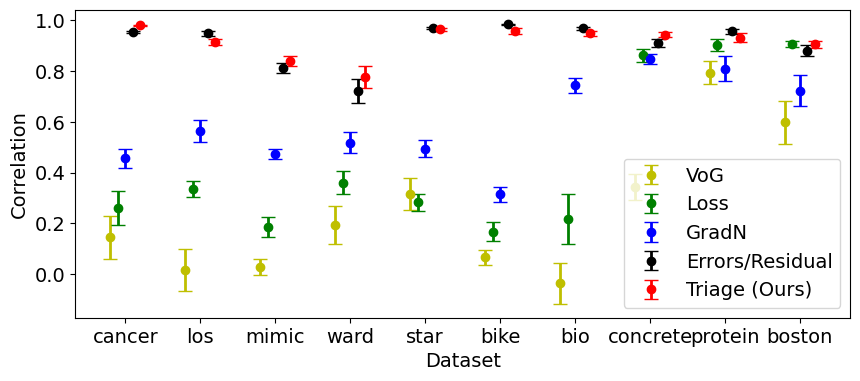

In [ ]:

datasets = ['cancer', 'los', 'mimic', 'ward', 'star', 'bike', 'bio', 'concrete', 'protein', 'boston']

methods = ['VoG', 'Loss', 'GradN', 'Errors/Residual', 'Triage (Ours)']#, 'alea']


colors = ['y', 'g', 'b', 'k', 'r', 'c']


plt.figure(figsize=(10,4))

means = cancer_means_spearman
stds = cancer_sem_spearman
x_val=0
for i, method in enumerate(methods):
    plt.errorbar(x = x_val, y = means[i], yerr = stds[i], label=method, marker='o', linestyle="", color=colors[i],capsize=5, elinewidth=2)
    x_val+=0.1
    
means = los_means_spearman
stds = los_sem_spearman
x_val=1
for i, method in enumerate(methods):
    plt.errorbar(x = x_val, y = means[i], yerr = stds[i], marker='o', linestyle="", color=colors[i],capsize=5, elinewidth=2)
    x_val+=0.1


means = mimic_means_spearman
stds = mimic_sem_spearman
x_val=2
for i, method in enumerate(methods):
    plt.errorbar(x = x_val, y = means[i], yerr = stds[i], marker='o', linestyle="", color=colors[i],capsize=5, elinewidth=2)
    x_val+=0.1


means = ward_means_spearman
stds = ward_sem_spearman
x_val=3
for i, method in enumerate(methods):
    plt.errorbar(x = x_val, y = means[i], yerr = stds[i], marker='o', linestyle="", color=colors[i],capsize=5, elinewidth=2)
    x_val+=0.1
    
means = star_means_spearman
stds = star_sem_spearman
x_val=4
for i, method in enumerate(methods):
    plt.errorbar(x = x_val, y = means[i], yerr = stds[i], marker='o', linestyle="", color=colors[i],capsize=5, elinewidth=2)
    x_val+=0.1
    
means = bike_means_spearman
stds = bike_sem_spearman
x_val=5
for i, method in enumerate(methods):
    plt.errorbar(x = x_val, y = means[i], yerr = stds[i], marker='o', linestyle="", color=colors[i],capsize=5, elinewidth=2)
    x_val+=0.1
    
means = bio_means_spearman
stds = bio_sem_spearman
x_val=6
for i, method in enumerate(methods):
    plt.errorbar(x = x_val, y = means[i], yerr = stds[i], marker='o', linestyle="", color=colors[i],capsize=5, elinewidth=2)
    x_val+=0.1
    
means = concrete_means_spearman
stds = concrete_sem_spearman
x_val=7
for i, method in enumerate(methods):
    plt.errorbar(x = x_val, y = means[i], yerr = stds[i], marker='o', linestyle="", color=colors[i],capsize=5, elinewidth=2)
    x_val+=0.1
    
means = protein_means_spearman
stds = protein_sem_spearman
x_val=8
for i, method in enumerate(methods):
    plt.errorbar(x = x_val, y = means[i], yerr = stds[i], marker='o', linestyle="", color=colors[i],capsize=5, elinewidth=2)
    x_val+=0.1
    
means = boston_means_spearman
stds = boston_sem_spearman
x_val=9
for i, method in enumerate(methods):
    plt.errorbar(x = x_val, y = means[i], yerr = stds[i], marker='o', linestyle="", color=colors[i],capsize=5, elinewidth=2)
    x_val+=0.1



plt.xticks([0.2,1.2,2.2,3.2,4.2,5.2,6.2, 7.2, 8.2, 9.2], datasets)
plt.xlabel('Dataset')
plt.ylabel('Correlation')
leg = plt.legend()
plt.show()


### Grouped

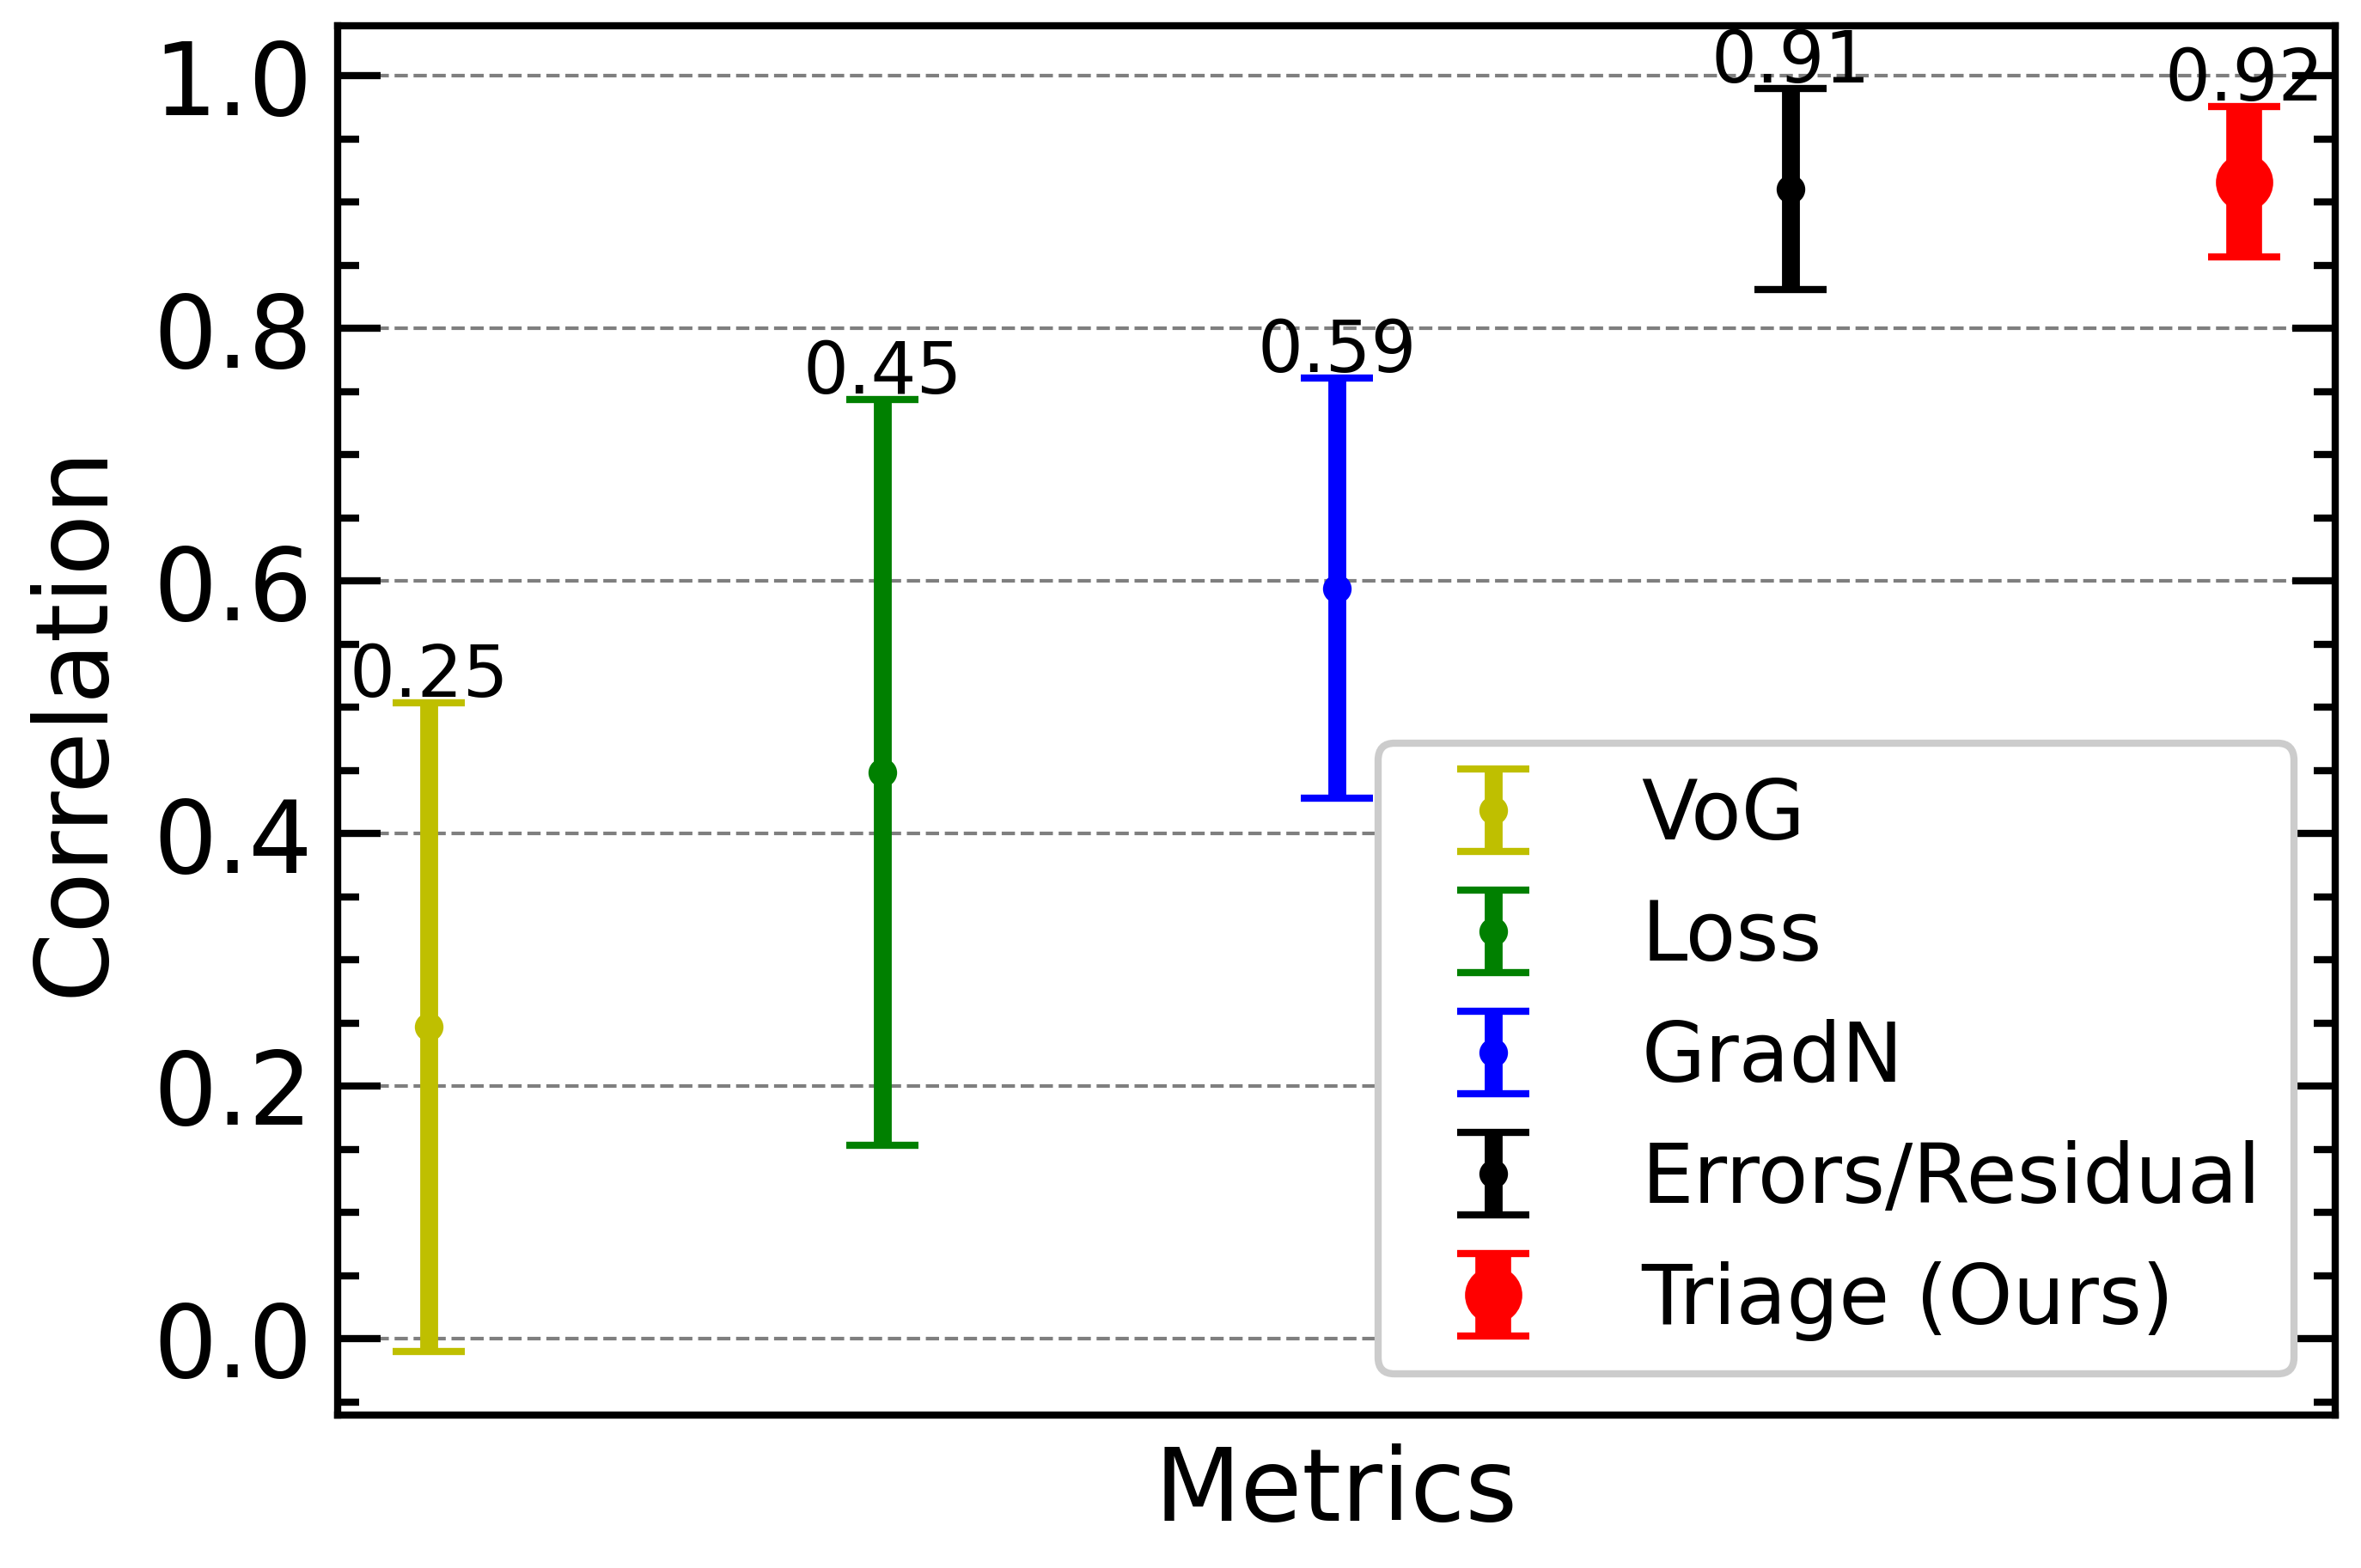

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.style.reload_library()
plt.style.use(["science", "ieee", "no-latex", "notebook", "grid", "vibrant"])
SMALL_SIZE = 10
MEDIUM_SIZE = 50
BIGGER_SIZE = 50

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



datasets = ['cf', 'cancer', 'mimic', 'ward', 'star', 'bike', 'bio', 'concrete', 'protein', 'boston']

methods = ['VoG', 'Loss', 'GradN', 'Errors/Residual', 'Triage (Ours)']#, 'alea']

colors = ['y', 'g', 'b', 'k', 'r', 'c']


plt.figure(figsize=(5,3.5))

means = []


means.append(cancer_means_spearman)
means.append(mimic_means_spearman)
means.append(ward_means_spearman)
means.append(star_means_spearman)
means.append(bike_means_spearman)
means.append(bio_means_spearman)
means.append(concrete_means_spearman)
means.append(protein_means_spearman)
means.append(boston_means_spearman)
means.append(los_means_spearman)



means = np.array(means)

overall_mean = np.mean(means, axis=0)
overall_std = np.std(means, axis=0)

x_val=0
for i, method in enumerate(methods):
    if i==4:
        plt.errorbar(x = x_val, y = overall_mean[i], yerr = overall_std[i], label=method, marker='o', linestyle="", color=colors[i],capsize=5, elinewidth=5, markersize=7)
    else:
        plt.errorbar(x = x_val, y = overall_mean[i], yerr = overall_std[i], label=method, marker='o', linestyle="", color=colors[i],capsize=5, elinewidth=2.5, markersize=3)
    plt.annotate(str(np.round(overall_mean[i],2)), (x_val-0.0175, overall_mean[i]+ overall_std[i]+0.005))
    x_val+=0.1
    

plt.xlabel('Metrics')
plt.xticks([], [])
plt.ylabel('Correlation')

font_size = 11.5
font_props = fm.FontProperties(size=font_size)
leg = plt.legend(prop=font_props)
plt.show()
